In [196]:
import copy
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import warnings
import glob
import os
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
import random

warnings.filterwarnings('ignore')

In [5]:
plt.style.reload_library()
plt.style.use(['science','ieee'])
plt.rcParams.update({
    'ytick.right': False,
    'xtick.top': False 
})

#### CDF of packet loss in time bins for both apps

In [161]:
files_webex = glob.glob("Retina/shared/Call_with_log/*/*_500ms_Song_no_log.csv")
files_webrtc = glob.glob("Retina/shared/Dataset_jitsi/*/*_500ms_Song_no_log.csv")
apps = [files_webex, files_webrtc]

num_loss_dict_webex = {'num_loss':[]}
num_loss_dict_webrtc = {'num_loss':[]}

num_bin_total_webex = 0
num_bin_loss_webex = 0
num_bin_total_webrtc = 0
num_bin_loss_webrtc = 0

app_idx = -1
for app_files in apps:
    
    app_idx += 1
    if app_idx == 0:
        list_loss = num_loss_dict_webex['num_loss']
    else:
        list_loss = num_loss_dict_webrtc['num_loss']
    
    for file in app_files:
        df_input = pd.read_csv(file)
        df_inter = copy.deepcopy(df_input)
        num_received_packets = df_inter['num_packets'].max()
        df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
        for col in df_inter.columns:
            if col not in ['timestamp', 'num_packet_loss', 'flow', 'num_packets']:
                df_inter.drop(col, axis=1, inplace=True)

        flow_list = df_inter['flow'].drop_duplicates().tolist()
        for flow in flow_list:
            df_per_flow = copy.deepcopy(df_inter[df_inter['flow'] == flow])
            if df_per_flow.shape[0] > 10:
                df_per_flow.reset_index(inplace=True)
                df_per_flow.drop(['index', 'flow'], axis=1, inplace=True)
                df_per_flow["timestamp"] = pd.to_datetime(df_per_flow["timestamp"])
                loss_index_list = df_per_flow[df_per_flow['num_packet_loss'] > 0].index.tolist()
                
                if app_idx == 0:
                    num_bin_total_webex += df_per_flow.shape[0]
                    num_bin_loss_webex += len(loss_index_list)
                else:
                    num_bin_total_webrtc += df_per_flow.shape[0]
                    num_bin_loss_webrtc += len(loss_index_list)

                if loss_index_list:
                    list_loss.append(df_per_flow.iloc[loss_index_list[0]]['num_packet_loss'])
                    for i in range(1, len(loss_index_list)):
                        list_loss.append(df_per_flow.iloc[loss_index_list[i]]['num_packet_loss'])

In [162]:
df_num_loss_webex = pd.DataFrame(num_loss_dict_webex)
df_num_loss_webex = df_num_loss_webex.sort_values(by=['num_loss'])
df_num_loss_webex['count'] = df_num_loss_webex['num_loss']
df_num_loss_webex = df_num_loss_webex.groupby('num_loss').count()

df_num_loss_webrtc = pd.DataFrame(num_loss_dict_webrtc)
df_num_loss_webrtc = df_num_loss_webrtc.sort_values(by=['num_loss'])
df_num_loss_webrtc['count'] = df_num_loss_webrtc['num_loss']
df_num_loss_webrtc = df_num_loss_webrtc.groupby('num_loss').count()

In [17]:
num_bin_loss_webex, num_bin_loss_webrtc = 12114, 20358
num_bin_total_webex, num_bin_total_webrtc = 12114 + 794925, 20358 + 1310330

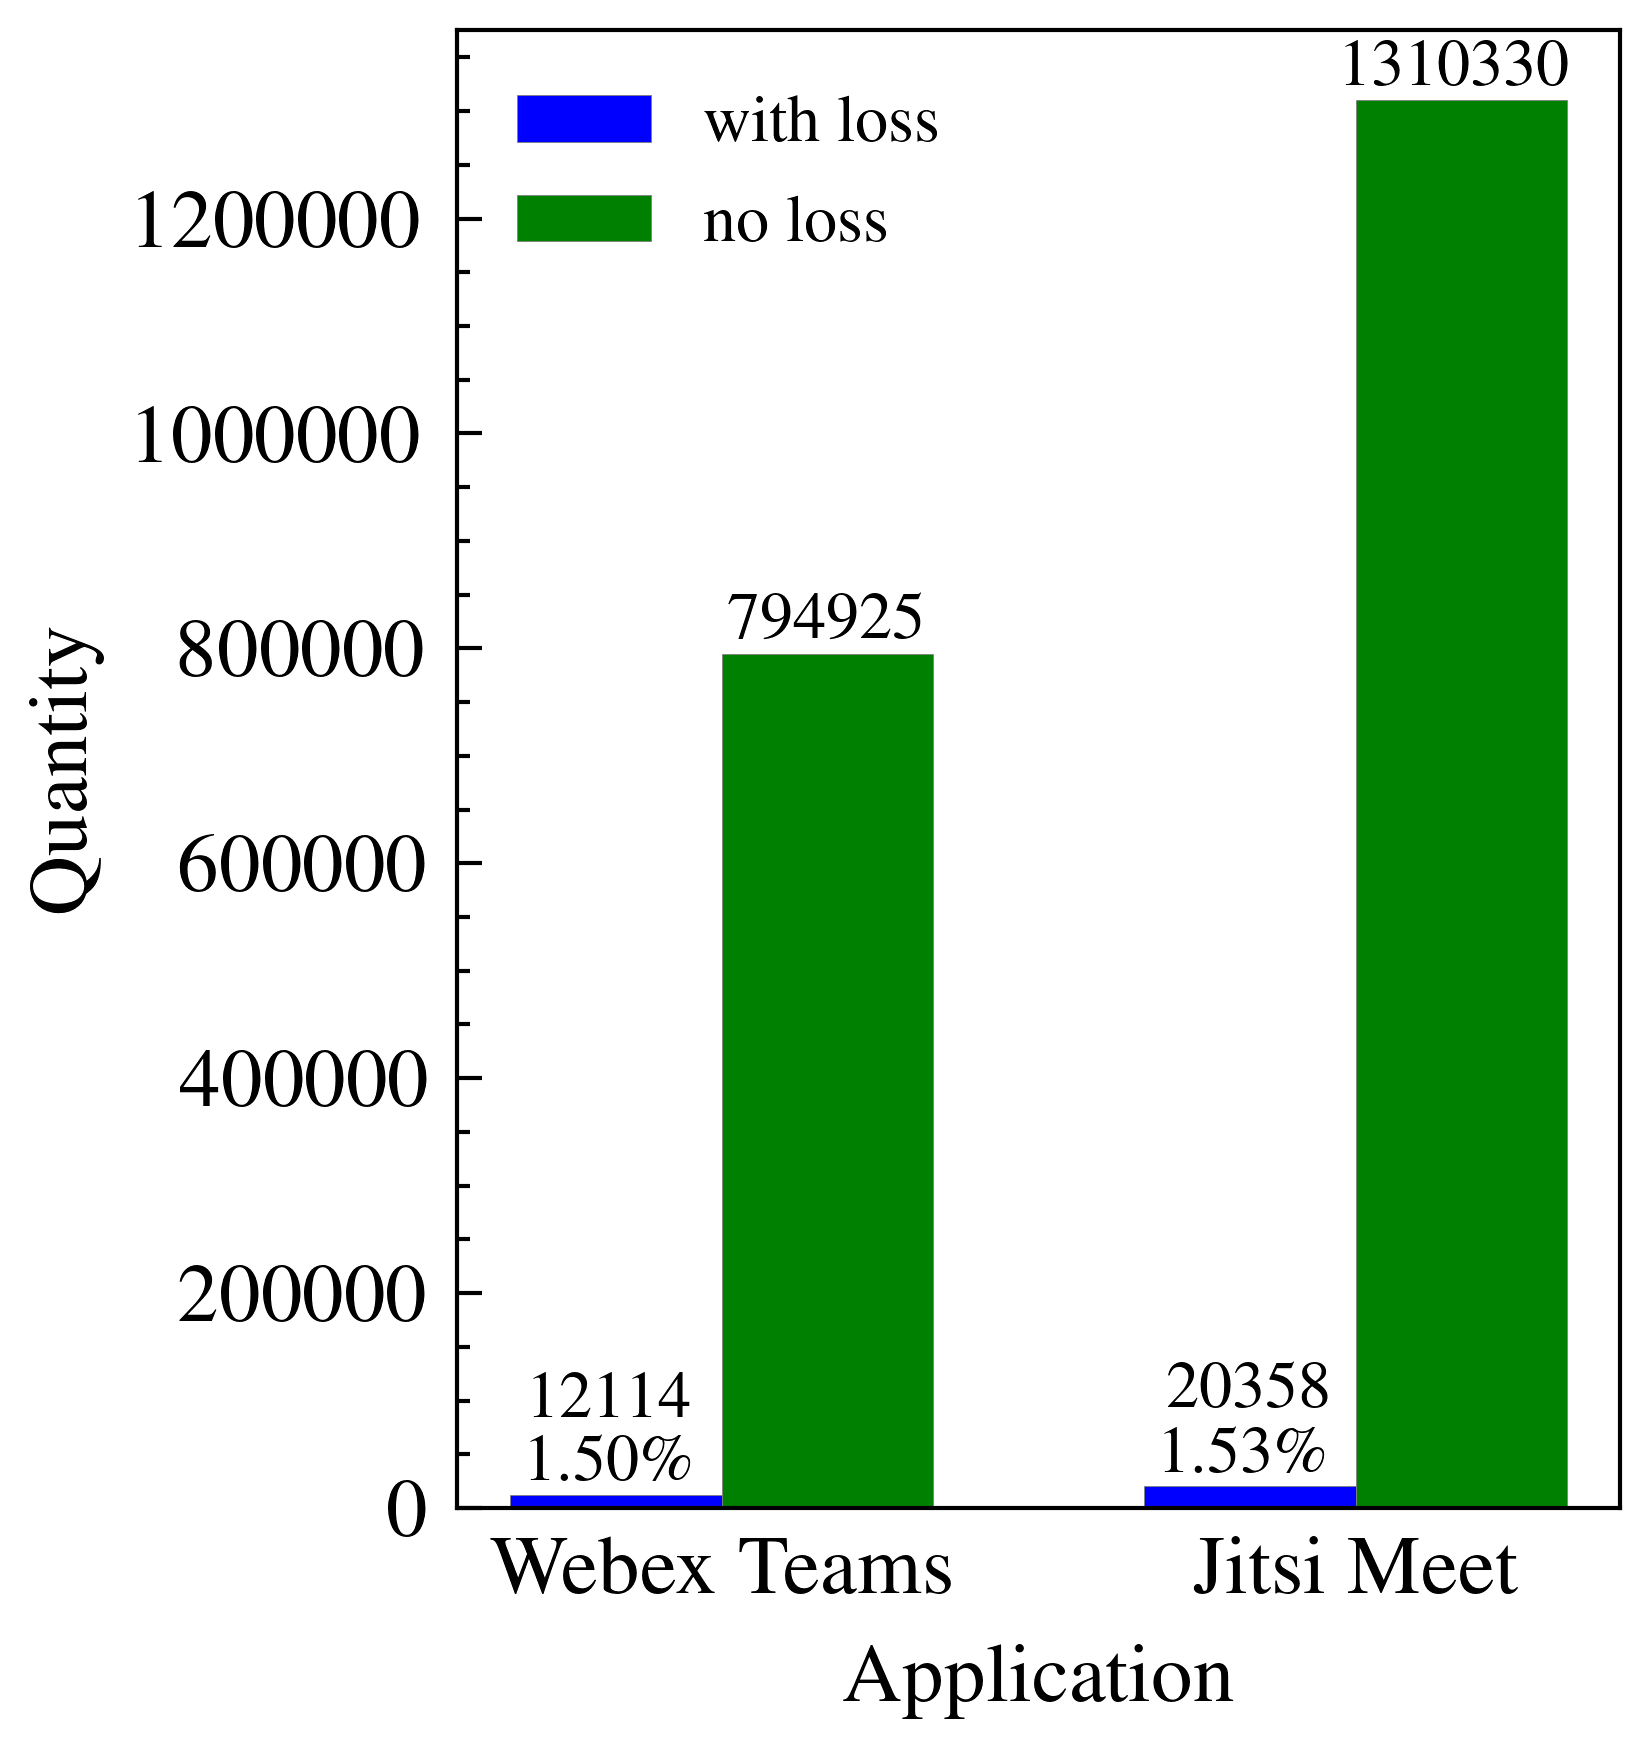

In [21]:
barWidth = 0.25
br1 = [0, barWidth*3]
br2 = [barWidth, barWidth*4]
num_loss_list = [num_bin_loss_webex, num_bin_loss_webrtc]
num_loss_percentage_list = [format(num_bin_loss_webex/num_bin_total_webex*100, '.2f')+'\%', format(num_bin_loss_webrtc/num_bin_total_webrtc*100, '.2f')+'\%']
num_no_loss_list = [num_bin_total_webex-num_bin_loss_webex, num_bin_total_webrtc-num_bin_loss_webrtc]

plt.figure(figsize=(2.5, 3.2))
bar1 = plt.bar(br1, num_loss_list, color ='b', width = barWidth, linewidth = 0.1, edgecolor ='grey', label = 'with loss')
bar2 = plt.bar(br2, num_no_loss_list, color ='g', width = barWidth, linewidth = 0.1, edgecolor ='grey', label ='no loss')
i = 0
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height+60000, num_loss_list[i], ha='center', va='bottom')
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, num_loss_percentage_list[i], ha='center', va='bottom')
    i += 1
i = 0
for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, num_no_loss_list[i], ha='center', va='bottom')
    i += 1
plt.xlabel("Application", fontsize=10)
plt.ylabel("Quantity", fontsize=10)
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().tick_params(labelsize=10)
# plt.title("Number of time bin with/without loss for both applications")
plt.xticks([barWidth/2, barWidth*3+barWidth/2], ['Webex Teams', 'Jitsi Meet'])
plt.legend()

plt.savefig('./plots_plus/quantity_app')

plt.show()

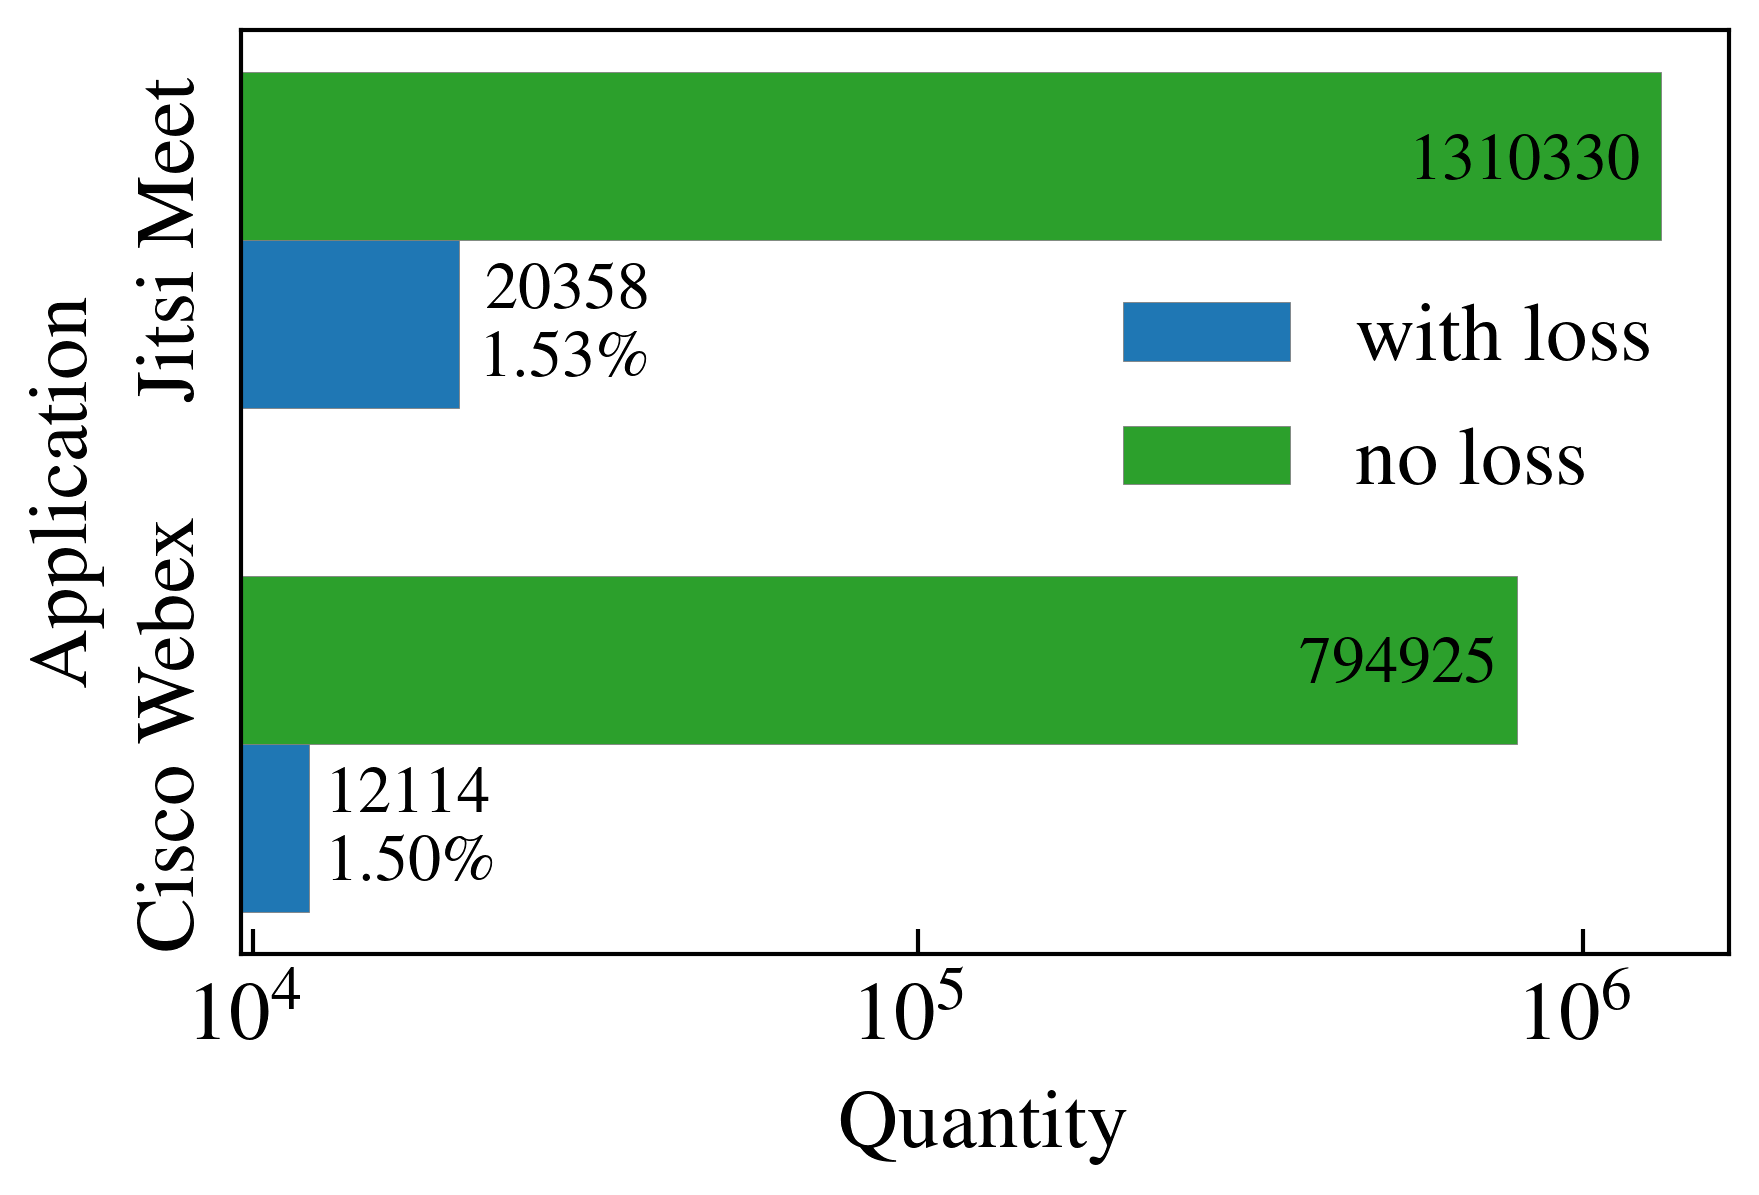

In [191]:
barWidth = 0.25
br1 = [0, barWidth*3]
br2 = [barWidth, barWidth*4]
num_loss_list = [num_bin_loss_webex, num_bin_loss_webrtc]
num_loss_percentage_list = [format(num_bin_loss_webex/num_bin_total_webex*100, '.2f')+'\%', format(num_bin_loss_webrtc/num_bin_total_webrtc*100, '.2f')+'\%']
num_no_loss_list = [num_bin_total_webex-num_bin_loss_webex, num_bin_total_webrtc-num_bin_loss_webrtc]

plt.figure(figsize=(3.2, 2))
plt.xscale('log')
bar1 = plt.barh(br1, num_loss_list, color ='tab:blue', height = barWidth, linewidth = 0.1, edgecolor ='grey', label = 'with loss')
bar2 = plt.barh(br2, num_no_loss_list, color ='tab:green', height = barWidth, linewidth = 0.1, edgecolor ='grey', label ='no loss')
i = 0
for rect in bar1:
    width = rect.get_width()
    if i == 1:
        plt.text(width+2000, rect.get_y() + rect.get_height() / 5.4, f'{num_loss_list[i]}\n {num_loss_percentage_list[i]}')
    else:
        plt.text(width+1000, rect.get_y() + rect.get_height() / 5.4, f'{num_loss_list[i]}\n {num_loss_percentage_list[i]}')
    i += 1
i = 0
for rect in bar2:
    width = rect.get_width()
    if i == 1:
        plt.text(width-7.5e5, rect.get_y() + rect.get_height() / 2.8, num_no_loss_list[i])
    else:
        plt.text(width-4.2e5, rect.get_y() + rect.get_height() / 2.8, num_no_loss_list[i])
    i += 1
plt.ylabel("Application", fontsize=10)
plt.xlabel("Quantity", fontsize=10)
# plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.gca().yaxis.set_ticks_position('none') 
plt.gca().tick_params(labelsize=10)
# plt.title("Number of time bin with/without loss for both applications")
plt.yticks([barWidth*1.7, barWidth*4.3], ['Cisco Webex', 'Jitsi Meet'], rotation=90)
plt.gca().set_xticks([1e4, 1e5, 1e6], [1e4, 1e5, 1e6])
plt.legend(loc=5, bbox_to_anchor=(1,0.6), fontsize=10)
# plt.legend(bbox_to_anchor=(0.4, 0.5, 1, 0.2), loc="right center", borderaxespad=0, ncol=1, fontsize=10)

plt.savefig('./plots_plus/quantity_app.pdf')

plt.show()

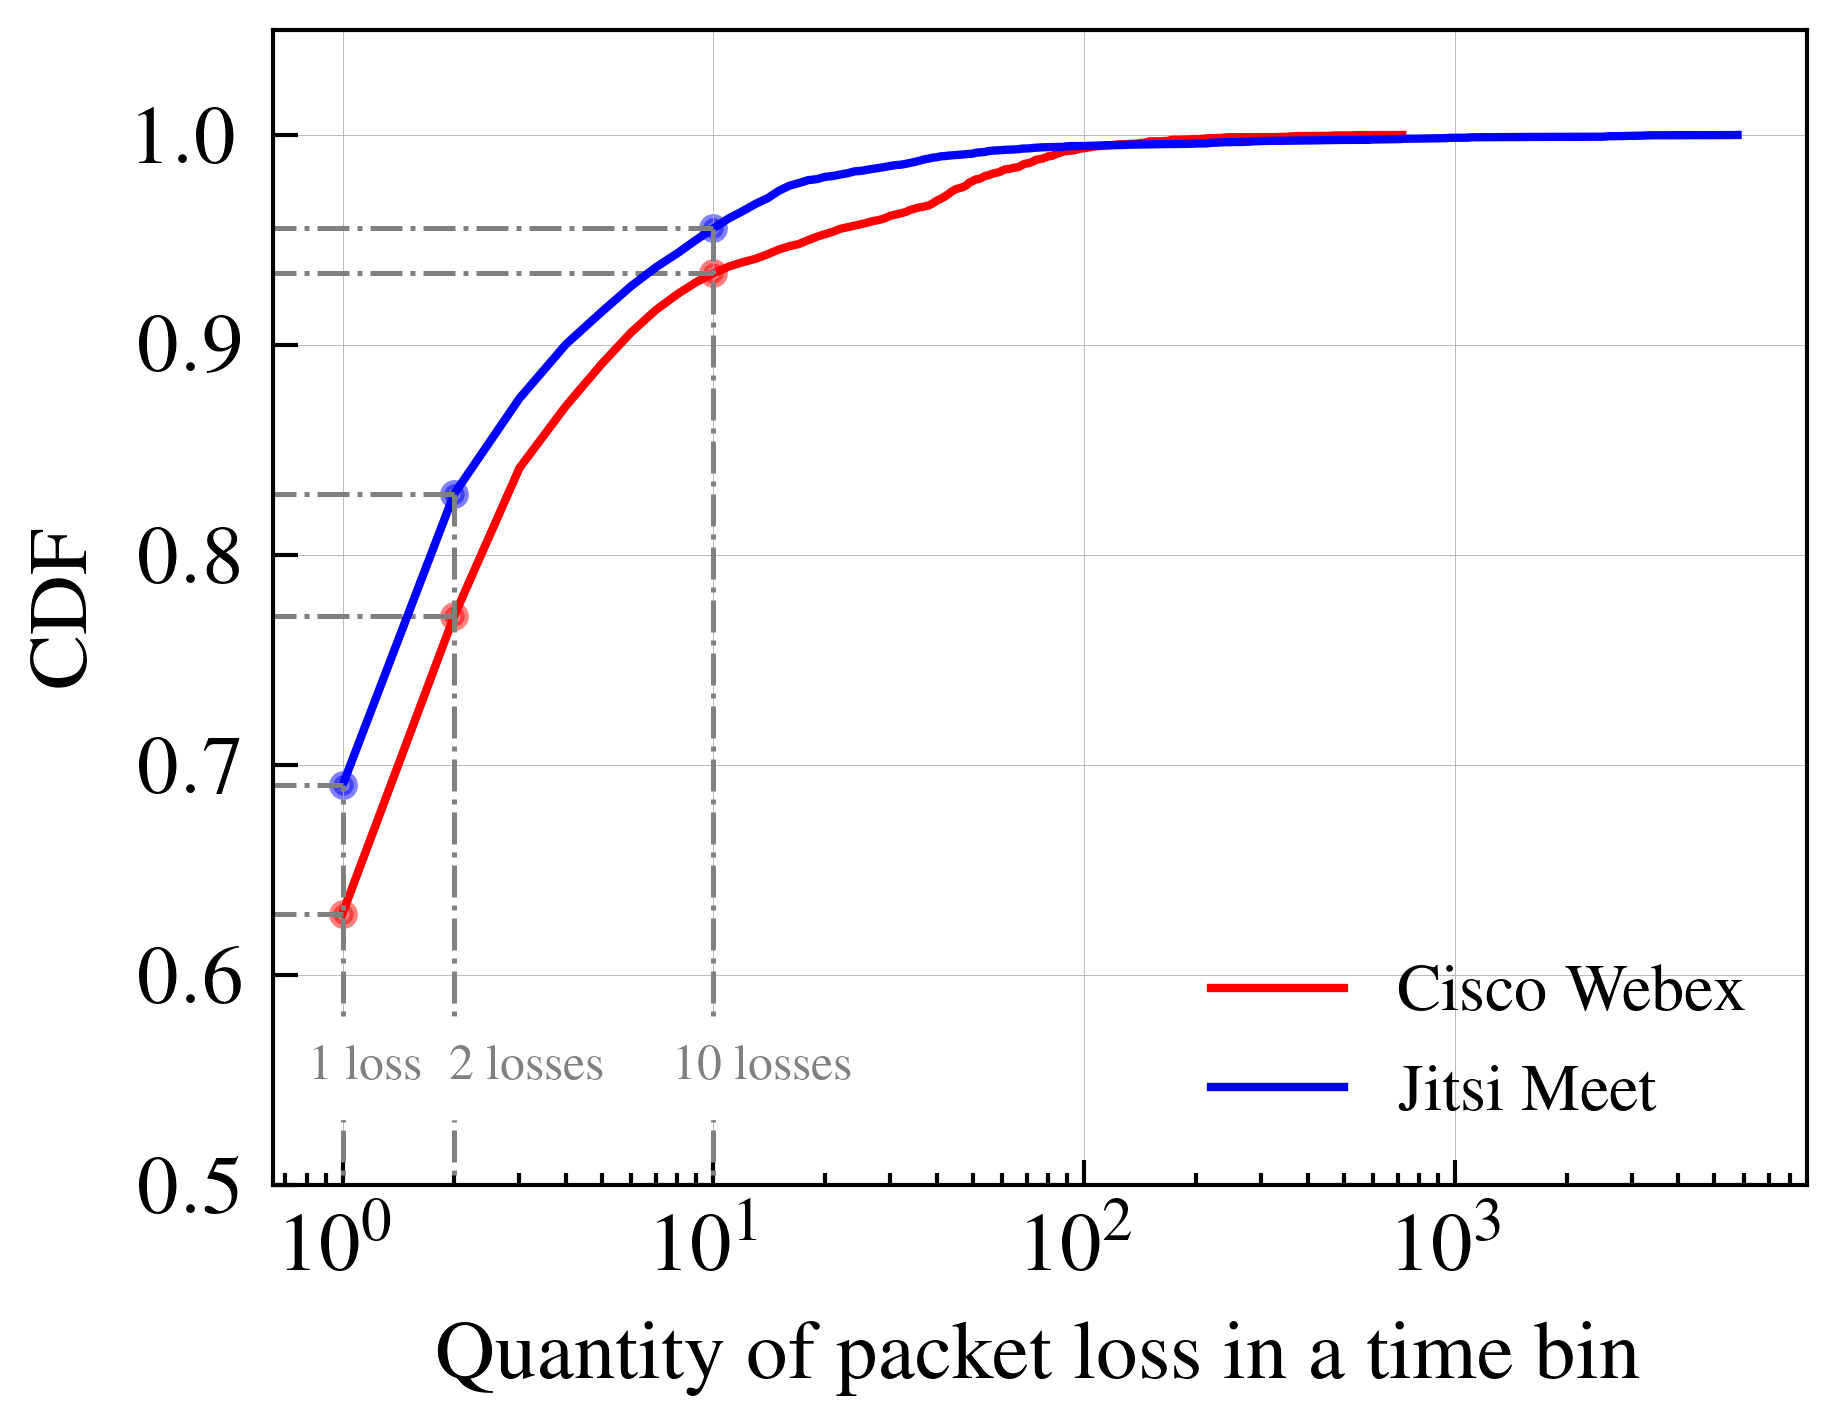

In [192]:
fig = plt.figure()

cdf_loss = []
sum_loss = df_num_loss_webex['count'].sum()
total = 0
for count in df_num_loss_webex['count']:
    total += count
    cdf_loss.append(total / sum_loss)
plt.plot(df_num_loss_webex.index, cdf_loss, '-', color='r', label='Cisco Webex')

plt.plot([0, 1], [cdf_loss[0], cdf_loss[0]], color='grey', linestyle='-.', linewidth=0.6)
plt.scatter(1, cdf_loss[0], color='r', s=6, alpha=0.5)
plt.plot([0, 2], [cdf_loss[1], cdf_loss[1]], color='grey', linestyle='-.', linewidth=0.6)
plt.scatter(2, cdf_loss[1], color='r', s=6, alpha=0.5)
plt.plot([0, 10], [cdf_loss[9], cdf_loss[9]], color='grey', linestyle='-.', linewidth=0.6)
plt.scatter(10, cdf_loss[9], color='r', s=6, alpha=0.5)
# sec_y_lim_list = []
# sec_y_lim_list = [cdf_loss[0], cdf_loss[1], cdf_loss[9]]

cdf_loss = []
sum_loss = df_num_loss_webrtc['count'].sum()
total = 0
for count in df_num_loss_webrtc['count']:
    total += count
    cdf_loss.append(total / sum_loss)
plt.plot(df_num_loss_webrtc.index, cdf_loss, '-', color='b', label='Jitsi Meet')

plt.plot([1, 1], [0, cdf_loss[0]], color='grey', linestyle='-.', linewidth=0.6)
plt.plot([0, 1], [cdf_loss[0], cdf_loss[0]], color='grey', linestyle='-.', linewidth=0.6)
plt.scatter(1, cdf_loss[0], color='b', s=6, alpha=0.5)
plt.plot([2, 2], [0, cdf_loss[1]], color='grey', linestyle='-.', linewidth=0.6)
plt.plot([0, 2], [cdf_loss[1], cdf_loss[1]], color='grey', linestyle='-.', linewidth=0.6)
plt.scatter(2, cdf_loss[1], color='b', s=6, alpha=0.5)
plt.plot([10, 10], [0, cdf_loss[9]], color='grey', linestyle='-.', linewidth=0.6)
plt.plot([0, 10], [cdf_loss[9], cdf_loss[9]], color='grey', linestyle='-.', linewidth=0.6)
plt.scatter(10, cdf_loss[9], color='b', s=6, alpha=0.5)
# sec_y_lim_list.extend([cdf_loss[0], cdf_loss[1], cdf_loss[9]])
# sec_y_lim_list = [round(x,2) for x in sec_y_lim_list]

plt.xscale('log')
plt.ylim(0.5, 1.05)
# plt.xlim(0, 1e4)
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(linewidth=0.1)
plt.legend(loc=4)
# plt.title('The CDF of number of time bins \nwith different quantities of packet loss for applications')
plt.xlabel('Quantity of packet loss in a time bin', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.annotate('1 loss', (0.83, 0.55), color='grey', backgroundcolor="w", fontsize=6)
plt.annotate('2 losses', (1.95, 0.55), color='grey', backgroundcolor="w", fontsize=6)
plt.annotate('10 losses', (8, 0.55), color='grey', backgroundcolor="w", fontsize=6)

# ax2 = fig.gca().twinx()
# ax2.set_ylim(0, 1.05)
# ax2.set_yticks(sorted(sec_y_lim_list))

plt.gca().tick_params(labelsize=10)
plt.savefig('./plots_plus/cdf_loss_apps.pdf')

plt.show()

#### Packet loss characterization with features (*trends*)

In [3]:
files = glob.glob("Retina/shared/*/*/*_500ms_Song_no_log.csv")

scaler = preprocessing.MinMaxScaler()

df_total = []
for file in files:   
    df_input = pd.read_csv(file)
    
    df_inter = copy.deepcopy(df_input)
    df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
    drop_col = [
        'software', 
        'label', 
        'pcap', 
        'ssrc', 
        'rtp_seq_num_packet_loss', 
        'ip_src', 
        'ip_dst', 
        'prt_src', 
        'prt_dst', 
        'rtp_csrc_csrc_agg',
        'p_type'
    ]
    for col in df_inter.columns:
        if col in drop_col or col.startswith('rtp_interarrival'): 
            df_inter.drop(col, axis=1, inplace=True)
    
    flow_list = df_inter['flow'].drop_duplicates().tolist()
    for flow in flow_list:
        df_check = df_inter[df_inter['flow'] == flow].copy()
        if df_check.shape[0] > 11: 
            df_total.append(df_check)

df_total_final = []
for df_per_flow in df_total:
    df_temp = copy.deepcopy(df_per_flow)
    df_temp.reset_index(inplace=True)
    df_temp['lossOrNot'] = [1 if x>0 else 0 for x in df_temp['num_packet_loss']] 
    df_temp.drop(['num_packet_loss', 'index', 'flow'], axis=1, inplace=True)
    
    for col in df_temp.columns:
        if col not in ['timestamp', 'lossOrNot']:
            df_temp[col] = scaler.fit_transform(df_temp[col].values.reshape(-1,1))

    start_time = pd.to_datetime(df_temp['timestamp'].min())
    stop_time = pd.to_datetime(df_temp['timestamp'].max())
    timestamp_ser = pd.date_range(start_time, stop_time, freq="500L")
    correct_len = len(timestamp_ser)
    
    if df_temp.shape[0] == correct_len:
        df_full = copy.deepcopy(df_temp)
        df_total_final.append(df_full)
    
    else:
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_full = pd.DataFrame({'timestamp': timestamp_ser})
        df_full['timestamp'] = df_full['timestamp']
        df_full = df_full.merge(df_temp, on='timestamp', how='left')
        
        nan_index_list = [0]
        nan_index_list.extend(df_full[np.isnan(df_full['interarrival_std'])].index.tolist())
        nan_index_list.append(df_full.index[-1])
        
        for i in range(1, len(nan_index_list)):
            if nan_index_list[i] - nan_index_list[i-1] - 1 >= 11:
                start_idx = 0 if nan_index_list[i-1]==0 else nan_index_list[i-1]+1
                stop_idx = df_full.index[-1]+1 if nan_index_list[i]==df_full.index[-1] else nan_index_list[i]
                df_separate = df_full.iloc[start_idx:stop_idx, :].copy()
                df_separate.reset_index(inplace=True)
                df_separate.drop(['index'], axis=1, inplace=True)
                df_total_final.append(df_separate)

In [167]:
all_features = ['interarrival_std', 'interarrival_min']
window_size = 2 * 5 # 5sec
dist_list = [i for i in range(1, window_size+1)]
x_label_list = [f'-{500*i}ms' for i in range(1, window_size+1)]
x_label_list[0] = f'{x_label_list[0]}\n(loss in next 500ms)'
x_label_list.reverse()
x_label_list_plus = [f'{500*i}ms' for i in range(1, 11)]
x_label_list_plus[0] = f'{x_label_list_plus[0]}\n(no loss in past 3s)'
x_label_list_plus[-1] = f'{x_label_list_plus[-1]}\n(no loss in next 3s)'

In [6]:
# condition 1: no loss in past 5s for a loss;
# condition 2: at least one loss in past 5s for a loss;
# condition 3: consecutive 5s with no loss and in its neighborhood of 3s, there's also no loss.

final_result_mean = []

for feature in all_features:
    print(feature)
    
    result_1 = {} # condition 1
    result_2 = {} # condition 2
    result_3 = {} # condition 3
    for i in range(window_size, 0, -1):
        result_1[str(i)] = []
        result_2[str(i)] = []
        result_3[str(i)] = []
        
    for df_ in df_total_final:
        df_temp = copy.deepcopy(df_)
        loss_index_list = df_temp[df_temp['lossOrNot'] > 0].index
        loss_index_list = [x for x in loss_index_list if x>9] 
        
        # condition 1 and 2:
        if len(loss_index_list) != 0:
            loss_index_list_no_consecutive = []
            loss_index_list_with_consecutive = []
            
            # if there are more than 1 losses
            if len(loss_index_list) > 1:
                for i in range(len(loss_index_list)-1, 0, -1):
                    if (loss_index_list[i] - loss_index_list[i-1]) not in dist_list:
                        loss_index_list_no_consecutive.append(loss_index_list[i])
                    elif (loss_index_list[i] - loss_index_list[i-1]) in dist_list:
                        loss_index_list_with_consecutive.append(loss_index_list[i])
                loss_index_list_no_consecutive.append(loss_index_list[0])
                
            # if there's only one loss, put it directly into loss_index_list_no_consecutive
            else:
                loss_index_list_no_consecutive.append(loss_index_list[0])

            for i in range(window_size, 0, -1):
                values_1 = df_temp.iloc[[x - i for x in loss_index_list_no_consecutive]][feature].tolist()
                result_1[str(i)].extend(values_1)
                values_2 = df_temp.iloc[[x - i for x in loss_index_list_with_consecutive]][feature].tolist()
                result_2[str(i)].extend(values_2)
                
        # condition 3:
        if df_temp.shape[0] >= 22: 
            for key, df_output in df_temp.groupby((df_temp['lossOrNot'].shift() != df_temp['lossOrNot']).cumsum()):
                df_output.reset_index(inplace=True)
                if df_output.iloc[0]['lossOrNot'] < 1 and df_output.shape[0] >= 22:
                    df_output = df_output.iloc[6:-6][:]
                    df_seg_list = [df_output.iloc[n:n+10, :] for n in range(0, len(df_output), 10)]
                    for df_seg in df_seg_list:
                        if df_seg.shape[0] == 10:
                            df_seg.reset_index(inplace=True)
                            for i in range(1,11):
                                result_3[str(i)].append(df_seg.iloc[i-1][feature])
                
    output_mean_1 = []
    output_std_1 = []
    output_mean_2 = []
    output_std_2 = []
    output_mean_3 = []
    output_std_3 = []
    for i in range(window_size, 0, -1):
        
        # result of condition 1
        temp = np.array(result_1[str(i)])
        temp = temp[~np.isnan(temp)]
        output_mean_1.append(temp.mean())
        output_std_1.append(np.std(temp))
        
        # result of condition 2
        temp = np.array(result_2[str(i)])
        temp = temp[~np.isnan(temp)]
        output_mean_2.append(temp.mean())
        output_std_2.append(np.std(temp))
        
        # result of condition 3
        temp = np.array(result_3[str(i)])
        temp = temp[~np.isnan(temp)]
        output_mean_3.append(temp.mean())
        output_std_3.append(np.std(temp))
    
    print('mean:', output_mean_1)
    print('std:', output_std_1)
    print()
    final_result_mean.append(output_mean_1)
    print('mean:', output_mean_2)
    print('std:', output_std_2)
    print()
    final_result_mean.append(output_mean_2)
    print('mean:', output_mean_3)
    print('std:', output_std_3)
    print()
    final_result_mean.append(output_mean_3)

interarrival_std
mean: [0.09332797683569534, 0.09278117355692866, 0.09705285138684196, 0.0955540690562815, 0.09516476966411498, 0.0947882574918586, 0.09758128101599495, 0.09517139588297906, 0.09681589557771138, 0.10202475740022128]
std: [0.13421959003006728, 0.13258793361355417, 0.1401235583618419, 0.13690782516594358, 0.1357118807701139, 0.13322753749830563, 0.13800665750857913, 0.13086060254256598, 0.13196440685441457, 0.1378366927761506]

mean: [0.09800608056946847, 0.09801701276499979, 0.09842118749388502, 0.09693301076412483, 0.09750136670028418, 0.10011482707047648, 0.10310204190722329, 0.10616540647529561, 0.10888992805749861, 0.11293981201694864]
std: [0.14757848948209898, 0.14829820250665623, 0.1479958763257811, 0.1452007773342521, 0.14440176069401048, 0.14427733935508752, 0.14461773937005043, 0.14576333609514483, 0.14706105997431582, 0.14891061635241684]

mean: [0.10352308702722716, 0.1033335490428002, 0.10343514337378451, 0.10304858546876892, 0.10300363379554389, 0.103124302

In [165]:
# final_result_mean = []
# final_result_mean.append([0.09332797683569534, 0.09278117355692866, 0.09705285138684196, 0.0955540690562815, 0.09516476966411498, 0.0947882574918586, 0.09758128101599495, 0.09517139588297906, 0.09681589557771138, 0.10202475740022128])
# final_result_mean.append([0.09800608056946847, 0.09801701276499979, 0.09842118749388502, 0.09693301076412483, 0.09750136670028418, 0.10011482707047648, 0.10310204190722329, 0.10616540647529561, 0.10888992805749861, 0.11293981201694864])
# final_result_mean.append([0.10352308702722716, 0.1033335490428002, 0.10343514337378451, 0.10304858546876892, 0.10300363379554389, 0.1031243026039267, 0.10317777268511175, 0.10300714624406508, 0.10303718502669162, 0.10337584699332855])
# final_result_mean.append([0.19789574955084285, 0.19444184483715196, 0.19094490216396892, 0.19207580350405662, 0.19347744027242464, 0.19542399100771898, 0.19327981514052042, 0.1958020876879038, 0.192374983551646, 0.18804876428275424])
# final_result_mean.append([0.23567577935643466, 0.2359672287153388, 0.2372340964936527, 0.23683601213091404, 0.23572369969262313, 0.2322952142042597, 0.22861357815523883, 0.22434978018805005, 0.22328798593016572, 0.21960130499935457])
# final_result_mean.append([0.2678721569329422, 0.26748110847574263, 0.26696120425986597, 0.2674599832514584, 0.2686614569323261, 0.26767284616752424, 0.26762721191612915, 0.2678755466040029, 0.26740984056163647, 0.26706561609581875])

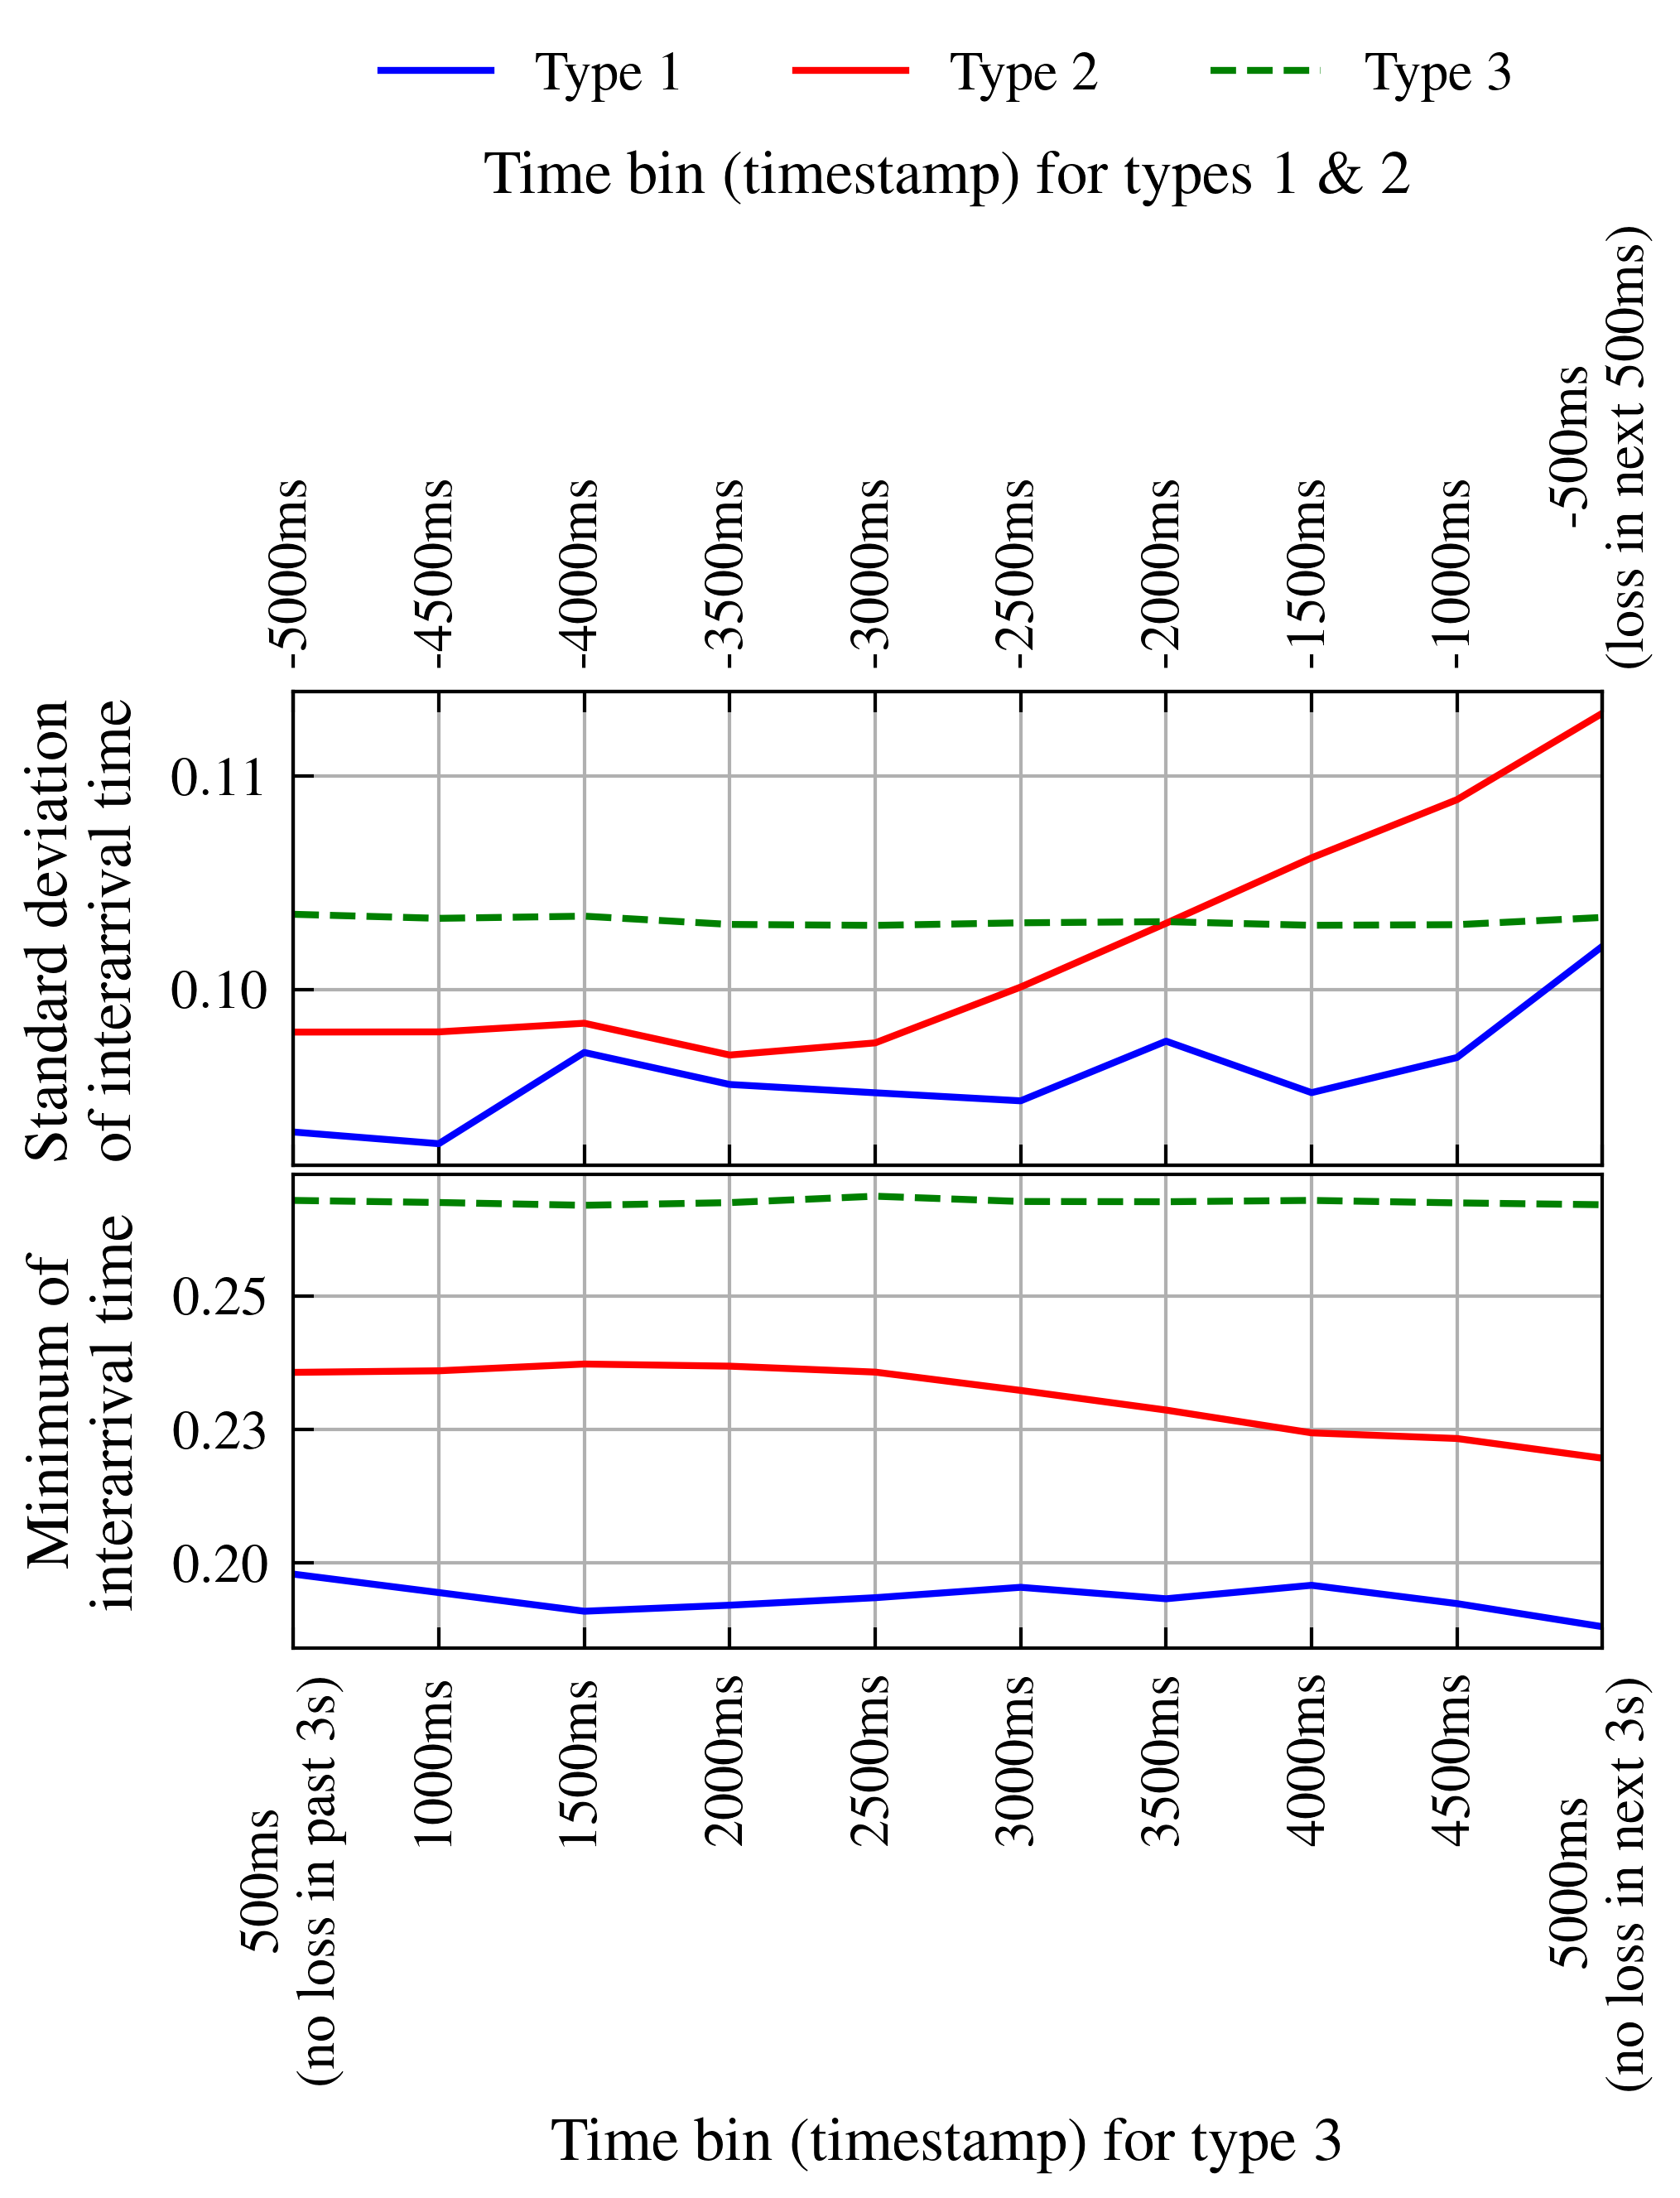

In [169]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams.update({
    'xtick.minor.visible': False,
    'ytick.minor.visible': False
})

plt.rcParams.update({'xtick.minor.visible': False})

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(3.4, 2.5))
ax1.plot(x_label_list, final_result_mean[0], '-', color='b', label='Type 1')
ax1.plot(x_label_list, final_result_mean[1], '-', color='r', label='Type 2')
ax1.plot(x_label_list, final_result_mean[2], '--', color='g', label='Type 3')
ax2.plot(x_label_list, final_result_mean[3], '-', color='b', label='Type 1')
ax2.plot(x_label_list, final_result_mean[4], '-', color='r', label='Type 2')
ax2.plot(x_label_list, final_result_mean[5], '--', color='g', label='Type 3')
ax1.grid(linewidth=0.5)
ax2.grid(linewidth=0.5)
ax1.set_xlim(0, window_size-1)
ax2.set_xlabel('Time bin (timestamp) for type 3', fontsize=9)
ax1.set_ylabel('Standard deviation \nof interarrival time', fontsize=9)
ax2.set_ylabel('Minimum of \ninterarrival time', fontsize=9)
ax2.set_xticklabels(x_label_list_plus, rotation=90)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))

sec_xaxe = ax1.twiny()
sec_xaxe.set_xticks(ax1.get_xticks())
sec_xaxe.set_xbound(ax1.get_xbound())
sec_xaxe.set_xticklabels(x_label_list, rotation=90)
sec_xaxe.set_xlabel('Time bin (timestamp) for types 1 \& 2', fontsize=9)

ax1.legend(bbox_to_anchor=(0, 2.2, 1, 0.2), loc="lower center", borderaxespad=0, ncol=3)

plt.subplots_adjust(wspace=0, hspace=0.02)
plt.gca().tick_params(labelsize=8)
sec_xaxe.tick_params(labelsize=8)

plt.savefig('./plots_plus/loss_characterization.pdf')
plt.show()

plt.rcParams.update({'xtick.minor.visible': True})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


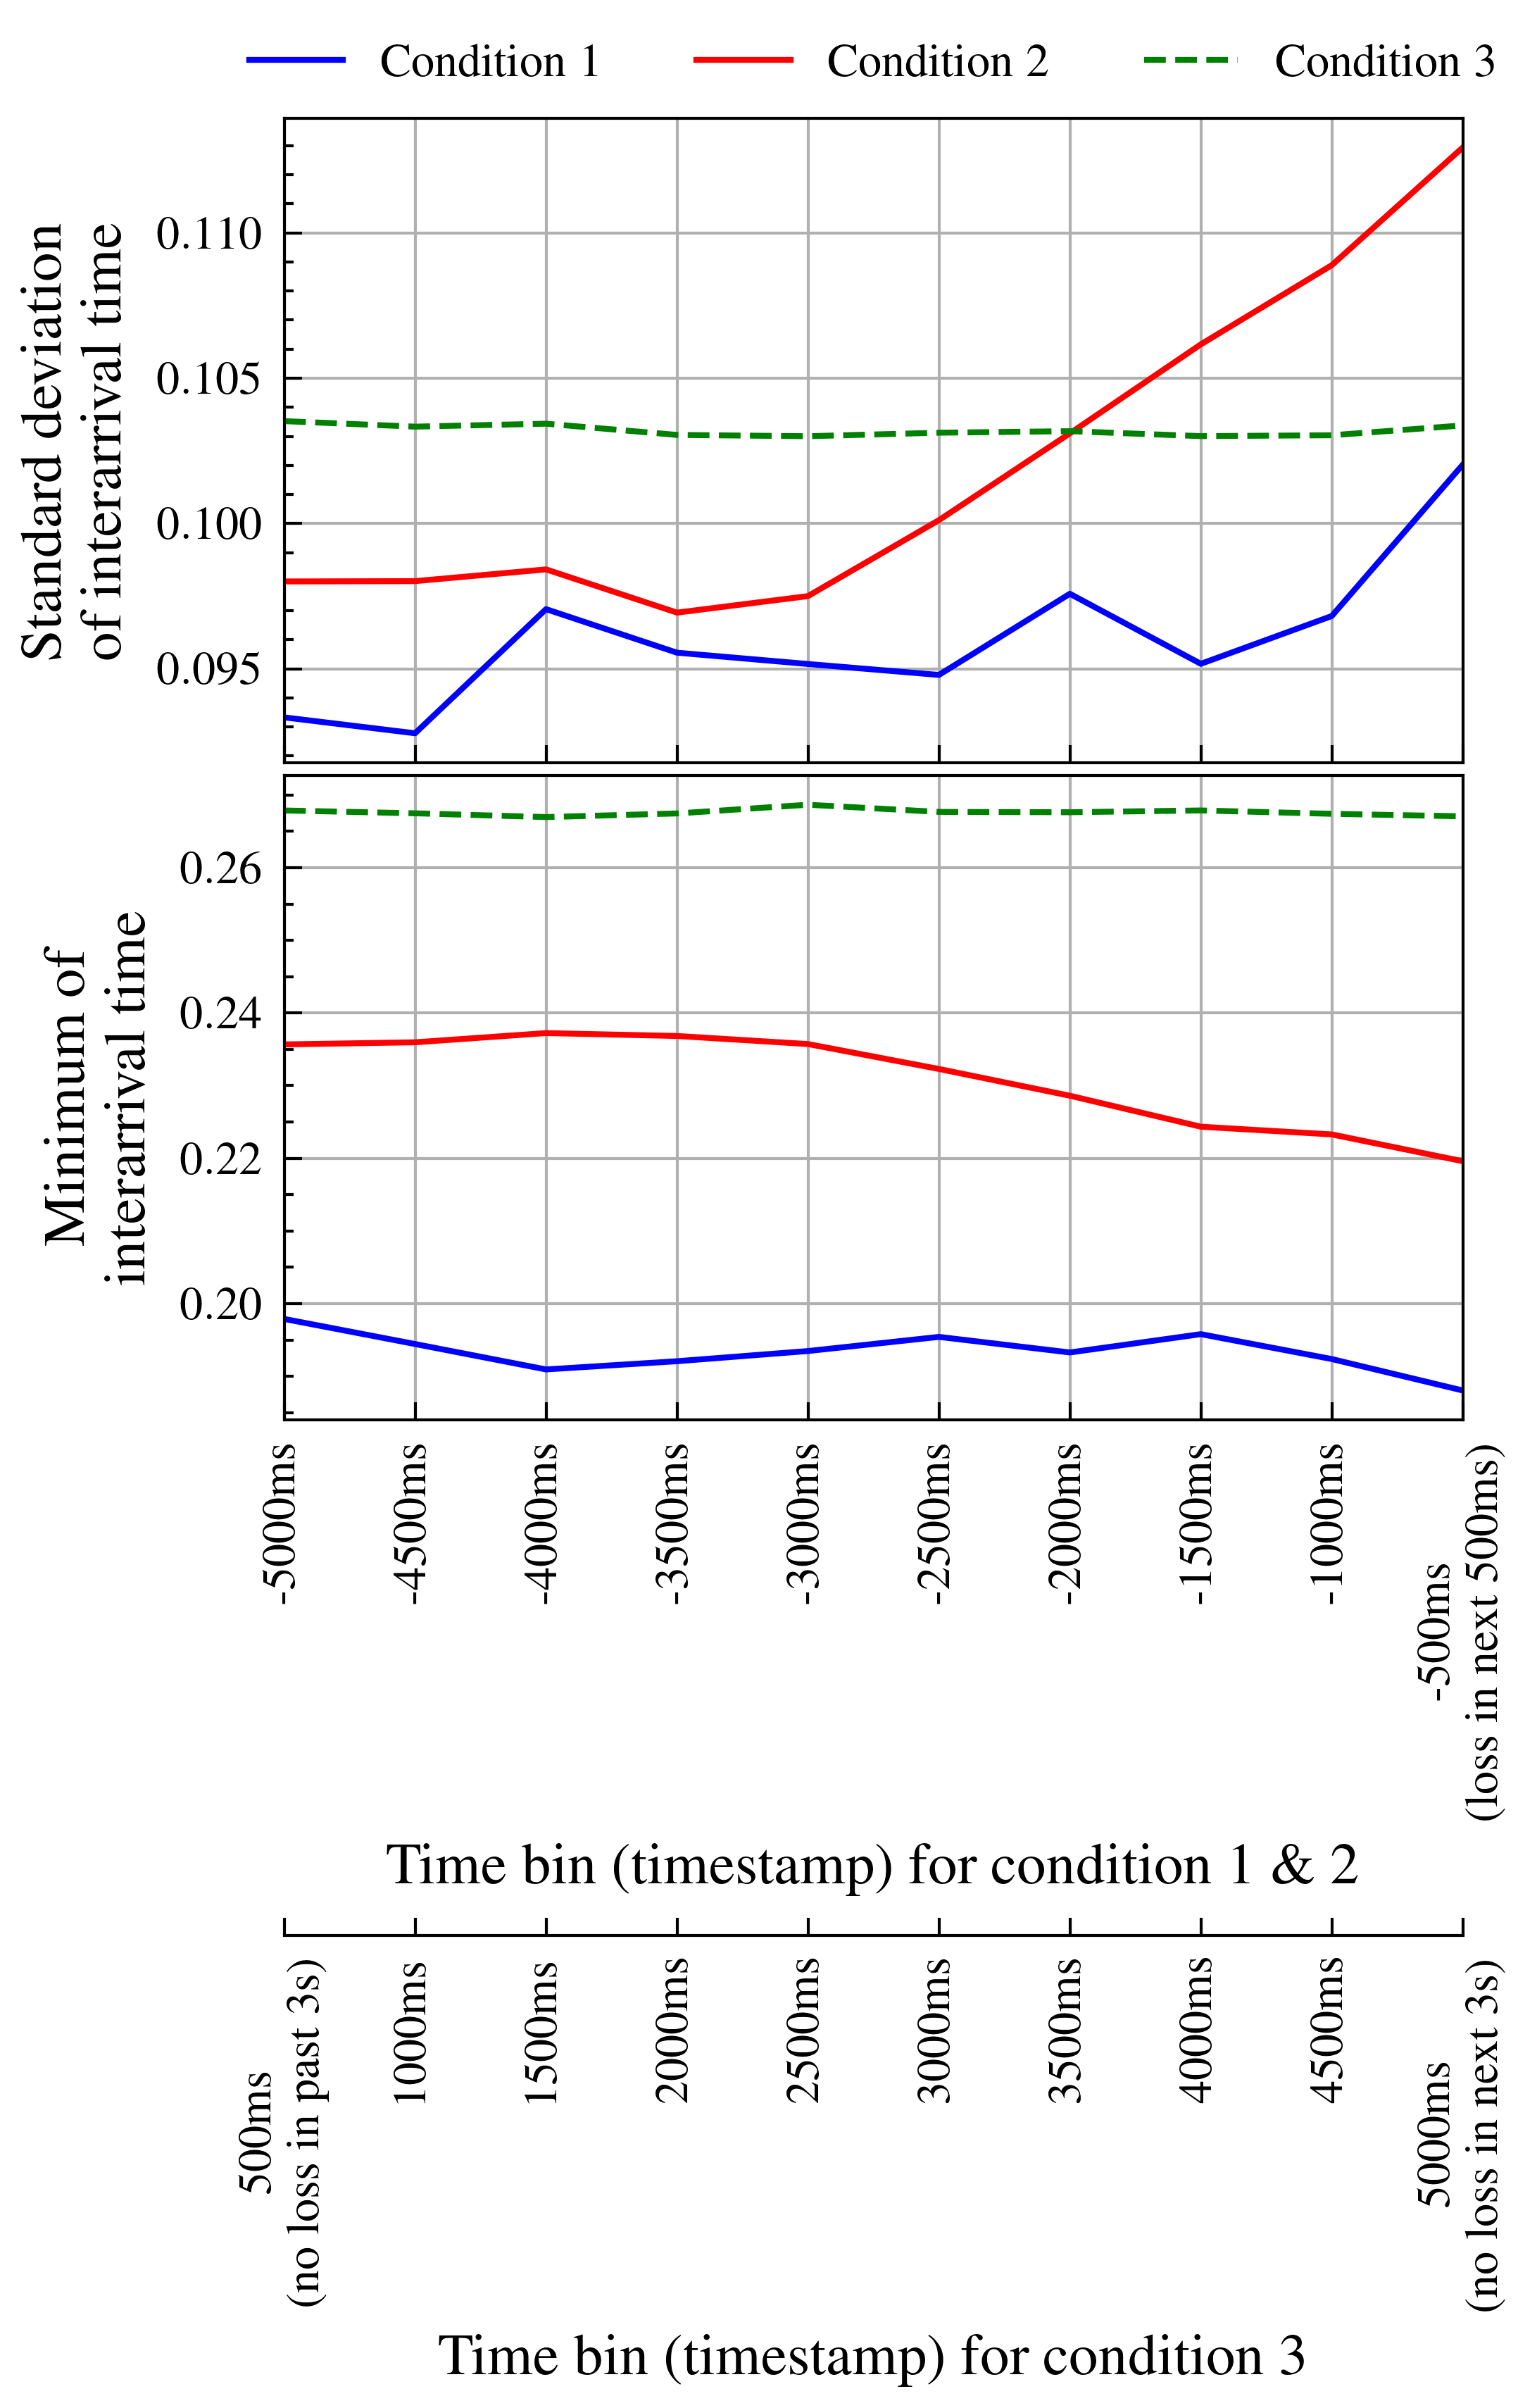

In [6]:
# old version of plot with both x-axes on the bottom

plt.rcParams.update({'xtick.minor.visible': False})

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(3.6, 4))
ax1.plot(x_label_list, final_result_mean[0], '-', color='b', label='Condition 1')
ax1.plot(x_label_list, final_result_mean[1], '-', color='r', label='Condition 2')
ax1.plot(x_label_list, final_result_mean[2], '--', color='g', label='Condition 3')
ax2.plot(x_label_list, final_result_mean[3], '-', color='b', label='Condition 1')
ax2.plot(x_label_list, final_result_mean[4], '-', color='r', label='Condition 2')
ax2.plot(x_label_list, final_result_mean[5], '--', color='g', label='Condition 3')
ax1.grid(linewidth=0.5)
ax2.grid(linewidth=0.5)
ax1.set_xlim(0, window_size-1)
ax2.set_xlabel('Time bin (timestamp) for condition 1 \& 2', fontsize=10)
ax1.set_ylabel('Standard deviation \nof interarrival time', fontsize=10)
ax2.set_ylabel('Minimum of \ninterarrival time', fontsize=10)
ax2.set_xticklabels(x_label_list, rotation=90)
plt.subplots_adjust(wspace=0, hspace=0.02)
ax1.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower center", borderaxespad=0, ncol=3)
sec_xaxe = ax2.secondary_xaxis(-0.8)
sec_xaxe.set_xticks([i for i in range(10)])
sec_xaxe.set_xticklabels(x_label_list_plus, rotation=90)
sec_xaxe.set_xlabel('Time bin (timestamp) for condition 3', fontsize=10)
plt.gca().tick_params(labelsize=8)
sec_xaxe.tick_params(labelsize=8)

plt.savefig('./plots_plus/loss_characterization_old')
plt.show()

plt.rcParams.update({'xtick.minor.visible': True})

#### packet loss distribution for the entire datast, correct prediction, and incorrect prediction

In [3]:
df_complete_with_features_final = pd.read_csv('models/df_final_label_feature_modified.csv')
df_complete_with_features_final

,timestamp,lossOrNot,flow_id,num_packet_loss,interarrival_std_minus_500ms,interarrival_std_minus_1000ms,interarrival_std_minus_1500ms,interarrival_std_minus_2000ms,interarrival_std_minus_2500ms,interarrival_std_minus_3000ms,...,inter_time_sequence_std_minus_500ms,inter_time_sequence_std_minus_1000ms,inter_time_sequence_std_minus_1500ms,inter_time_sequence_std_minus_2000ms,inter_time_sequence_std_minus_2500ms,inter_time_sequence_std_minus_3000ms,inter_time_sequence_std_minus_3500ms,inter_time_sequence_std_minus_4000ms,inter_time_sequence_std_minus_4500ms,inter_time_sequence_std_minus_5000ms
0,2020-12-14 13:34:44.500000,0.0,1.0,0.0,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,...,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312,0.000000
1,2020-12-14 13:34:45,0.0,1.0,0.0,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,...,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312
2,2020-12-14 13:34:45.500000,0.0,1.0,0.0,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,...,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376
3,2020-12-14 13:34:46,0.0,1.0,0.0,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,...,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850
4,2020-12-14 13:34:46.500000,0.0,1.0,0.0,0.113890,0.081800,0.122365,0.169699,0.185914,0.111167,...,0.210085,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028655,2020-05-13 14:59:09.000,0.0,2881.0,0.0,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,...,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018,0.934599
2028656,2020-05-13 14:59:09.500,0.0,2881.0,0.0,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,...,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018
2028657,2020-05-13 14:59:10.000,0.0,2881.0,0.0,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,...,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018
2028658,2020-05-13 14:59:10.500,0.0,2881.0,0.0,0.133611,0.048801,0.083497,0.083744,0.075046,0.078230,...,0.223662,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054


In [4]:
# reporduce the predictions using balacned random forest

complete_list = ['timestamp', 'lossOrNot', 'num_packet_loss']
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]
complete_list.extend(selected_features_list_removing_correlation)

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)

df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

df_loss_shuffled = df_loss.sample(frac=1).reset_index()
df_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.7)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot', 'num_packet_loss']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot', 'num_packet_loss']]
y_test = y_test.astype(int)

In [5]:
best_brf_model = BalancedRandomForestClassifier(bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=4, n_estimators=600, n_jobs=48)
best_brf_model.fit(x_train, y_train['lossOrNot'])

BalancedRandomForestClassifier(bootstrap=False, max_depth=90,
                               min_samples_leaf=2, min_samples_split=4,
                               n_estimators=600, n_jobs=48)

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    600134
           1       0.06      0.81      0.11      8461

    accuracy                           0.81    608595
   macro avg       0.53      0.81      0.50    608595
weighted avg       0.98      0.81      0.88    608595



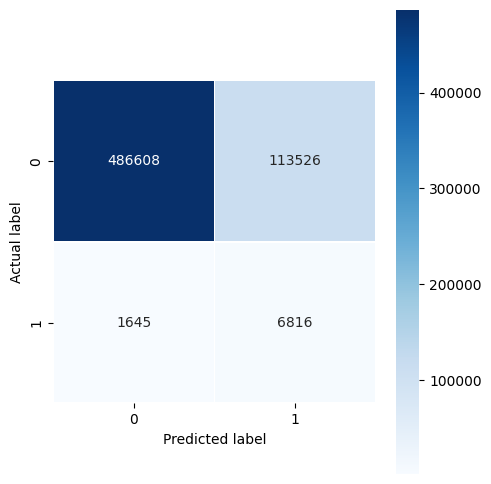

In [155]:
y_pred = best_brf_model.predict(x_test)
print("Prediction Report\n", classification_report(y_test['lossOrNot'], y_pred))
cm = confusion_matrix(y_test['lossOrNot'], y_pred)
with plt.style.context('default'):
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

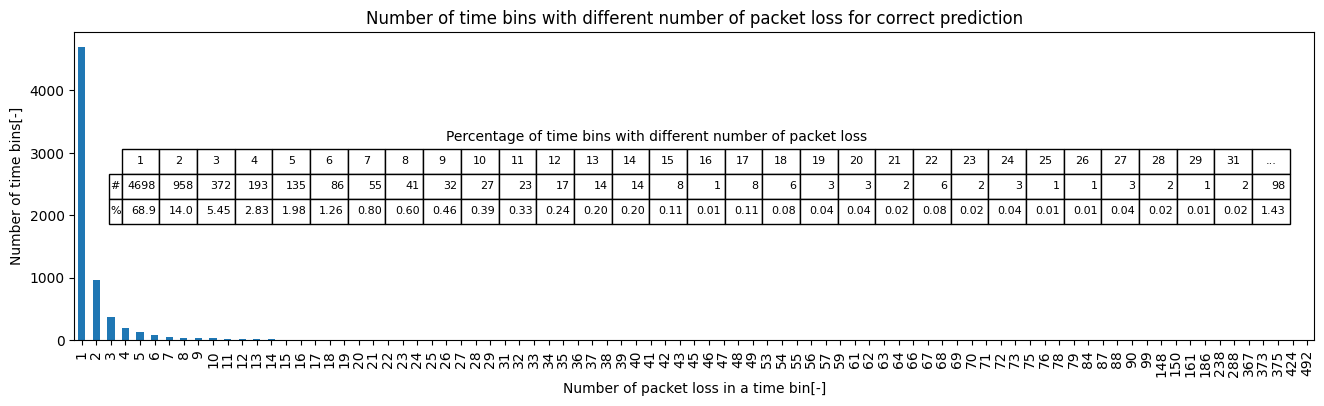

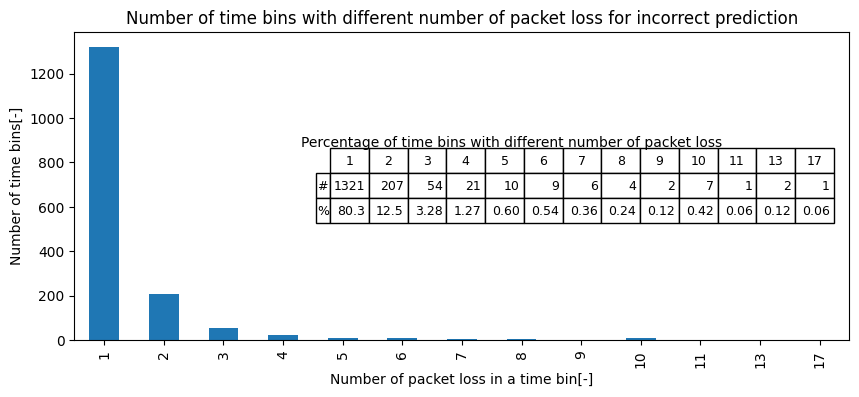

In [156]:
df_check = copy.deepcopy(y_test)
df_check['pred'] = y_pred
df_check = df_check[df_check['lossOrNot'] > 0]
df_check_correct_pred = df_check[df_check['lossOrNot'] == df_check['pred']]
df_check_incorrect_pred = df_check[df_check['lossOrNot'] != df_check['pred']]

with plt.style.context('default'):
    plt.figure(dpi=100)
    ax = df_check_correct_pred.groupby('num_packet_loss').count()['lossOrNot'].plot.bar(figsize=(16,4))
    plt.xlabel('Number of packet loss in a time bin[-]')
    plt.ylabel('Number of time bins[-]')
    plt.title('Number of time bins with different number of packet loss for correct prediction')

    num_list = df_check_correct_pred.groupby('num_packet_loss').count()['lossOrNot'].tolist()
    percentage_list = (df_check_correct_pred.groupby('num_packet_loss').count()['lossOrNot']/len(df_check_correct_pred)*100).tolist()
    data = [num_list[0:30], [str(x)[0:4] for x in percentage_list][0:30]]
    data[0].append(sum(num_list[30:-1]))
    data[1].append(str(sum(percentage_list[30:-1]))[0:4])
    columns = df_check_correct_pred.groupby('num_packet_loss').count()['lossOrNot'].index.tolist()[0:30]
    columns.append('...')
    rows = ['#', '%']
    table = plt.table(cellText=data, rowLabels=rows, colWidths = [0.031]*len(columns), colLabels=columns, loc='center right')
    table.scale(0.98, 1.5)
    plt.text(25, 3200, 'Percentage of time bins with different number of packet loss')

    plt.show()
    
    plt.figure(dpi=100)
    df_check_incorrect_pred.groupby('num_packet_loss').count()['lossOrNot'].plot.bar(figsize=(10,4))
    plt.xlabel('Number of packet loss in a time bin[-]')
    plt.ylabel('Number of time bins[-]')
    plt.title('Number of time bins with different number of packet loss for incorrect prediction')

    num_list = df_check_incorrect_pred.groupby('num_packet_loss').count()['lossOrNot'].tolist()
    percentage_list = (df_check_incorrect_pred.groupby('num_packet_loss').count()['lossOrNot']/len(df_check_incorrect_pred)*100).tolist()
    data = [num_list, [str(x)[0:4] for x in percentage_list]]
    columns = df_check_incorrect_pred.groupby('num_packet_loss').count()['lossOrNot'].index.tolist()
    rows = ['#', '%']
    table = plt.table(cellText=data, rowLabels=rows, colWidths = [0.05]*len(columns), colLabels=columns, loc='center right')
    table.scale(1, 1.5)
    plt.text(3.3, 870, 'Percentage of time bins with different number of packet loss')

    plt.show()

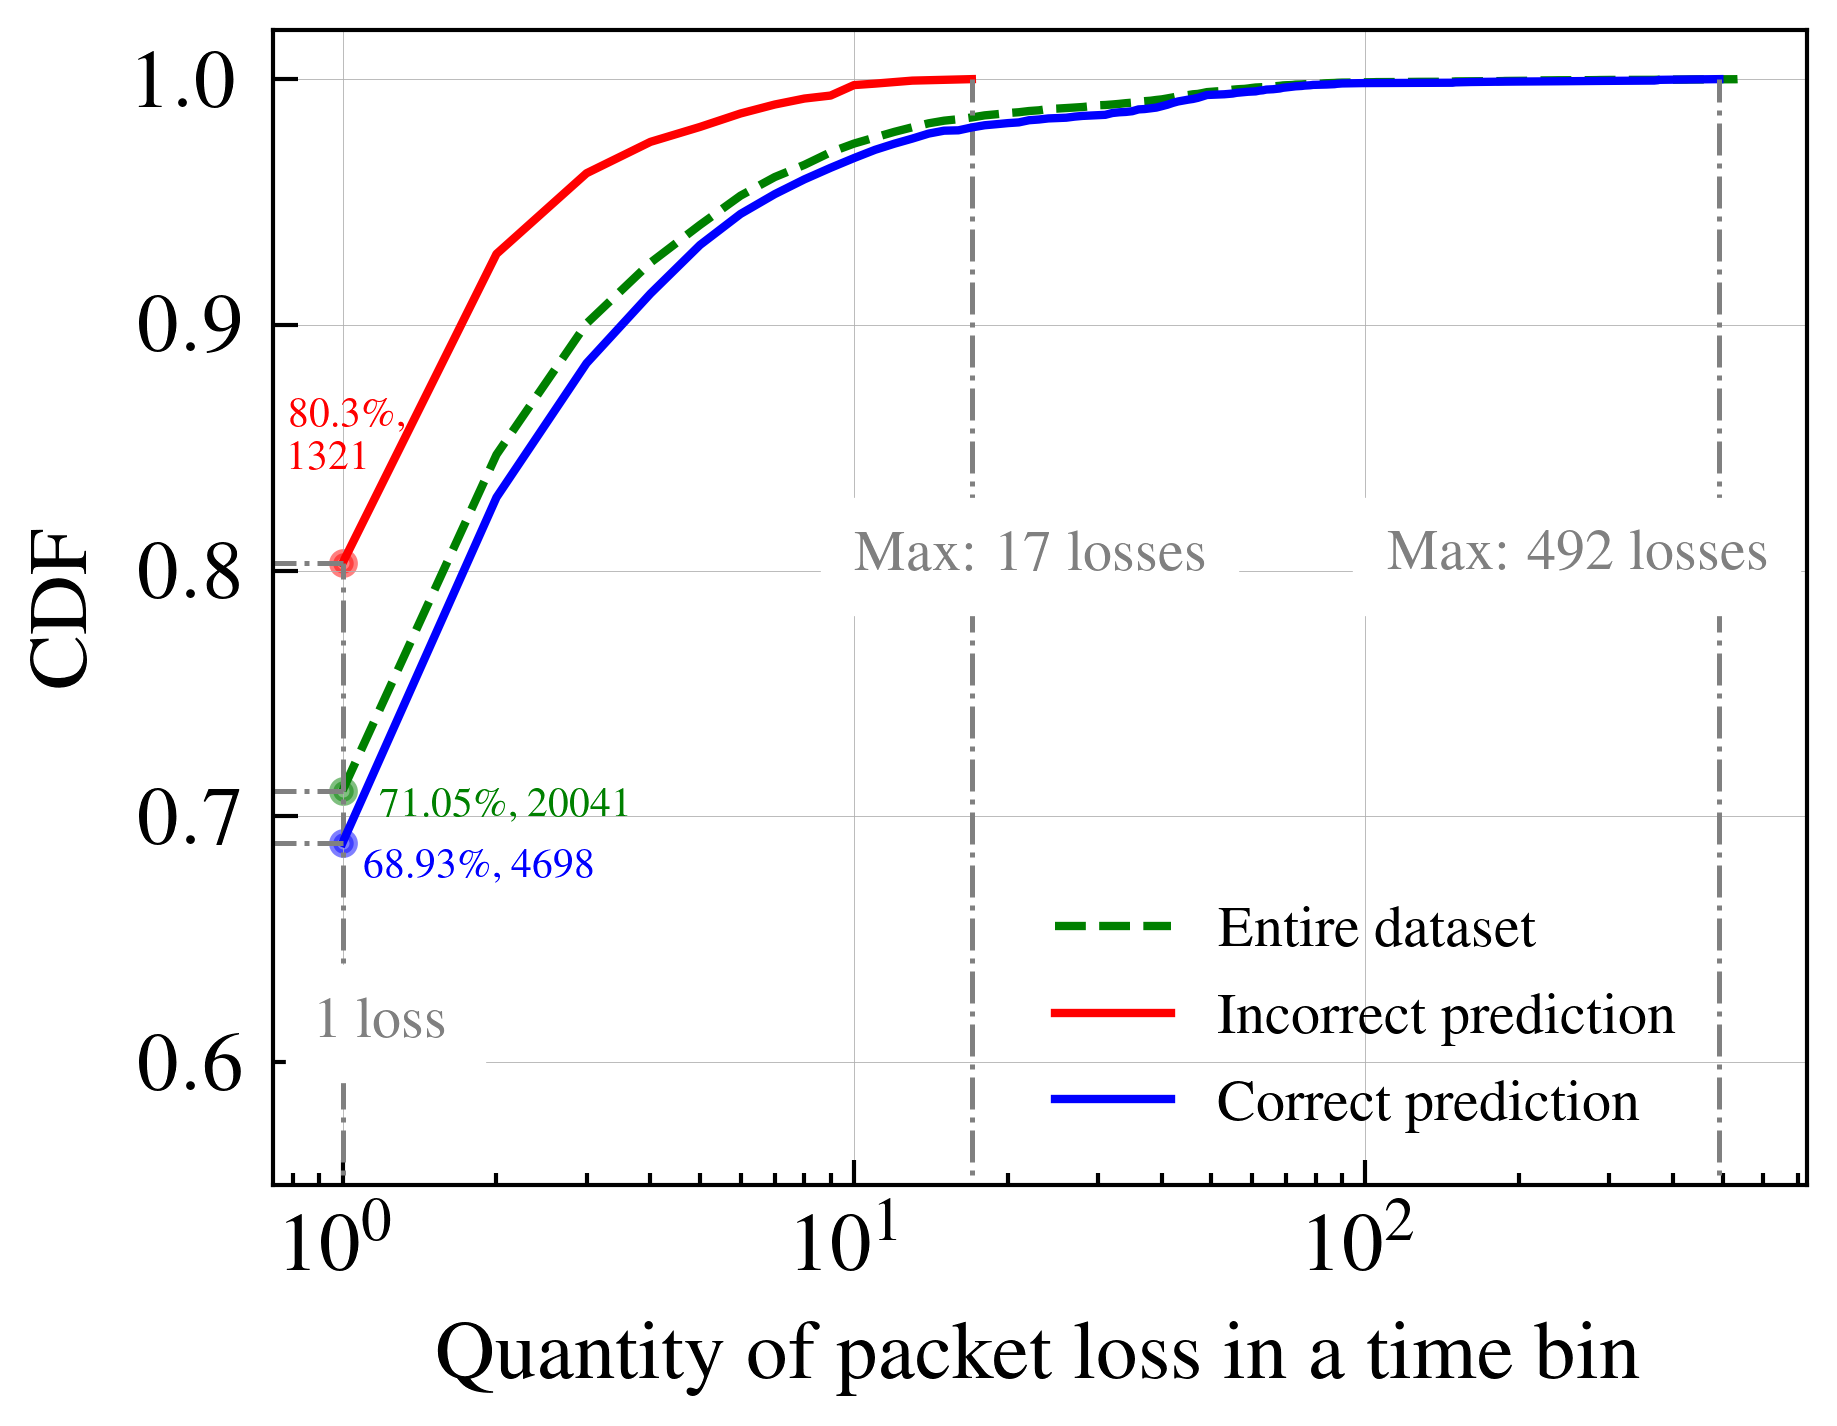

In [170]:
# data_loss_incorrect = pd.DataFrame(df_check_incorrect_pred.groupby('num_packet_loss').count()['lossOrNot'])
# data_loss_correct = pd.DataFrame(df_check_correct_pred.groupby('num_packet_loss').count()['lossOrNot'])
# data_loss_incorrect.to_csv('./plots_plus/loss_incorrect_pred.csv')
# data_loss_correct.to_csv('./plots_plus/loss_correct_pred.csv')

data_loss_incorrect = pd.read_csv('./plots_plus/loss_incorrect_pred.csv').set_index('num_packet_loss')
data_loss_correct = pd.read_csv('./plots_plus/loss_correct_pred.csv').set_index('num_packet_loss')

data_loss = pd.DataFrame(df_complete_with_features_final[df_complete_with_features_final['num_packet_loss'] != 0]['num_packet_loss'])
data_loss = data_loss.sort_values(by=['num_packet_loss'])
data_loss['count'] = data_loss['num_packet_loss']
data_loss = data_loss.groupby('num_packet_loss').count()

# with plt.style.context('ieee'):
plt.figure()

# entire dataset
cdf_loss = []
sum_loss = data_loss['count'].sum()
total = 0
for count in data_loss['count']:
    total += count
    cdf_loss.append(total / sum_loss)

plt.plot(data_loss.index, cdf_loss, '--', color='g', label='Entire dataset')
# sns.lineplot(data_loss.index, cdf_loss)
plt.scatter(1, cdf_loss[0], color='g', s=6, alpha=0.5)
plt.plot([0, 1], [cdf_loss[0], cdf_loss[0]], color='grey', linestyle='-.', linewidth=0.6)
plt.annotate(f'{round(cdf_loss[0]*100, 2)}\%, 20041', (1.18, 0.7), color='g', fontsize=5)

# incorrect prediction
cdf_loss = []
sum_loss = data_loss_incorrect['lossOrNot'].sum()
total = 0
for count in data_loss_incorrect['lossOrNot']:
    total += count
    cdf_loss.append(total / sum_loss)
plt.plot(data_loss_incorrect.index, cdf_loss, color='r', label='Incorrect prediction')
plt.plot([1, 1], [0, cdf_loss[0]], color='grey', linestyle='-.', linewidth=0.6)
plt.scatter(1, cdf_loss[0], color='r', s=6, alpha=0.5)
plt.plot([0, 1], [cdf_loss[0], cdf_loss[0]], color='grey', linestyle='-.', linewidth=0.6)
plt.annotate(f'{round(cdf_loss[0]*100, 2)}\%,\n1321', (0.79, 0.841), color='r', fontsize=5)
plt.plot([data_loss_incorrect.index[-1], data_loss_incorrect.index[-1]], [0, 1], color='grey', linestyle='-.', linewidth=0.6)
plt.annotate(f'Max: {data_loss_incorrect.index[-1]} losses', (10, 0.8), color='grey', backgroundcolor="w", fontsize=7)

# correct prediction
cdf_loss = []
sum_loss = data_loss_correct['lossOrNot'].sum()
total = 0
for count in data_loss_correct['lossOrNot']:
    total += count
    cdf_loss.append(total / sum_loss)
plt.plot(data_loss_correct.index, cdf_loss, '-', color='b', label='Correct prediction')
plt.scatter(1, cdf_loss[0], color='b', s=6, alpha=0.5)
plt.plot([0, 1], [cdf_loss[0], cdf_loss[0]], color='grey', linestyle='-.', linewidth=0.6)
plt.annotate(f'{round(cdf_loss[0]*100, 2)}\%, 4698', (1.1, 0.675), color='b', fontsize=5)
plt.plot([data_loss_correct.index[-1], data_loss_correct.index[-1]], [0, 1], color='grey', linestyle='-.', linewidth=0.6)
plt.annotate(f'Max: {data_loss_correct.index[-1]} losses', (110, 0.8), color='grey', backgroundcolor="w", fontsize=7)

plt.xscale('log')
plt.ylim(0.55, 1.02)
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(linewidth=0.1)
plt.xlabel('Quantity of packet loss in a time bin', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.gca().tick_params(labelsize=10)
plt.legend(loc=4, bbox_to_anchor=(0.95,0), fontsize=7)
plt.annotate('1 loss', (0.9, 0.61), color='grey', backgroundcolor="w", fontsize=7)

plt.savefig('./plots_plus/cdf_loss_correctOrIncorrect_pred.pdf')

plt.show()

#### Final results for constraints and optimizations

In [34]:
# reproduce the results for balanced random forest

import random

complete_list = ['timestamp', 'lossOrNot', 'flow_id', 'num_packet_loss']
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]
complete_list.extend(selected_features_list_removing_correlation)

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)
        
df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()
shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

Prediction Report of trial 1
               precision    recall  f1-score   support

           0       0.99      0.69      0.82    600134
           1       0.02      0.35      0.03      8461

    accuracy                           0.69    608595
   macro avg       0.50      0.52      0.42    608595
weighted avg       0.97      0.69      0.80    608595



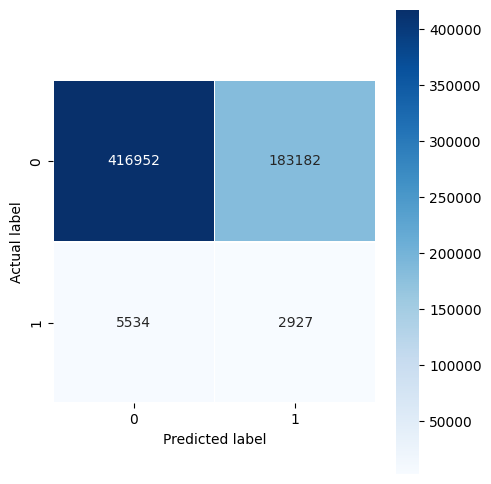

Prediction Report of trial 2
               precision    recall  f1-score   support

           0       0.99      0.58      0.73    600134
           1       0.02      0.56      0.04      8461

    accuracy                           0.58    608595
   macro avg       0.50      0.57      0.39    608595
weighted avg       0.98      0.58      0.73    608595



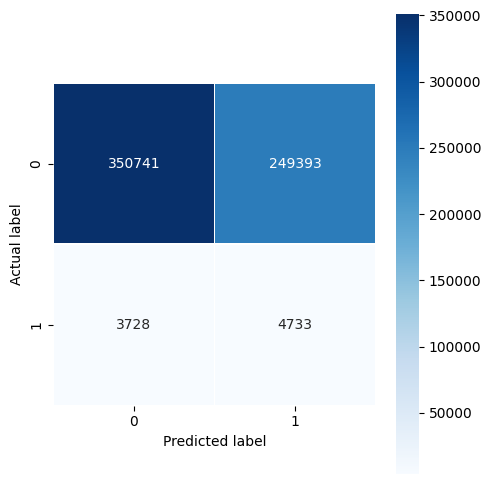

Prediction Report of trial 3
               precision    recall  f1-score   support

           0       0.99      0.62      0.76    600134
           1       0.02      0.44      0.03      8461

    accuracy                           0.62    608595
   macro avg       0.50      0.53      0.40    608595
weighted avg       0.97      0.62      0.75    608595



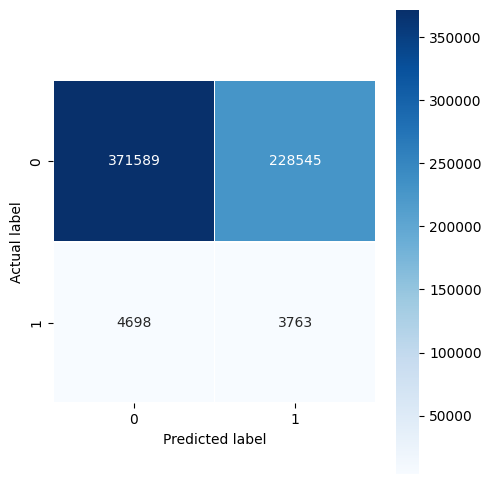

Prediction Report of trial 4
               precision    recall  f1-score   support

           0       0.99      0.69      0.81    600134
           1       0.02      0.36      0.03      8461

    accuracy                           0.68    608595
   macro avg       0.50      0.53      0.42    608595
weighted avg       0.97      0.68      0.80    608595



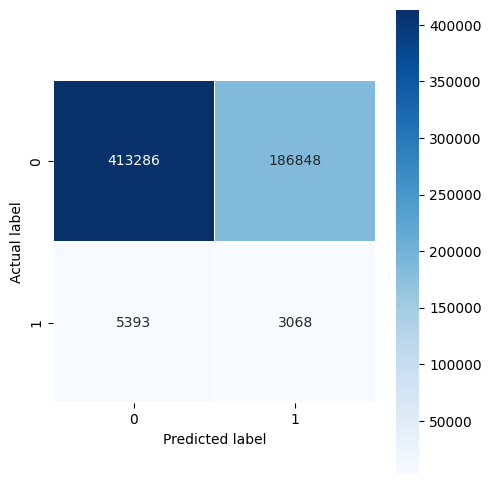

Prediction Report of trial 5
               precision    recall  f1-score   support

           0       0.99      0.63      0.77    600134
           1       0.02      0.47      0.03      8461

    accuracy                           0.63    608595
   macro avg       0.50      0.55      0.40    608595
weighted avg       0.97      0.63      0.76    608595



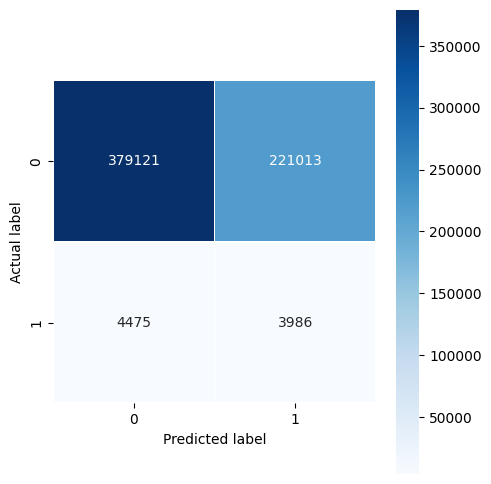

Prediction Report of trial 6
               precision    recall  f1-score   support

           0       0.98      0.61      0.75    600134
           1       0.01      0.32      0.02      8461

    accuracy                           0.61    608595
   macro avg       0.50      0.46      0.39    608595
weighted avg       0.97      0.61      0.74    608595



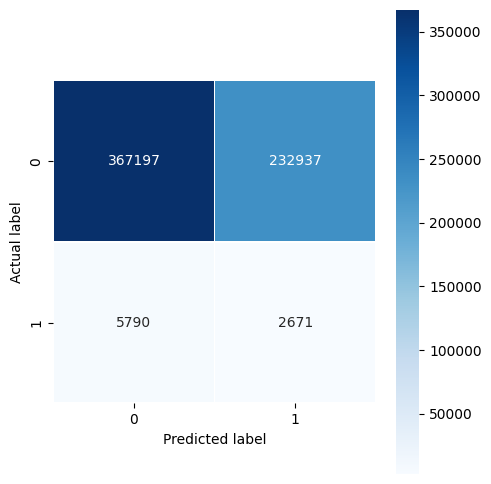

Prediction Report of trial 7
               precision    recall  f1-score   support

           0       0.99      0.68      0.80    600134
           1       0.02      0.42      0.03      8461

    accuracy                           0.67    608595
   macro avg       0.50      0.55      0.42    608595
weighted avg       0.97      0.67      0.79    608595



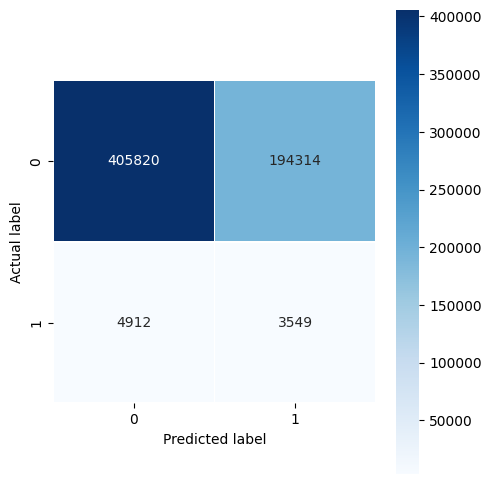

Prediction Report of trial 8
               precision    recall  f1-score   support

           0       0.99      0.64      0.78    600134
           1       0.02      0.51      0.04      8461

    accuracy                           0.64    608595
   macro avg       0.50      0.58      0.41    608595
weighted avg       0.98      0.64      0.77    608595



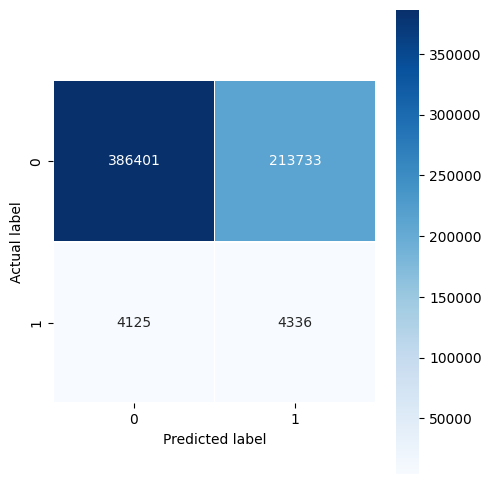

Prediction Report of trial 9
               precision    recall  f1-score   support

           0       0.99      0.63      0.77    600134
           1       0.01      0.40      0.03      8461

    accuracy                           0.63    608595
   macro avg       0.50      0.51      0.40    608595
weighted avg       0.97      0.63      0.76    608595



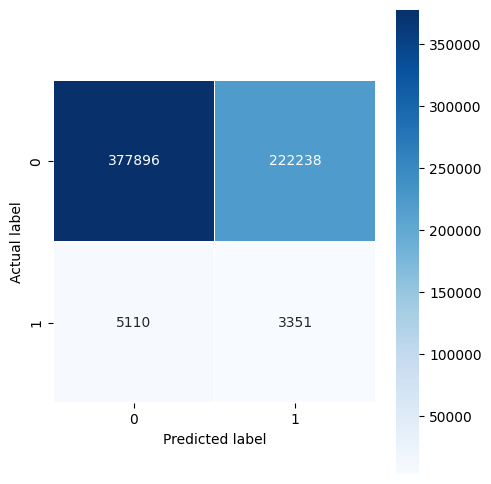

Prediction Report of trial 10
               precision    recall  f1-score   support

           0       0.99      0.62      0.76    600134
           1       0.02      0.57      0.04      8461

    accuracy                           0.62    608595
   macro avg       0.51      0.59      0.40    608595
weighted avg       0.98      0.62      0.75    608595



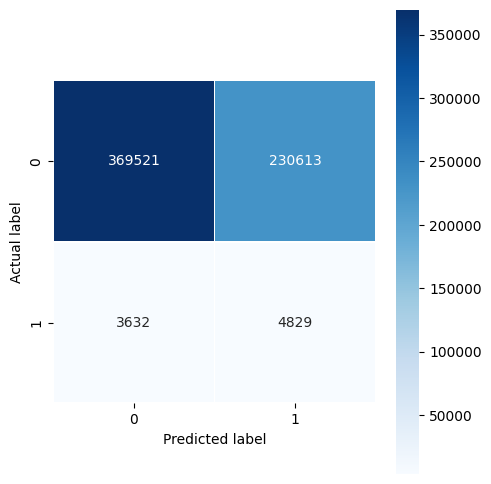

Prediction Report of trial 11
               precision    recall  f1-score   support

           0       0.99      0.73      0.84    600134
           1       0.02      0.31      0.03      8461

    accuracy                           0.73    608595
   macro avg       0.50      0.52      0.44    608595
weighted avg       0.97      0.73      0.83    608595



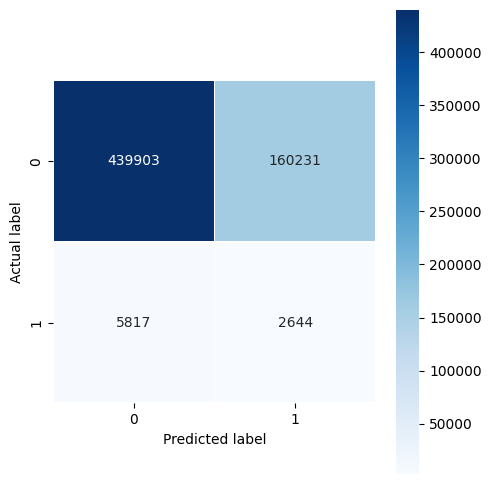

Prediction Report of trial 12
               precision    recall  f1-score   support

           0       0.99      0.69      0.82    600134
           1       0.01      0.30      0.03      8461

    accuracy                           0.69    608595
   macro avg       0.50      0.50      0.42    608595
weighted avg       0.97      0.69      0.80    608595



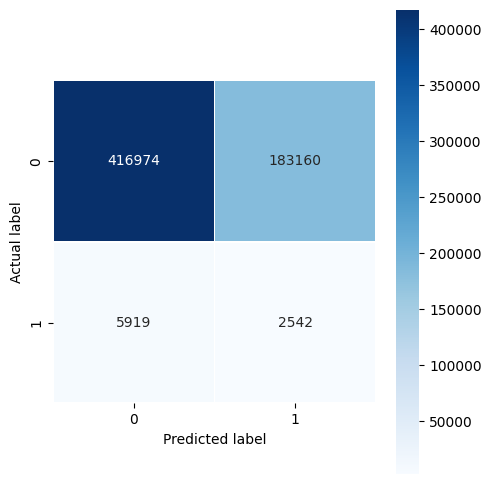

Prediction Report of trial 13
               precision    recall  f1-score   support

           0       0.99      0.72      0.83    600134
           1       0.02      0.43      0.04      8461

    accuracy                           0.71    608595
   macro avg       0.50      0.57      0.43    608595
weighted avg       0.98      0.71      0.82    608595



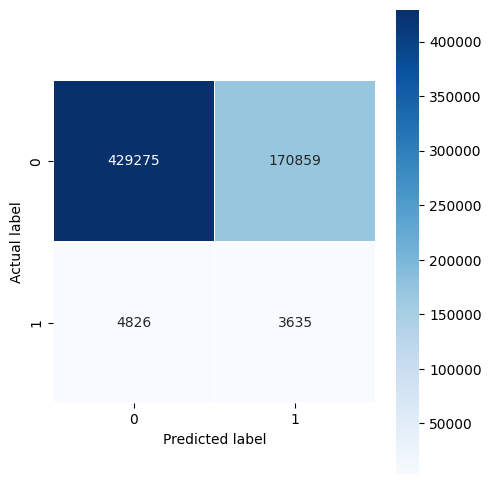

Prediction Report of trial 14
               precision    recall  f1-score   support

           0       0.99      0.64      0.77    600134
           1       0.02      0.48      0.04      8461

    accuracy                           0.63    608595
   macro avg       0.50      0.56      0.40    608595
weighted avg       0.98      0.63      0.76    608595



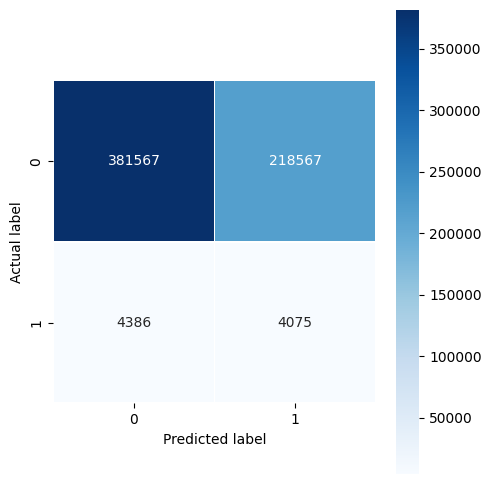

Prediction Report of trial 15
               precision    recall  f1-score   support

           0       0.99      0.69      0.81    600134
           1       0.01      0.33      0.03      8461

    accuracy                           0.68    608595
   macro avg       0.50      0.51      0.42    608595
weighted avg       0.97      0.68      0.80    608595



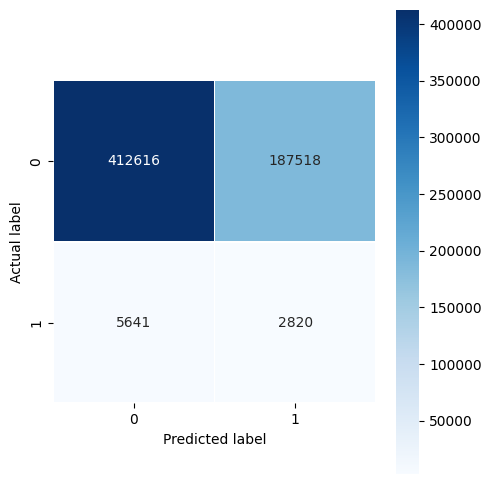

Prediction Report of trial 16
               precision    recall  f1-score   support

           0       0.99      0.66      0.79    600134
           1       0.01      0.35      0.03      8461

    accuracy                           0.65    608595
   macro avg       0.50      0.50      0.41    608595
weighted avg       0.97      0.65      0.78    608595



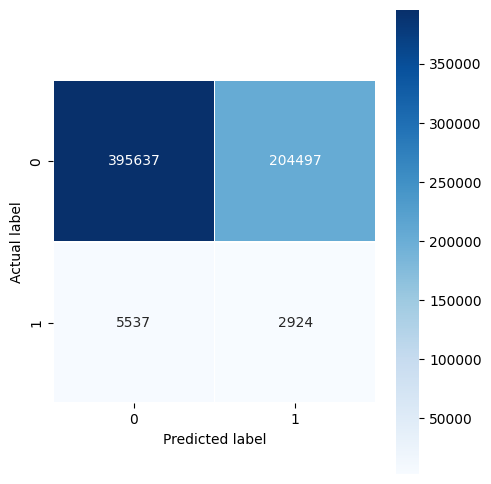

Prediction Report of trial 17
               precision    recall  f1-score   support

           0       0.99      0.67      0.80    600134
           1       0.02      0.37      0.03      8461

    accuracy                           0.66    608595
   macro avg       0.50      0.52      0.41    608595
weighted avg       0.97      0.66      0.79    608595



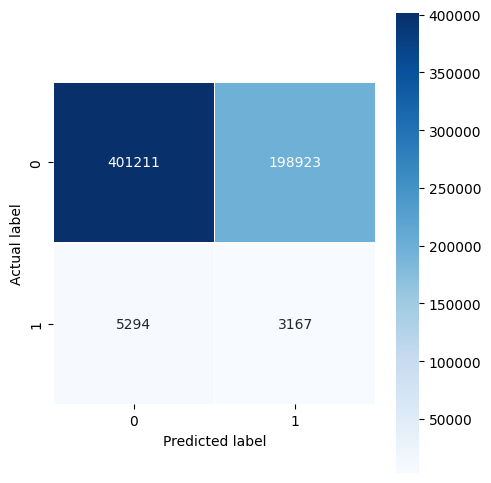

Prediction Report of trial 18
               precision    recall  f1-score   support

           0       0.99      0.64      0.78    600134
           1       0.02      0.48      0.04      8461

    accuracy                           0.64    608595
   macro avg       0.50      0.56      0.41    608595
weighted avg       0.98      0.64      0.77    608595



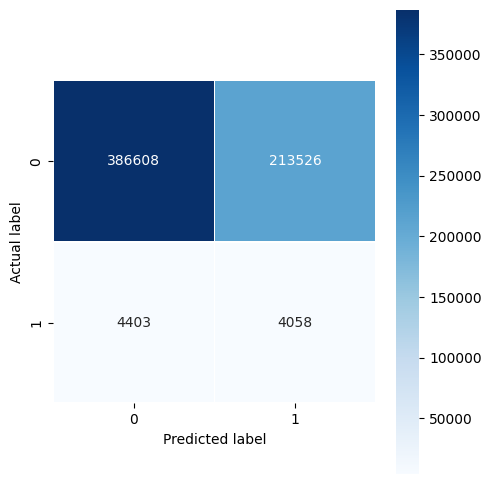

Prediction Report of trial 19
               precision    recall  f1-score   support

           0       0.99      0.63      0.77    600134
           1       0.02      0.40      0.03      8461

    accuracy                           0.63    608595
   macro avg       0.50      0.52      0.40    608595
weighted avg       0.97      0.63      0.76    608595



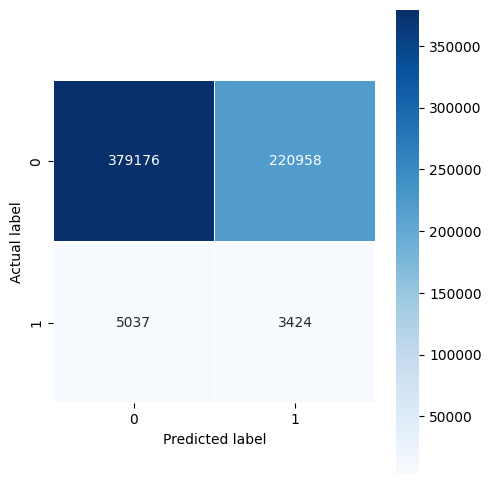

Prediction Report of trial 20
               precision    recall  f1-score   support

           0       0.99      0.74      0.85    600134
           1       0.02      0.35      0.04      8461

    accuracy                           0.73    608595
   macro avg       0.50      0.55      0.44    608595
weighted avg       0.97      0.73      0.83    608595



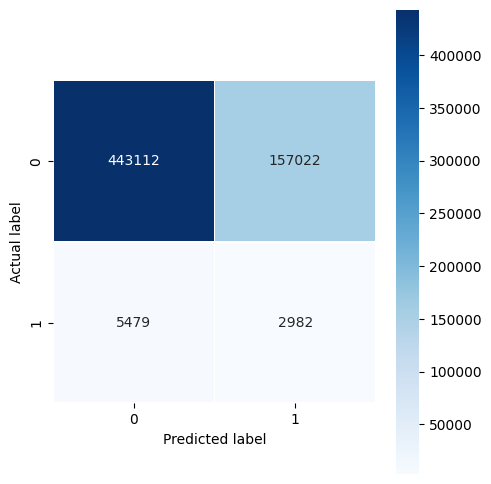

Prediction Report of trial 21
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    600134
           1       0.01      0.31      0.03      8461

    accuracy                           0.69    608595
   macro avg       0.50      0.50      0.42    608595
weighted avg       0.97      0.69      0.81    608595



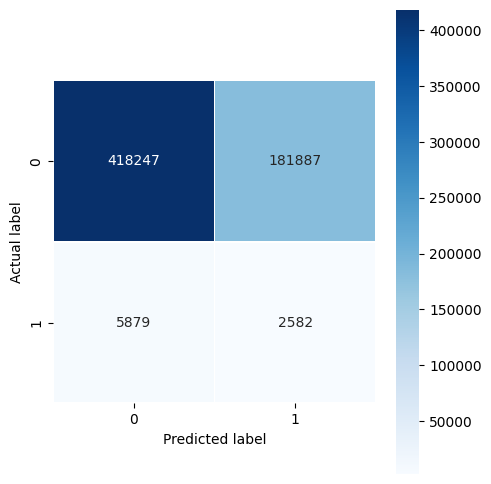

Prediction Report of trial 22
               precision    recall  f1-score   support

           0       0.99      0.69      0.81    600134
           1       0.02      0.37      0.03      8461

    accuracy                           0.68    608595
   macro avg       0.50      0.53      0.42    608595
weighted avg       0.97      0.68      0.80    608595



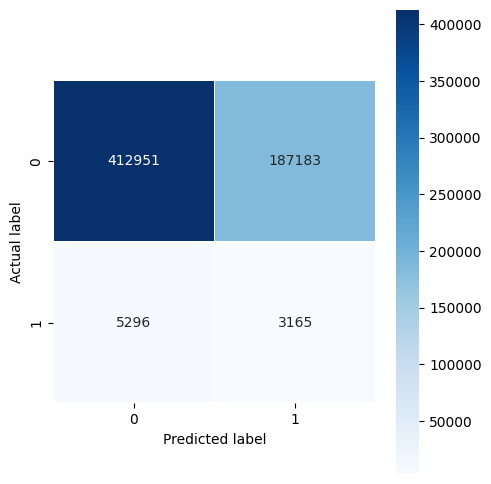

Prediction Report of trial 23
               precision    recall  f1-score   support

           0       0.99      0.63      0.77    600134
           1       0.02      0.48      0.03      8461

    accuracy                           0.63    608595
   macro avg       0.50      0.55      0.40    608595
weighted avg       0.97      0.63      0.76    608595



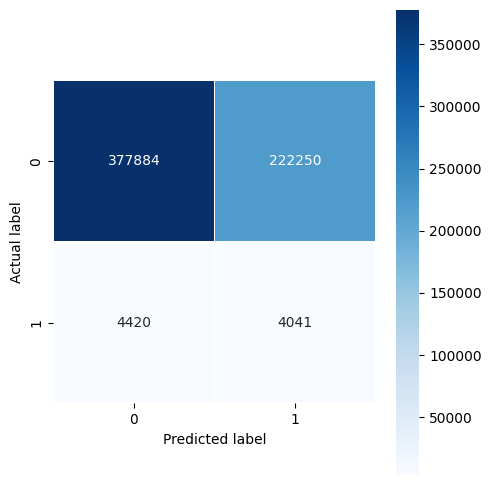

Prediction Report of trial 24
               precision    recall  f1-score   support

           0       0.99      0.75      0.85    600134
           1       0.02      0.40      0.04      8461

    accuracy                           0.74    608595
   macro avg       0.51      0.57      0.45    608595
weighted avg       0.98      0.74      0.84    608595



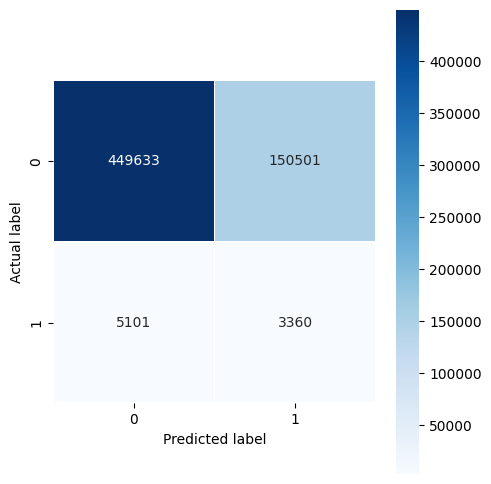

Prediction Report of trial 25
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    600134
           1       0.02      0.36      0.03      8461

    accuracy                           0.69    608595
   macro avg       0.50      0.53      0.42    608595
weighted avg       0.97      0.69      0.81    608595



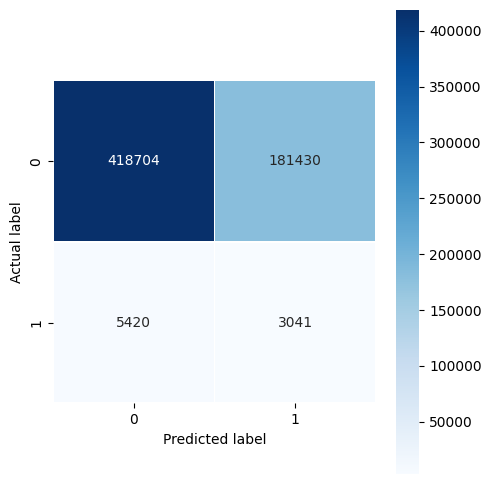

Prediction Report of trial 26
               precision    recall  f1-score   support

           0       0.99      0.68      0.80    600134
           1       0.01      0.32      0.03      8461

    accuracy                           0.67    608595
   macro avg       0.50      0.50      0.41    608595
weighted avg       0.97      0.67      0.79    608595



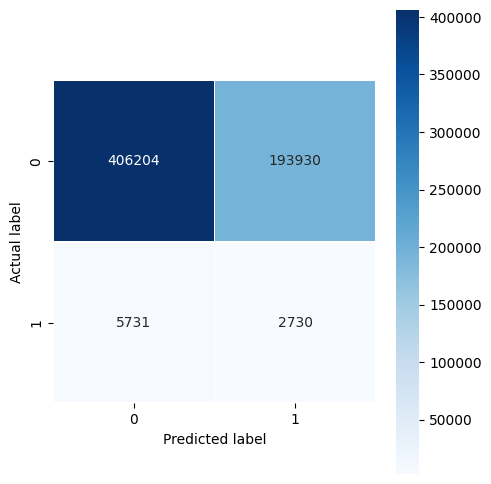

Prediction Report of trial 27
               precision    recall  f1-score   support

           0       0.99      0.66      0.79    600134
           1       0.01      0.33      0.03      8461

    accuracy                           0.66    608595
   macro avg       0.50      0.50      0.41    608595
weighted avg       0.97      0.66      0.78    608595



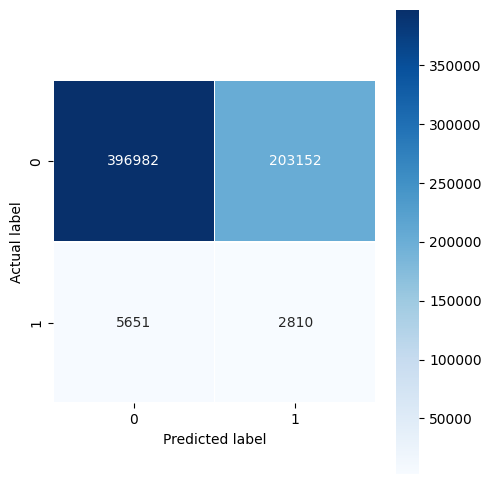

Prediction Report of trial 28
               precision    recall  f1-score   support

           0       0.99      0.69      0.81    600134
           1       0.01      0.31      0.03      8461

    accuracy                           0.69    608595
   macro avg       0.50      0.50      0.42    608595
weighted avg       0.97      0.69      0.80    608595



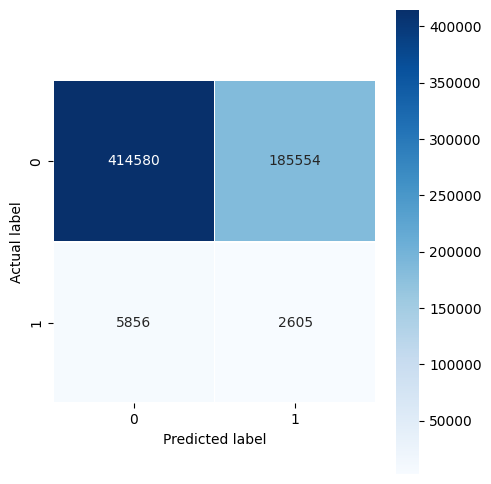

Prediction Report of trial 29
               precision    recall  f1-score   support

           0       0.99      0.69      0.82    600134
           1       0.01      0.30      0.03      8461

    accuracy                           0.69    608595
   macro avg       0.50      0.50      0.42    608595
weighted avg       0.97      0.69      0.80    608595



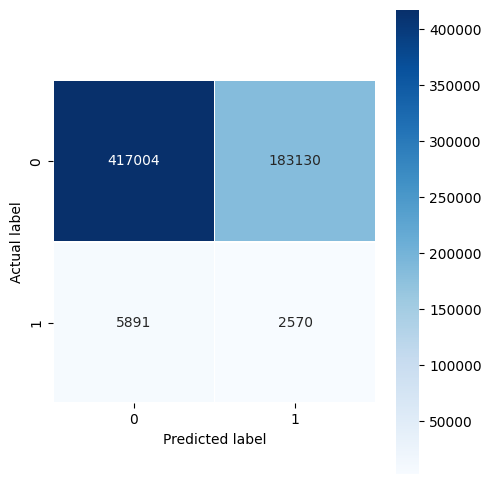

Prediction Report of trial 30
               precision    recall  f1-score   support

           0       0.99      0.72      0.83    600134
           1       0.02      0.40      0.04      8461

    accuracy                           0.71    608595
   macro avg       0.50      0.56      0.43    608595
weighted avg       0.97      0.71      0.82    608595



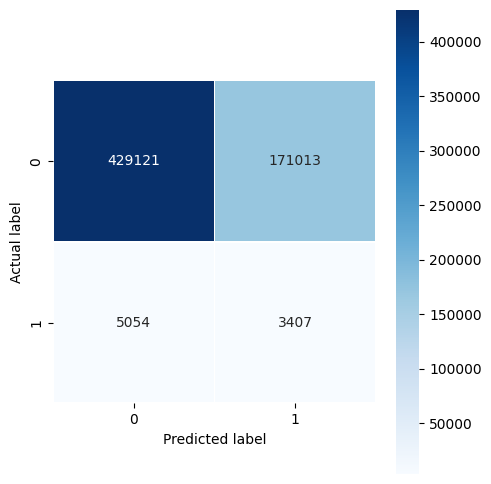

Prediction Report of trial 31
               precision    recall  f1-score   support

           0       0.99      0.58      0.73    600134
           1       0.02      0.53      0.03      8461

    accuracy                           0.58    608595
   macro avg       0.50      0.55      0.38    608595
weighted avg       0.98      0.58      0.72    608595



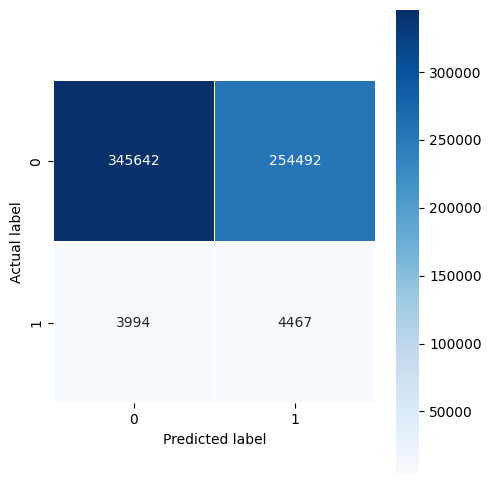

Prediction Report of trial 32
               precision    recall  f1-score   support

           0       0.99      0.65      0.78    600134
           1       0.02      0.44      0.03      8461

    accuracy                           0.64    608595
   macro avg       0.50      0.55      0.41    608595
weighted avg       0.97      0.64      0.77    608595



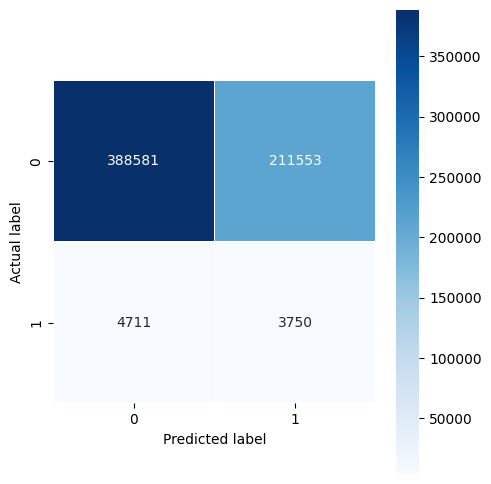

Prediction Report of trial 33
               precision    recall  f1-score   support

           0       0.99      0.62      0.76    600134
           1       0.02      0.59      0.04      8461

    accuracy                           0.62    608595
   macro avg       0.51      0.60      0.40    608595
weighted avg       0.98      0.62      0.75    608595



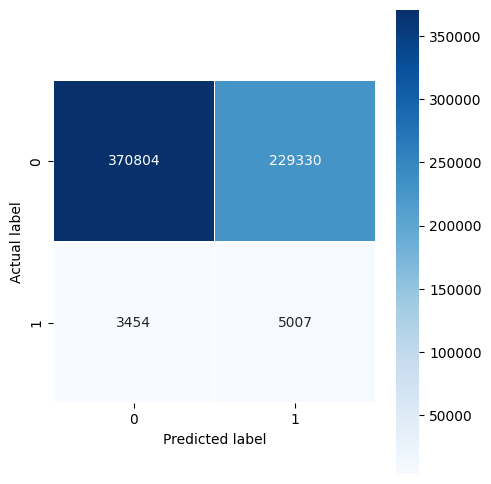

Prediction Report of trial 34
               precision    recall  f1-score   support

           0       0.99      0.58      0.73    600134
           1       0.02      0.49      0.03      8461

    accuracy                           0.58    608595
   macro avg       0.50      0.54      0.38    608595
weighted avg       0.97      0.58      0.72    608595



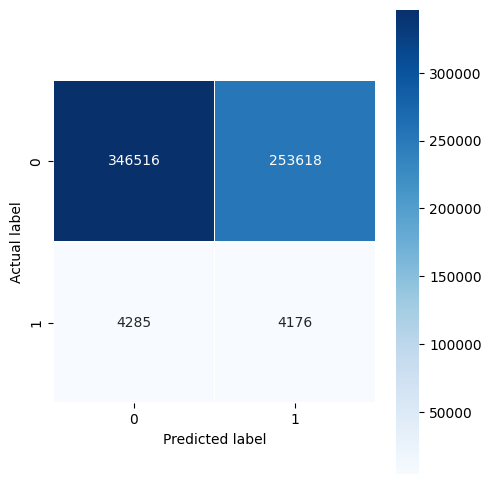

Prediction Report of trial 35
               precision    recall  f1-score   support

           0       0.99      0.56      0.72    600134
           1       0.02      0.62      0.04      8461

    accuracy                           0.56    608595
   macro avg       0.51      0.59      0.38    608595
weighted avg       0.98      0.56      0.71    608595



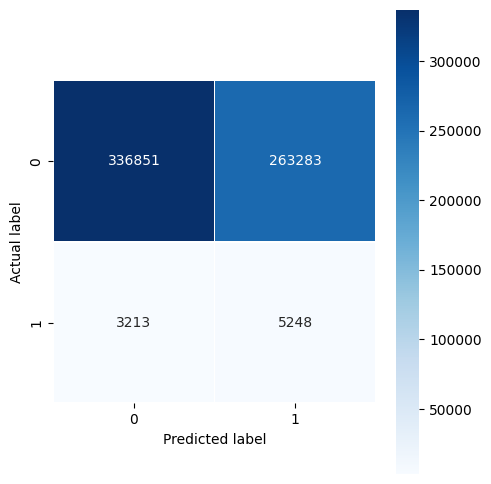

Prediction Report of trial 36
               precision    recall  f1-score   support

           0       0.99      0.57      0.72    600134
           1       0.02      0.53      0.03      8461

    accuracy                           0.57    608595
   macro avg       0.50      0.55      0.38    608595
weighted avg       0.97      0.57      0.71    608595



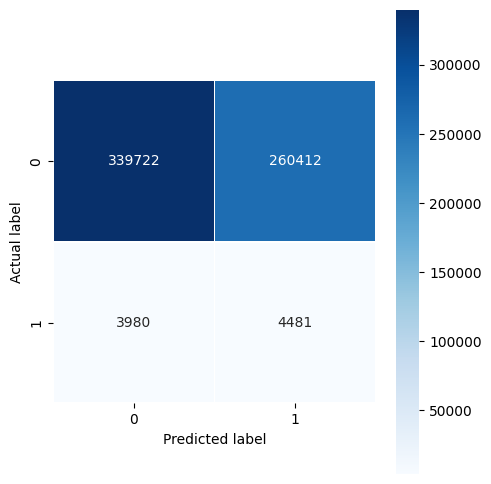

Prediction Report of trial 37
               precision    recall  f1-score   support

           0       0.99      0.62      0.76    600134
           1       0.02      0.45      0.03      8461

    accuracy                           0.61    608595
   macro avg       0.50      0.53      0.39    608595
weighted avg       0.97      0.61      0.75    608595



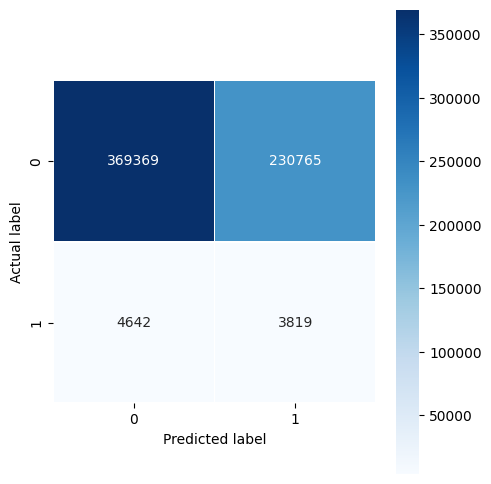

Prediction Report of trial 38
               precision    recall  f1-score   support

           0       0.99      0.64      0.77    600134
           1       0.01      0.32      0.02      8461

    accuracy                           0.63    608595
   macro avg       0.50      0.48      0.40    608595
weighted avg       0.97      0.63      0.76    608595



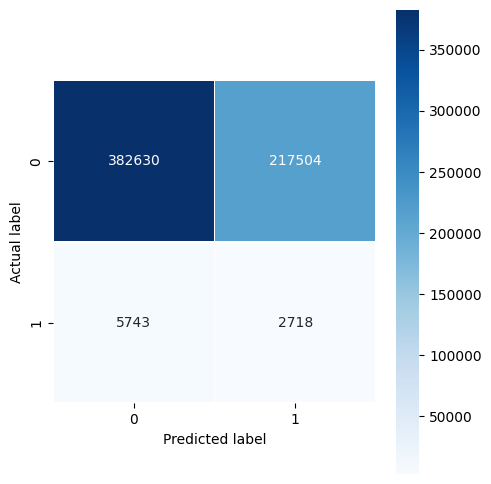

Prediction Report of trial 39
               precision    recall  f1-score   support

           0       0.99      0.66      0.79    600134
           1       0.02      0.37      0.03      8461

    accuracy                           0.66    608595
   macro avg       0.50      0.51      0.41    608595
weighted avg       0.97      0.66      0.78    608595



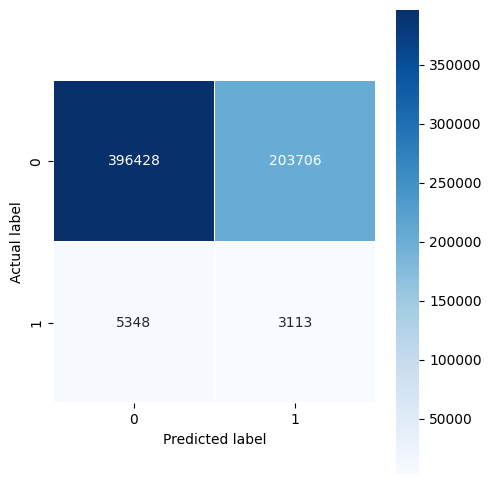

Prediction Report of trial 40
               precision    recall  f1-score   support

           0       0.99      0.65      0.78    600134
           1       0.02      0.47      0.04      8461

    accuracy                           0.64    608595
   macro avg       0.50      0.56      0.41    608595
weighted avg       0.98      0.64      0.77    608595



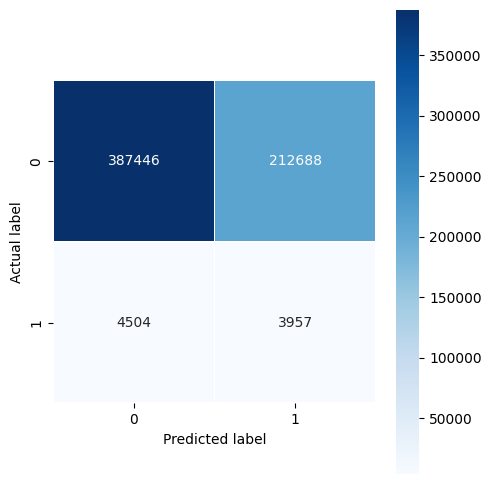

Prediction Report of trial 41
               precision    recall  f1-score   support

           0       0.99      0.65      0.78    600134
           1       0.01      0.36      0.03      8461

    accuracy                           0.64    608595
   macro avg       0.50      0.51      0.40    608595
weighted avg       0.97      0.64      0.77    608595



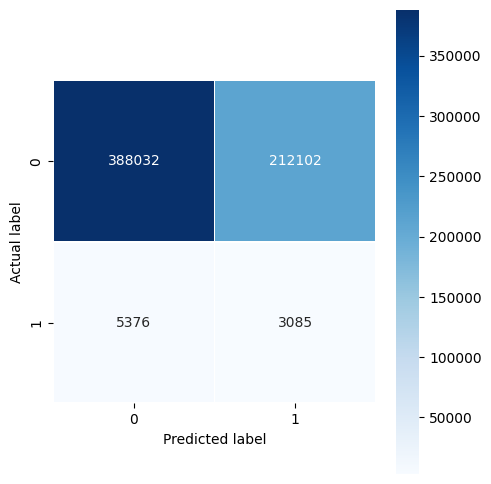

Prediction Report of trial 42
               precision    recall  f1-score   support

           0       0.99      0.62      0.76    600134
           1       0.02      0.50      0.04      8461

    accuracy                           0.62    608595
   macro avg       0.50      0.56      0.40    608595
weighted avg       0.98      0.62      0.75    608595



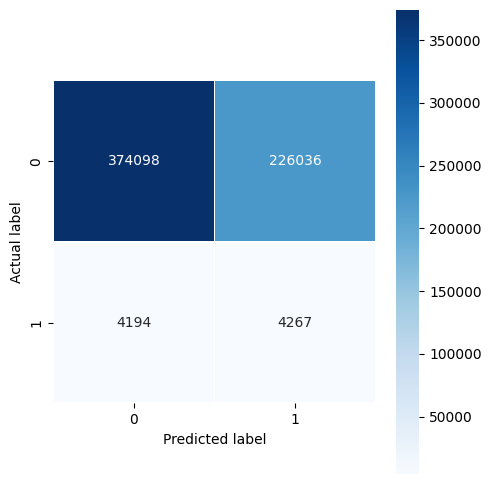

Prediction Report of trial 43
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    600134
           1       0.02      0.34      0.03      8461

    accuracy                           0.70    608595
   macro avg       0.50      0.52      0.43    608595
weighted avg       0.97      0.70      0.81    608595



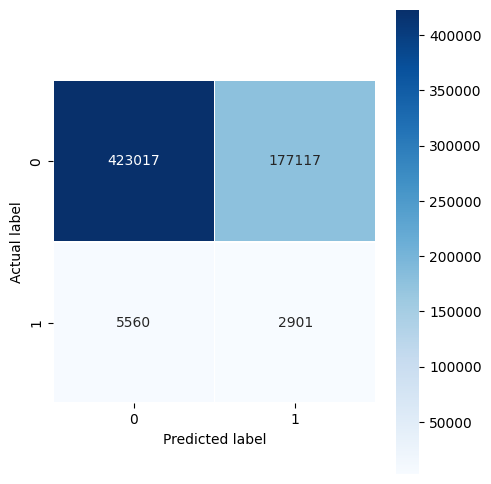

Prediction Report of trial 44
               precision    recall  f1-score   support

           0       0.99      0.64      0.77    600134
           1       0.02      0.41      0.03      8461

    accuracy                           0.63    608595
   macro avg       0.50      0.52      0.40    608595
weighted avg       0.97      0.63      0.76    608595



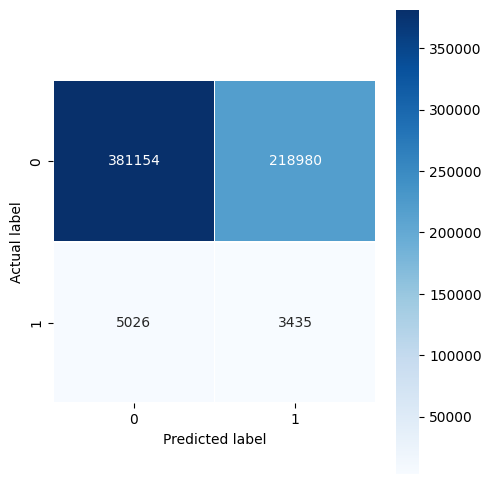

Prediction Report of trial 45
               precision    recall  f1-score   support

           0       0.99      0.67      0.80    600134
           1       0.01      0.34      0.03      8461

    accuracy                           0.66    608595
   macro avg       0.50      0.50      0.41    608595
weighted avg       0.97      0.66      0.79    608595



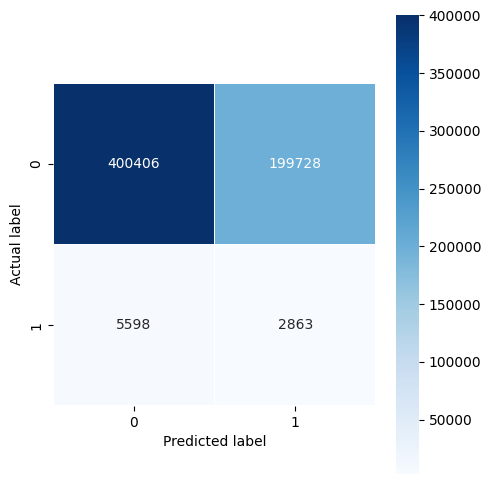

Prediction Report of trial 46
               precision    recall  f1-score   support

           0       0.99      0.66      0.79    600134
           1       0.02      0.50      0.04      8461

    accuracy                           0.66    608595
   macro avg       0.50      0.58      0.42    608595
weighted avg       0.98      0.66      0.78    608595



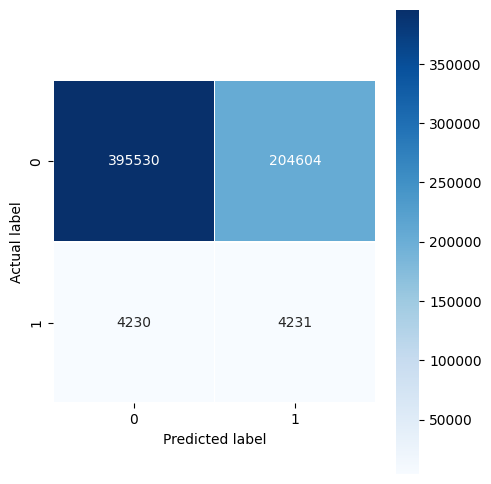

Prediction Report of trial 47
               precision    recall  f1-score   support

           0       0.99      0.67      0.80    600134
           1       0.01      0.33      0.03      8461

    accuracy                           0.67    608595
   macro avg       0.50      0.50      0.41    608595
weighted avg       0.97      0.67      0.79    608595



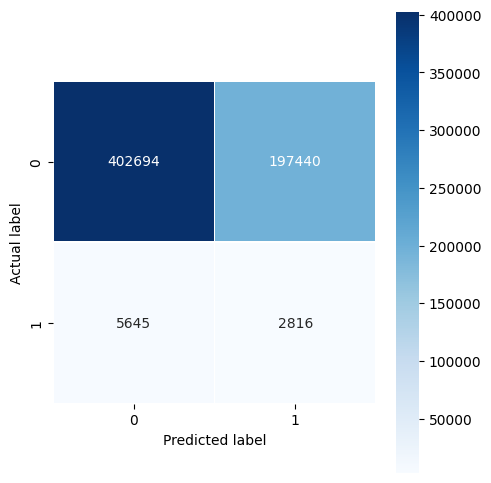

Prediction Report of trial 48
               precision    recall  f1-score   support

           0       0.99      0.66      0.79    600134
           1       0.02      0.40      0.03      8461

    accuracy                           0.66    608595
   macro avg       0.50      0.53      0.41    608595
weighted avg       0.97      0.66      0.78    608595



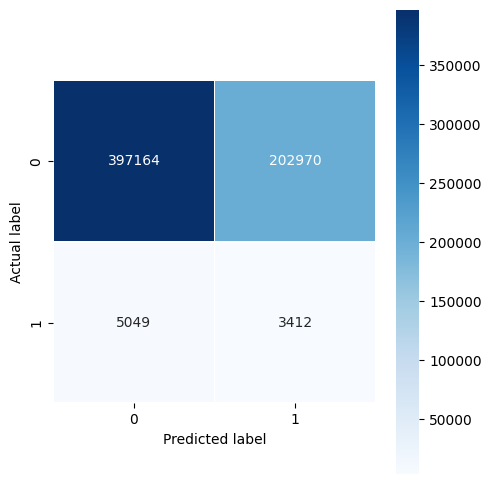

Prediction Report of trial 49
               precision    recall  f1-score   support

           0       0.99      0.65      0.79    600134
           1       0.02      0.40      0.03      8461

    accuracy                           0.65    608595
   macro avg       0.50      0.52      0.41    608595
weighted avg       0.97      0.65      0.78    608595



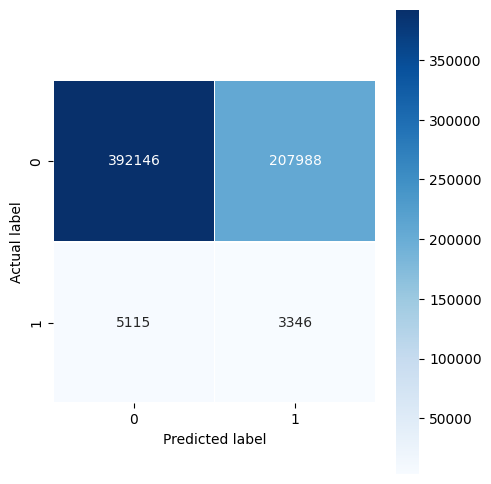

Prediction Report of trial 50
               precision    recall  f1-score   support

           0       0.99      0.63      0.77    600134
           1       0.02      0.55      0.04      8461

    accuracy                           0.63    608595
   macro avg       0.51      0.59      0.41    608595
weighted avg       0.98      0.63      0.76    608595



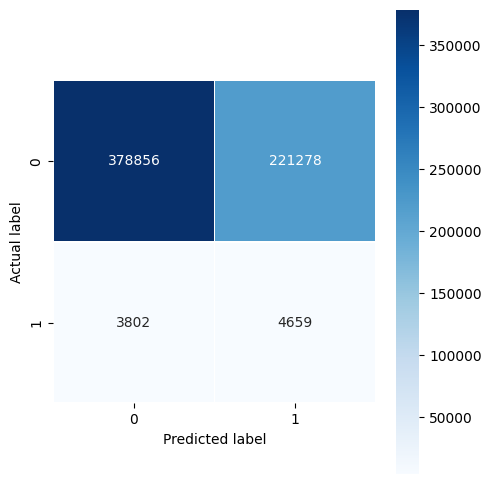

In [35]:
recall_0_list = []
recall_1_list = []
recall_avg_list = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list]
    x_test = df_test_shuffled[full_features_list]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    my_brf_model_check = BalancedRandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0) 
    my_brf_model_check.fit(x_train, y_train)
            
    y_pred = my_brf_model_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    with plt.style.context('default'):
        plt.figure(figsize=(5,5))
        sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list.append(report['0']['recall'])
    recall_1_list.append(report['1']['recall'])
    recall_avg_list.append(report['macro avg']['recall'])

In [36]:
print(recall_0_list)
print(recall_1_list)
print(recall_avg_list)

[0.694764835853326, 0.584437808889348, 0.6191767171998254, 0.6886562001153076, 0.6317272475813734, 0.6118583516348015, 0.6762156451725782, 0.6438578717419776, 0.629686036785118, 0.6157308201168405, 0.7330079615552526, 0.6948014943329323, 0.7152985833163926, 0.6358030039957743, 0.6875397827818454, 0.6592477679984804, 0.6685356936950748, 0.6442027947091816, 0.631818893780389, 0.7383551006941783, 0.6969226872665105, 0.6880979914485765, 0.6296660412507873, 0.7492210073083678, 0.6976841838656034, 0.6768555022711594, 0.6614889341380426, 0.6908123852339644, 0.694851483168759, 0.7150419739591491, 0.5759413730933425, 0.6474903938120486, 0.6178686759956943, 0.577397714510426, 0.5612929779016019, 0.5660769094902138, 0.6154775433486521, 0.6375742750785658, 0.6605658069697767, 0.6455991495232731, 0.6465755981164206, 0.6233574501694622, 0.7048709121629503, 0.6351148243558938, 0.6671943266003926, 0.6590694744840319, 0.6710068084794396, 0.6617921997420576, 0.653430733802784, 0.6312856795315713]
[0.345

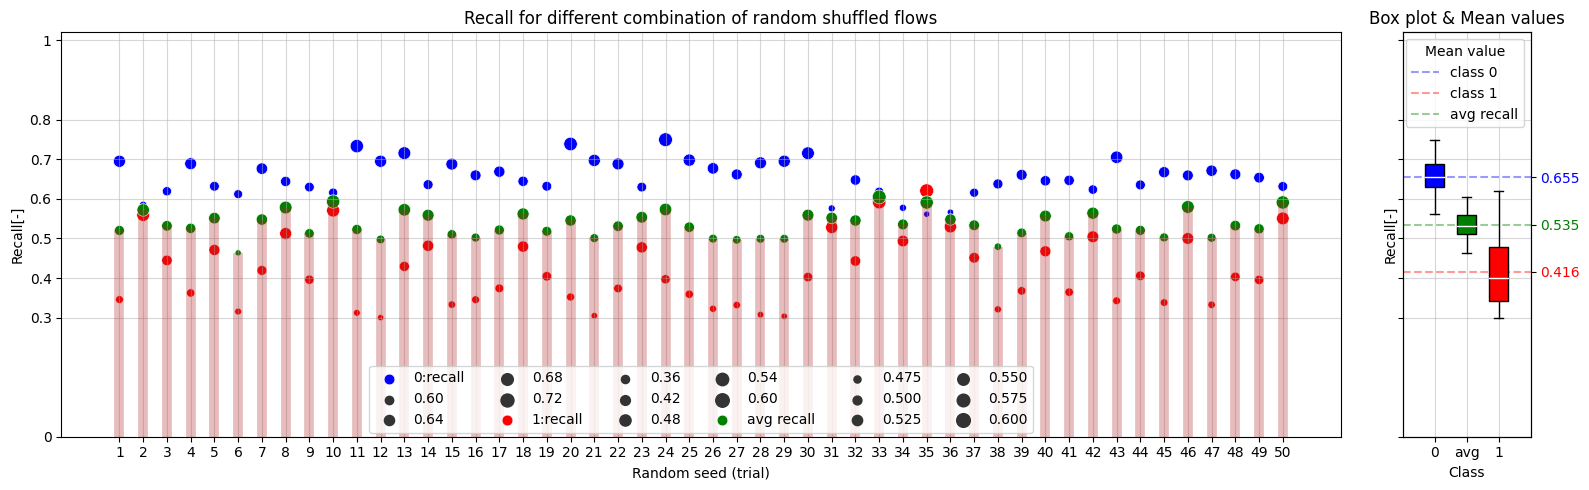

In [39]:
x_label = list(range(1,51))
with plt.style.context('default'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), sharey=True, gridspec_kw={'width_ratios': [10, 1]})

    sns.scatterplot(x=x_label, y=recall_0_list, label='0:recall', size=recall_0_list, sizes=(20, 100), color='b', ax=ax1)
    sns.scatterplot(x=x_label, y=recall_1_list, label='1:recall', size=recall_1_list, sizes=(20, 100), color='r', ax=ax1)
    sns.scatterplot(x=x_label, y=recall_avg_list, label='avg recall', size=recall_avg_list, sizes=(20, 100), color='g', ax=ax1)
    ax1.vlines(x=x_label, ymin=0, ymax=recall_avg_list, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
    ax1.set_xticks(x_label)
    ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=6)
    ax1.grid(alpha=0.5)
    plt.ylim([0,1.02])
    plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
    ax1.set_xlabel('Random seed (trial)')
    ax1.set_ylabel('Recall[-]')
    ax1.set_title('Recall for different combination of random shuffled flows')

    box = ax2.boxplot([recall_0_list, recall_1_list, recall_avg_list], positions=[1, 2, 1.5], widths=0.3, patch_artist=True) # meanline=True, showmeans=True
    ax2.set_title('Box plot & Mean values')
    ax2.set_xticks([1, 2, 1.5])
    ax2.set_xticklabels(['0', '1', 'avg'])
    ax2.set_xlabel('Class')
    ax2.grid(alpha=0.5)
    ax2.set_ylabel('Recall[-]')
    # ax2.yaxis.set_label_position("right")
    colors = ['blue', 'red', 'green']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    for median in box['medians']:
        median.set_color('white')
    ax2.axhline(y=0.655, color='b', linestyle='--', alpha=0.4, label='class 0')
    ax2.axhline(y=0.416, color='r', linestyle='--', alpha=0.4, label='class 1')
    ax2.axhline(y=0.535, color='g', linestyle='--', alpha=0.4, label='avg recall')
    ax2.legend(title='Mean value')
    ax3 = ax2.twinx()
    ax3.set_yticks([0.655, 0.416, 0.535])
    ax3.set_ylim([0,1.02])
    ax3.get_yticklabels()[0].set_color("b")
    ax3.get_yticklabels()[1].set_color("r")
    ax3.get_yticklabels()[2].set_color("g")

    plt.tight_layout()
    plt.show()

In [136]:
# constraint due to flow shuffling 

recalls_brf = {
    'recall_0': [0.694764835853326, 0.584437808889348, 0.6191767171998254, 0.6886562001153076, 0.6317272475813734, 0.6118583516348015, 0.6762156451725782, 0.6438578717419776, 0.629686036785118, 0.6157308201168405, 0.7330079615552526, 0.6948014943329323, 0.7152985833163926, 0.6358030039957743, 0.6875397827818454, 0.6592477679984804, 0.6685356936950748, 0.6442027947091816, 0.631818893780389, 0.7383551006941783, 0.6969226872665105, 0.6880979914485765, 0.6296660412507873, 0.7492210073083678, 0.6976841838656034, 0.6768555022711594, 0.6614889341380426, 0.6908123852339644, 0.694851483168759, 0.7150419739591491, 0.5759413730933425, 0.6474903938120486, 0.6178686759956943, 0.577397714510426, 0.5612929779016019, 0.5660769094902138, 0.6154775433486521, 0.6375742750785658, 0.6605658069697767, 0.6455991495232731, 0.6465755981164206, 0.6233574501694622, 0.7048709121629503, 0.6351148243558938, 0.6671943266003926, 0.6590694744840319, 0.6710068084794396, 0.6617921997420576, 0.653430733802784, 0.6312856795315713],
    'recall_1': [0.3459401961943033, 0.5593901430091006, 0.4447464838671552, 0.3626048930386479, 0.47110270653587044, 0.3156837253279754, 0.41945396525233425, 0.512468975298428, 0.3960524760666588, 0.5707363195839735, 0.3124926131662924, 0.3004373005554899, 0.42961824843399127, 0.48162155773549226, 0.3332939368868928, 0.3455856281763385, 0.37430563763148567, 0.47961233896702515, 0.4046802978371351, 0.3524406098569909, 0.30516487412835364, 0.37406925895284243, 0.4776031201985581, 0.3971161801205531, 0.3594137808769649, 0.3226568963479494, 0.33211204349367685, 0.3078832289327503, 0.3037466020564945, 0.402671079068668, 0.5279517787495568, 0.44321002245597446, 0.5917740219832172, 0.49355868100697314, 0.6202576527597211, 0.5296064295000591, 0.4513650868691644, 0.3212386242760903, 0.3679234133081196, 0.46767521569554427, 0.364614111807115, 0.5043139108852381, 0.34286727337194184, 0.4059803805696726, 0.33837607847772133, 0.5000590946696608, 0.33282117952960644, 0.403262025765276, 0.3954615293700508, 0.5506441318993027],
    'avg_recall': [0.5203525160238147, 0.5719139759492243, 0.5319616005334903, 0.5256305465769777, 0.551414977058622, 0.46377103848138845, 0.5478348052124562, 0.5781634235202029, 0.5128692564258884, 0.593233569850407, 0.5227502873607726, 0.4976193974442111, 0.572458415875192, 0.5587122808656333, 0.510416859834369, 0.5024166980874094, 0.5214206656632803, 0.5619075668381034, 0.5182495958087621, 0.5453978552755846, 0.501043780697432, 0.5310836252007095, 0.5536345807246728, 0.5731685937144605, 0.5285489823712841, 0.4997561993095544, 0.4968004888158597, 0.49934780708335735, 0.49929904261262675, 0.5588565265139086, 0.5519465759214497, 0.5453502081340116, 0.6048213489894557, 0.5354781977586995, 0.5907753153306615, 0.5478416694951365, 0.5334213151089082, 0.47940644967732804, 0.5142446101389482, 0.5566371826094088, 0.5055948549617678, 0.5638356805273501, 0.5238690927674461, 0.5205476024627832, 0.5027852025390569, 0.5795642845768463, 0.501913994004523, 0.5325271127536668, 0.5244461315864174, 0.590964905715437]
}

recalls_xgb = {
    'recall_0': [0.5199822039744457, 0.6337734572612117, 0.6542755451282547, 0.6908840358986493, 0.60543145364202, 0.6519893890364485, 0.6271682657539817, 0.582949807876241, 0.5061302975668768, 0.6122999196846037, 0.6604758270652887, 0.5934907870575572, 0.6866866399837369, 0.6068378062232768, 0.4626450092812605, 0.4520723705039208, 0.5751815427887772, 0.5766195549660575, 0.5626810012430558, 0.6787150869639114, 0.6530774793629422, 0.6966277531351331, 0.5734969190214185, 0.6645482508906344, 0.5522449986169755, 0.5505437119043414, 0.4150023161493933, 0.7050408742047609, 0.6852086367377952, 0.7136856102137189, 0.6232224803127302, 0.6529708365131788, 0.6543488620874671, 0.6252087033895763, 0.4763986043117037, 0.4323817680717973, 0.632193810049089, 0.5097961455274989, 0.5851026604058427, 0.5341057163900063, 0.5793206183952251, 0.5545944739008288, 0.45149583259738657, 0.43813215048639137, 0.45003949118030306, 0.5344306438228795, 0.42595487007901567, 0.5485191640533614, 0.5724071624003972, 0.5819566963378179],
    'recall_1': [0.5979198676279399, 0.5689634794941496, 0.5606902257416381, 0.5631722018673916, 0.4963952251506914, 0.51483276208486, 0.49757711854390735, 0.6795887010991608, 0.5843280936059567, 0.636567781586101, 0.48528542725446167, 0.49225859827443563, 0.5943741874482922, 0.6269944451010518, 0.6297127999054485, 0.7203640231651105, 0.32171138163337665, 0.5073868337075996, 0.5550171374542017, 0.5332702990190284, 0.45715636449592245, 0.4681479730528306, 0.4960406571327266, 0.5539534334003073, 0.5772367332466611, 0.5540716227396288, 0.7332466611511642, 0.36414135444982865, 0.4943860063822243, 0.5257061813024465, 0.5540716227396288, 0.444510105188512, 0.5934286727337195, 0.6695426072568255, 0.7359650159555609, 0.7840680770594493, 0.5611629830989244, 0.5539534334003073, 0.6105661269353504, 0.6319583973525588, 0.580191466729701, 0.6408225978016783, 0.681597919867628, 0.6515778276799433, 0.6776976716700154, 0.6883347122089587, 0.7739037938777922, 0.5181420635858646, 0.5623448764921404, 0.6840798959933814],
    'avg_recall': [0.5589510358011929, 0.6013684683776807, 0.6074828854349463, 0.6270281188830205, 0.5509133393963557, 0.5834110755606543, 0.5623726921489445, 0.6312692544877009, 0.5452291955864168, 0.6244338506353524, 0.5728806271598752, 0.5428746926659964, 0.6405304137160146, 0.6169161256621642, 0.5461789045933545, 0.5862181968345157, 0.4484464622110769, 0.5420031943368286, 0.5588490693486288, 0.6059926929914699, 0.5551169219294323, 0.5823878630939818, 0.5347687880770726, 0.6092508421454709, 0.5647408659318183, 0.5523076673219851, 0.5741244886502788, 0.5345911143272948, 0.5897973215600097, 0.6196958957580827, 0.5886470515261795, 0.5487404708508454, 0.6238887674105933, 0.6473756553232008, 0.6061818101336323, 0.6082249225656233, 0.5966783965740068, 0.5318747894639031, 0.5978343936705965, 0.5830320568712826, 0.579756042562463, 0.5977085358512535, 0.5665468762325072, 0.5448549890831673, 0.5638685814251592, 0.6113826780159191, 0.5999293319784039, 0.533330613819613, 0.5673760194462688, 0.6330182961655997]
}

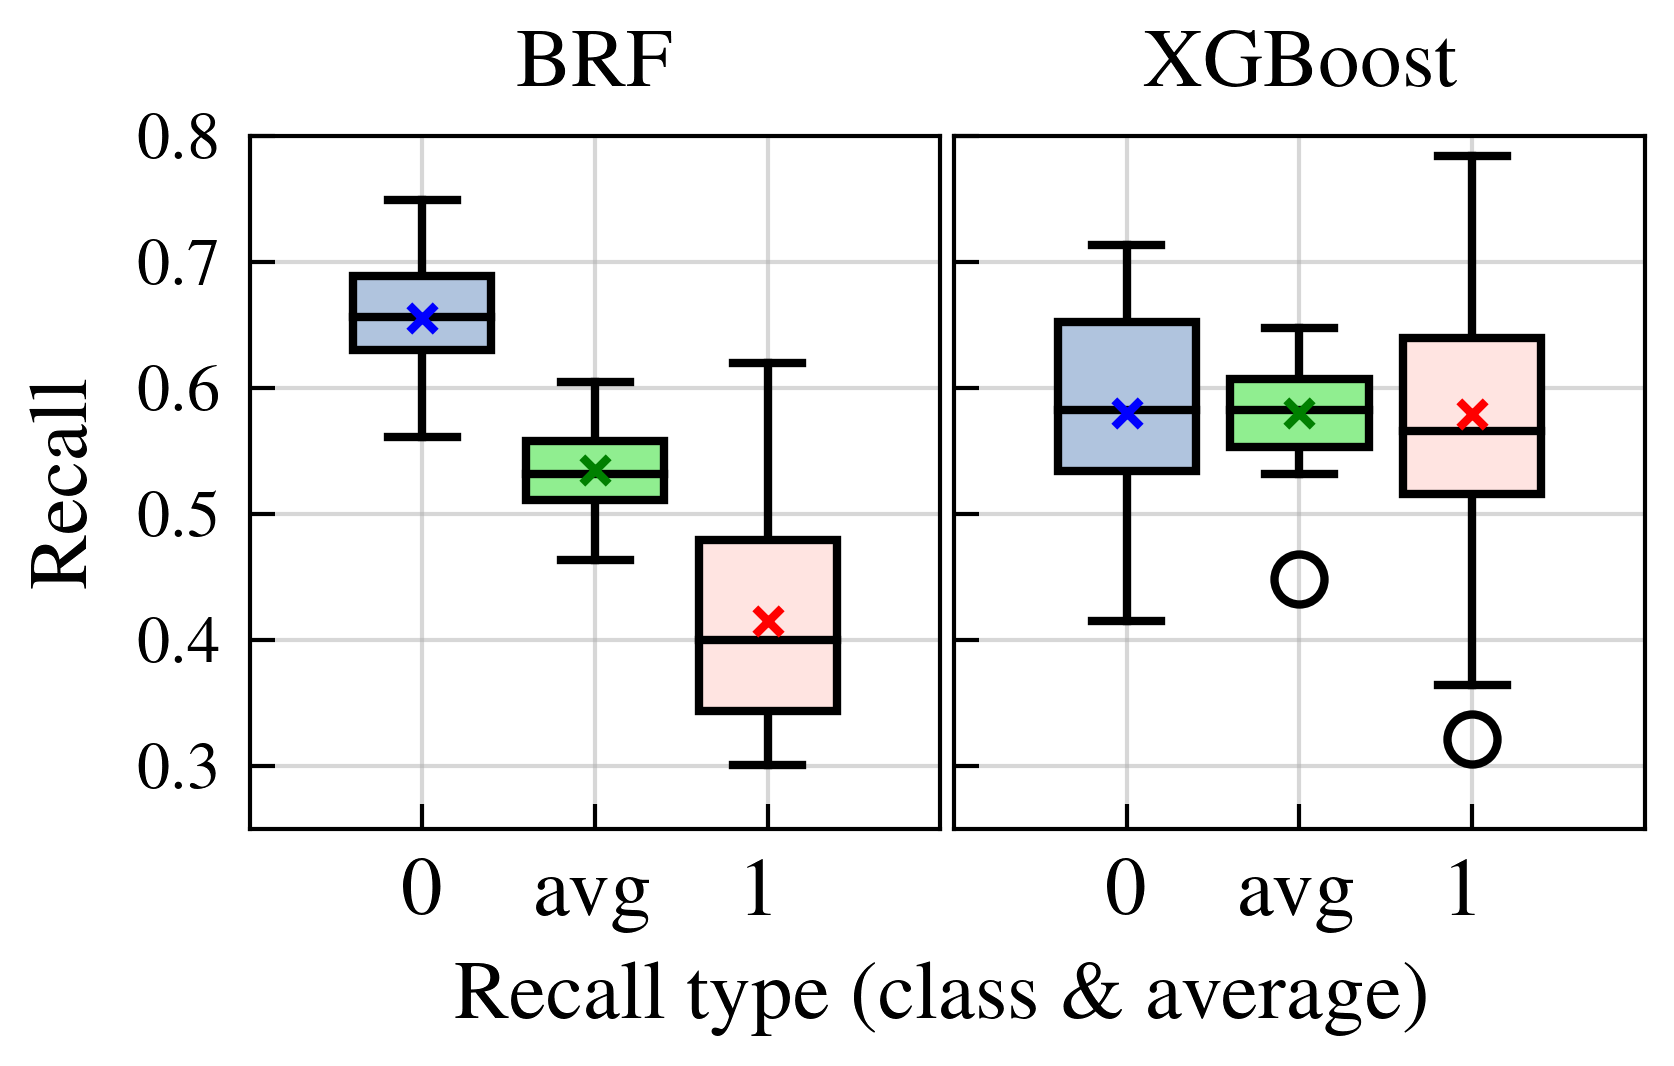

In [153]:
plt.rcParams.update({
    'xtick.minor.visible': False,
    'ytick.minor.visible': False
})
colors = ['lightsteelblue', 'mistyrose', 'lightgreen']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 1.5), sharey=True)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.subplots_adjust(wspace=0.02, hspace=0)
plt.ylim([0.25,0.8])

box1 = ax1.boxplot([recalls_brf['recall_0'], recalls_brf['recall_1'], recalls_brf['avg_recall']], positions=[1, 2, 1.5], widths=0.4, patch_artist=True)
ax1.set_title('BRF', fontsize=10)
ax1.set_xticks([1, 2, 1.5])
ax1.set_xticklabels(['0', '1', 'avg'], fontsize=10)
ax1.grid(alpha=0.5)
ax1.set_ylabel('Recall', fontsize=10)
for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)
for median in box1['medians']:
    median.set_color('black')
ax1.scatter(1, np.average(recalls_brf['recall_0']), color='b', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_brf['recall_0'])))
ax1.scatter(1.5, np.average(recalls_brf['avg_recall']), color='g', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_brf['avg_recall'])))
ax1.scatter(2, np.average(recalls_brf['recall_1']), color='r', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_brf['recall_1'])))
# ax1.legend(title='Mean value', loc=3, frameon=True)
    
box2 = ax2.boxplot([recalls_xgb['recall_0'], recalls_xgb['recall_1'], recalls_xgb['avg_recall']], positions=[1, 2, 1.5], widths=0.4, patch_artist=True) 
ax2.set_title('XGBoost', fontsize=10)
ax2.set_xticks([1, 2, 1.5])
ax2.set_xticklabels(['0', '1', 'avg'], fontsize=10)
ax2.grid(alpha=0.5)
for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)
for median in box2['medians']:
    median.set_color('black')
ax2.scatter(1, np.average(recalls_xgb['recall_0']), color='b', marker='x', zorder=3, s=10, label='{:.4f}'.format(np.average(recalls_xgb['recall_0'])))
ax2.scatter(1.5, np.average(recalls_xgb['avg_recall']), color='g', marker='x', zorder=3, s=10, label='{:.4f}'.format(np.average(recalls_xgb['avg_recall'])))
ax2.scatter(2, np.average(recalls_xgb['recall_1']), color='r', marker='x', zorder=3, s=10, label='{:.4f}'.format(np.average(recalls_xgb['recall_1'])))
# ax2.legend(title='Mean value', loc=3, frameon=True)

fig.text(0.51, -0.1, 'Recall type (class \& average)', ha='center', fontsize=10)
plt.savefig('./plots_plus/box_plot_constaint.pdf')

plt.show()

plt.rcParams.update({'xtick.minor.visible': True, 'ytick.minor.visible': True})

In [145]:
# box plots based on optimizations

recalls_xgb_1 = {
    'recall_0': [0.945398860921061, 0.9309487547780996, 0.9485998127084951, 0.9298556655680231, 0.9463703106306258, 0.9467852179679872, 0.9563514148506833, 0.945713790586769, 0.9604471667994148, 0.9454205227499192, 0.9533337554612803, 0.958414287475797, 0.9599472784411481, 0.9313536643482956, 0.9562597686516678, 0.9591107985883153, 0.9555582586555669, 0.9409681837722909, 0.9361659229438759, 0.9604904904571312, 0.9470201654963725, 0.9434392985566556, 0.9376039351211563, 0.9748239559831637, 0.9504060759763653, 0.9567379951810763, 0.9551750109142292, 0.9464619568296414, 0.9669490480459364, 0.9478216531641267, 0.9607204391019339, 0.9371640333658816, 0.9414864013703607, 0.9435409425228366, 0.9485998127084951, 0.9360676115667501, 0.9345179576561234, 0.958174341063829, 0.9414647395415024, 0.9324200928459311, 0.9385820500088313, 0.9450256109468885, 0.9332732356440395, 0.9424761803197286, 0.9324900772160885, 0.9407232384767402, 0.9346812545198239, 0.9325500638190805, 0.936379208643403, 0.9417013533644153],
    'recall_1': [0.5751093251388725, 0.6518142063585864, 0.65429618248434, 0.5462711263444038, 0.5023046921167711, 0.5502895638813379, 0.3945160146554781, 0.658905566717882, 0.44025528897293464, 0.5473348303982981, 0.4958042784540834, 0.3835244060985699, 0.510459756529961, 0.6141118071149982, 0.4518378442264508, 0.37737856045384705, 0.4828034511287082, 0.6249852263325848, 0.581373360122917, 0.3799787259189221, 0.5768821652286964, 0.542134499468148, 0.48150336839617064, 0.40834416735610446, 0.618248433991254, 0.4598747193003191, 0.40538943387306464, 0.5086869164401371, 0.45219241224441553, 0.537761493913249, 0.434345822006855, 0.5798368987117362, 0.5539534334003073, 0.7328920931331994, 0.6308946932986644, 0.6771067249734074, 0.5786550053185203, 0.45491076704881217, 0.5483985344521924, 0.625221605011228, 0.5780640586219123, 0.6854981680652406, 0.5348067604302092, 0.5021865027774495, 0.5463893156837253, 0.6317220186739156, 0.52003309301501, 0.5623448764921404, 0.47464838671551823, 0.7203640231651105],
    'avg_recall': [0.7602540930299667, 0.791381480568343, 0.8014479975964175, 0.7380633959562135, 0.7243375013736985, 0.7485373909246625, 0.6754337147530807, 0.8023096786523255, 0.7003512278861748, 0.7463776765741086, 0.7245690169576818, 0.6709693467871835, 0.7352035174855546, 0.7727327357316469, 0.7040488064390593, 0.6682446795210811, 0.7191808548921376, 0.7829767050524379, 0.7587696415333964, 0.6702346081880266, 0.7619511653625344, 0.7427868990124018, 0.7095536517586635, 0.691584061669634, 0.7843272549838096, 0.7083063572406977, 0.6802822223936469, 0.7275744366348893, 0.7095707301451759, 0.7427915735386879, 0.6975331305543945, 0.7585004660388088, 0.7477199173853339, 0.838216517828018, 0.7897472530035798, 0.8065871682700787, 0.7565864814873219, 0.7065425540563206, 0.7449316369968475, 0.7788208489285795, 0.7583230543153718, 0.8152618895060646, 0.7340399980371244, 0.722331341548589, 0.7394396964499068, 0.786222628575328, 0.7273571737674169, 0.7474474701556104, 0.7055137976794605, 0.831032688264763]
}

recalls_xgb_2 = {
    'recall_0': [0.9196429464086354, 0.8489620651387857, 0.9143291331602609, 0.8659349411964661, 0.8957166232874658, 0.8459144124478867, 0.9164886508679728, 0.8553806316589295, 0.9080688646202348, 0.9064475600449233, 0.88916308691059, 0.8493386477020132, 0.8982477246748226, 0.8818680494689519, 0.8733666147893637, 0.8487754401516995, 0.9243785554559482, 0.8430450532714361, 0.8984610103743498, 0.9031882879490247, 0.8824429210809586, 0.8621507863243876, 0.8990458797535217, 0.8517547747669687, 0.8946868532694365, 0.9216891560884736, 0.8615359236437196, 0.9011654063925724, 0.8723934987852713, 0.9037814888008345, 0.9111248487837716, 0.8755011380791623, 0.8574784964691219, 0.8794285942806107, 0.878163876734196, 0.9324667490927027, 0.8408238826662046, 0.8792053108139182, 0.8567070021028637, 0.8210549643912859, 0.9279110998543658, 0.850411741377759, 0.8580683647318765, 0.8729750355753881, 0.9172518137615933, 0.8856522043410305, 0.8831960862074136, 0.8746796548770774, 0.8784438142148253, 0.9063942386200415],
    'recall_1': [0.7428350116189001, 0.8497288923315259, 0.7668474051123161, 0.8280402788536019, 0.6847405112316034, 0.8799380325329202, 0.6924864446165763, 0.7784663051897753, 0.7126258714175058, 0.7776917118512781, 0.7955073586367157, 0.7784663051897753, 0.7823392718822618, 0.8210689388071263, 0.7986057319907048, 0.78001549186677, 0.7041053446940356, 0.7877614252517429, 0.9070487993803253, 0.7869868319132456, 0.7072037180480247, 0.7544539116963594, 0.7769171185127808, 0.7567776917118513, 0.7730441518202944, 0.7536793183578622, 0.7916343919442292, 0.737412858249419, 0.6886134779240899, 0.750580945003873, 0.7683965917893106, 0.7304415182029435, 0.7955073586367157, 0.7079783113865221, 0.6769945778466305, 0.6870642912470952, 0.8419829589465531, 0.8024786986831913, 0.8334624322230829, 0.836560805577072, 0.6808675445391169, 0.8164213787761425, 0.820294345468629, 0.710302091402014, 0.7606506584043378, 0.7575522850503486, 0.7149496514329977, 0.8001549186676995, 0.8412083656080558, 0.8319132455460883],
    'avg_recall': [0.8312389790137678, 0.8493454787351558, 0.8405882691362885, 0.846987610025034, 0.7902285672595346, 0.8629262224904035, 0.8044875477422746, 0.8169234684243525, 0.8103473680188703, 0.8420696359481007, 0.8423352227736529, 0.8139024764458942, 0.8402934982785422, 0.851468494138039, 0.8359861733900342, 0.8143954660092347, 0.8142419500749919, 0.8154032392615895, 0.9027549048773376, 0.8450875599311352, 0.7948233195644916, 0.8083023490103736, 0.8379814991331512, 0.8042662332394099, 0.8338655025448655, 0.8376842372231679, 0.8265851577939745, 0.8192891323209957, 0.7805034883546806, 0.8271812169023538, 0.8397607202865411, 0.8029713281410529, 0.8264929275529188, 0.7937034528335665, 0.7775792272904133, 0.809765520169899, 0.8414034208063788, 0.8408420047485547, 0.8450847171629733, 0.8288078849841789, 0.8043893221967413, 0.8334165600769508, 0.8391813551002527, 0.7916385634887011, 0.8389512360829655, 0.8216022446956895, 0.7990728688202057, 0.8374172867723885, 0.8598260899114405, 0.8691537420830648]
}

recalls_brf_1 = {
    'recall_0': [0.9696167855845528, 0.9150506386906924, 0.9640846877530684, 0.9667274308737716, 0.970748199568763, 0.9283959915618845, 0.957046259668674, 0.9646129031183036, 0.9696434462969936, 0.9612536533507516, 0.96713067414944, 0.9209759820306798, 0.9498661965494373, 0.9730810119073406, 0.9337797891804164, 0.942414527422209, 0.9515591517894337, 0.9535836996404137, 0.9127478196536107, 0.9685486907923897, 0.9647512055640907, 0.954433509849467, 0.927134606604525, 0.9666757757434173, 0.9664908170508586, 0.956311423782022, 0.9474900605531431, 0.9449722895220067, 0.9566646782218637, 0.9634548284216525, 0.9706032319448656, 0.9549100700843478, 0.9506793482788843, 0.9348778772740755, 0.9474717313133401, 0.9703716170055354, 0.8737898535993628, 0.9442991065328743, 0.9528322008084861, 0.9627499858364965, 0.9716163390176193, 0.9434809559198446, 0.9521040300999444, 0.9141158474607338, 0.9560814751372193, 0.9447190127538183, 0.9539536170255309, 0.9485648205234164, 0.9467952157351525, 0.9540052721558852],
    'recall_1': [0.65143299767622, 0.8086754453911696, 0.673121611154144, 0.7273431448489543, 0.5809450038729667, 0.8427575522850503, 0.592563903950426, 0.5778466305189776, 0.6336173508907823, 0.6909372579395817, 0.7087529047250194, 0.726568551510457, 0.7412858249419055, 0.710302091402014, 0.7126258714175058, 0.7033307513555384, 0.6537567776917118, 0.7017815646785438, 0.8721920991479474, 0.6893880712625872, 0.5677769171185127, 0.6824167312161116, 0.6584043377226956, 0.6553059643687065, 0.6475600309837335, 0.6405886909372579, 0.6963594113090628, 0.691711851278079, 0.6158017041053447, 0.6560805577072037, 0.691711851278079, 0.6421378776142526, 0.6948102246320682, 0.6041828040278854, 0.7017815646785438, 0.611154144074361, 0.7924089852827265, 0.7110766847405112, 0.7288923315259489, 0.7226955848179706, 0.5964368706429125, 0.7203718048024786, 0.7436096049573974, 0.6646010844306739, 0.7149496514329977, 0.6963594113090628, 0.635166537567777, 0.7567776917118513, 0.7660728117738187, 0.7645236250968241],
    'avg_recall': [0.8105248916303864, 0.861863042040931, 0.8186031494536062, 0.847035287861363, 0.7758466017208648, 0.8855767719234674, 0.77480508180955, 0.7712297668186405, 0.801630398593888, 0.8260954556451667, 0.8379417894372296, 0.8237722667705684, 0.8455760107456713, 0.8416915516546772, 0.8232028302989611, 0.8228726393888737, 0.8026579647405727, 0.8276826321594788, 0.892469959400779, 0.8289683810274884, 0.7662640613413016, 0.8184251205327893, 0.7927694721636103, 0.810990870056062, 0.807025424017296, 0.79845005735964, 0.8219247359311029, 0.8183420704000428, 0.7862331911636042, 0.8097676930644282, 0.8311575416114723, 0.7985239738493002, 0.8227447864554762, 0.7695303406509804, 0.8246266479959419, 0.7907628805399483, 0.8330994194410446, 0.8276878956366928, 0.8408622661672175, 0.8427227853272335, 0.784026604830266, 0.8319263803611616, 0.8478568175286709, 0.7893584659457038, 0.8355155632851086, 0.8205392120314405, 0.7945600772966539, 0.8526712561176338, 0.8564340137544856, 0.8592644486263546]
}

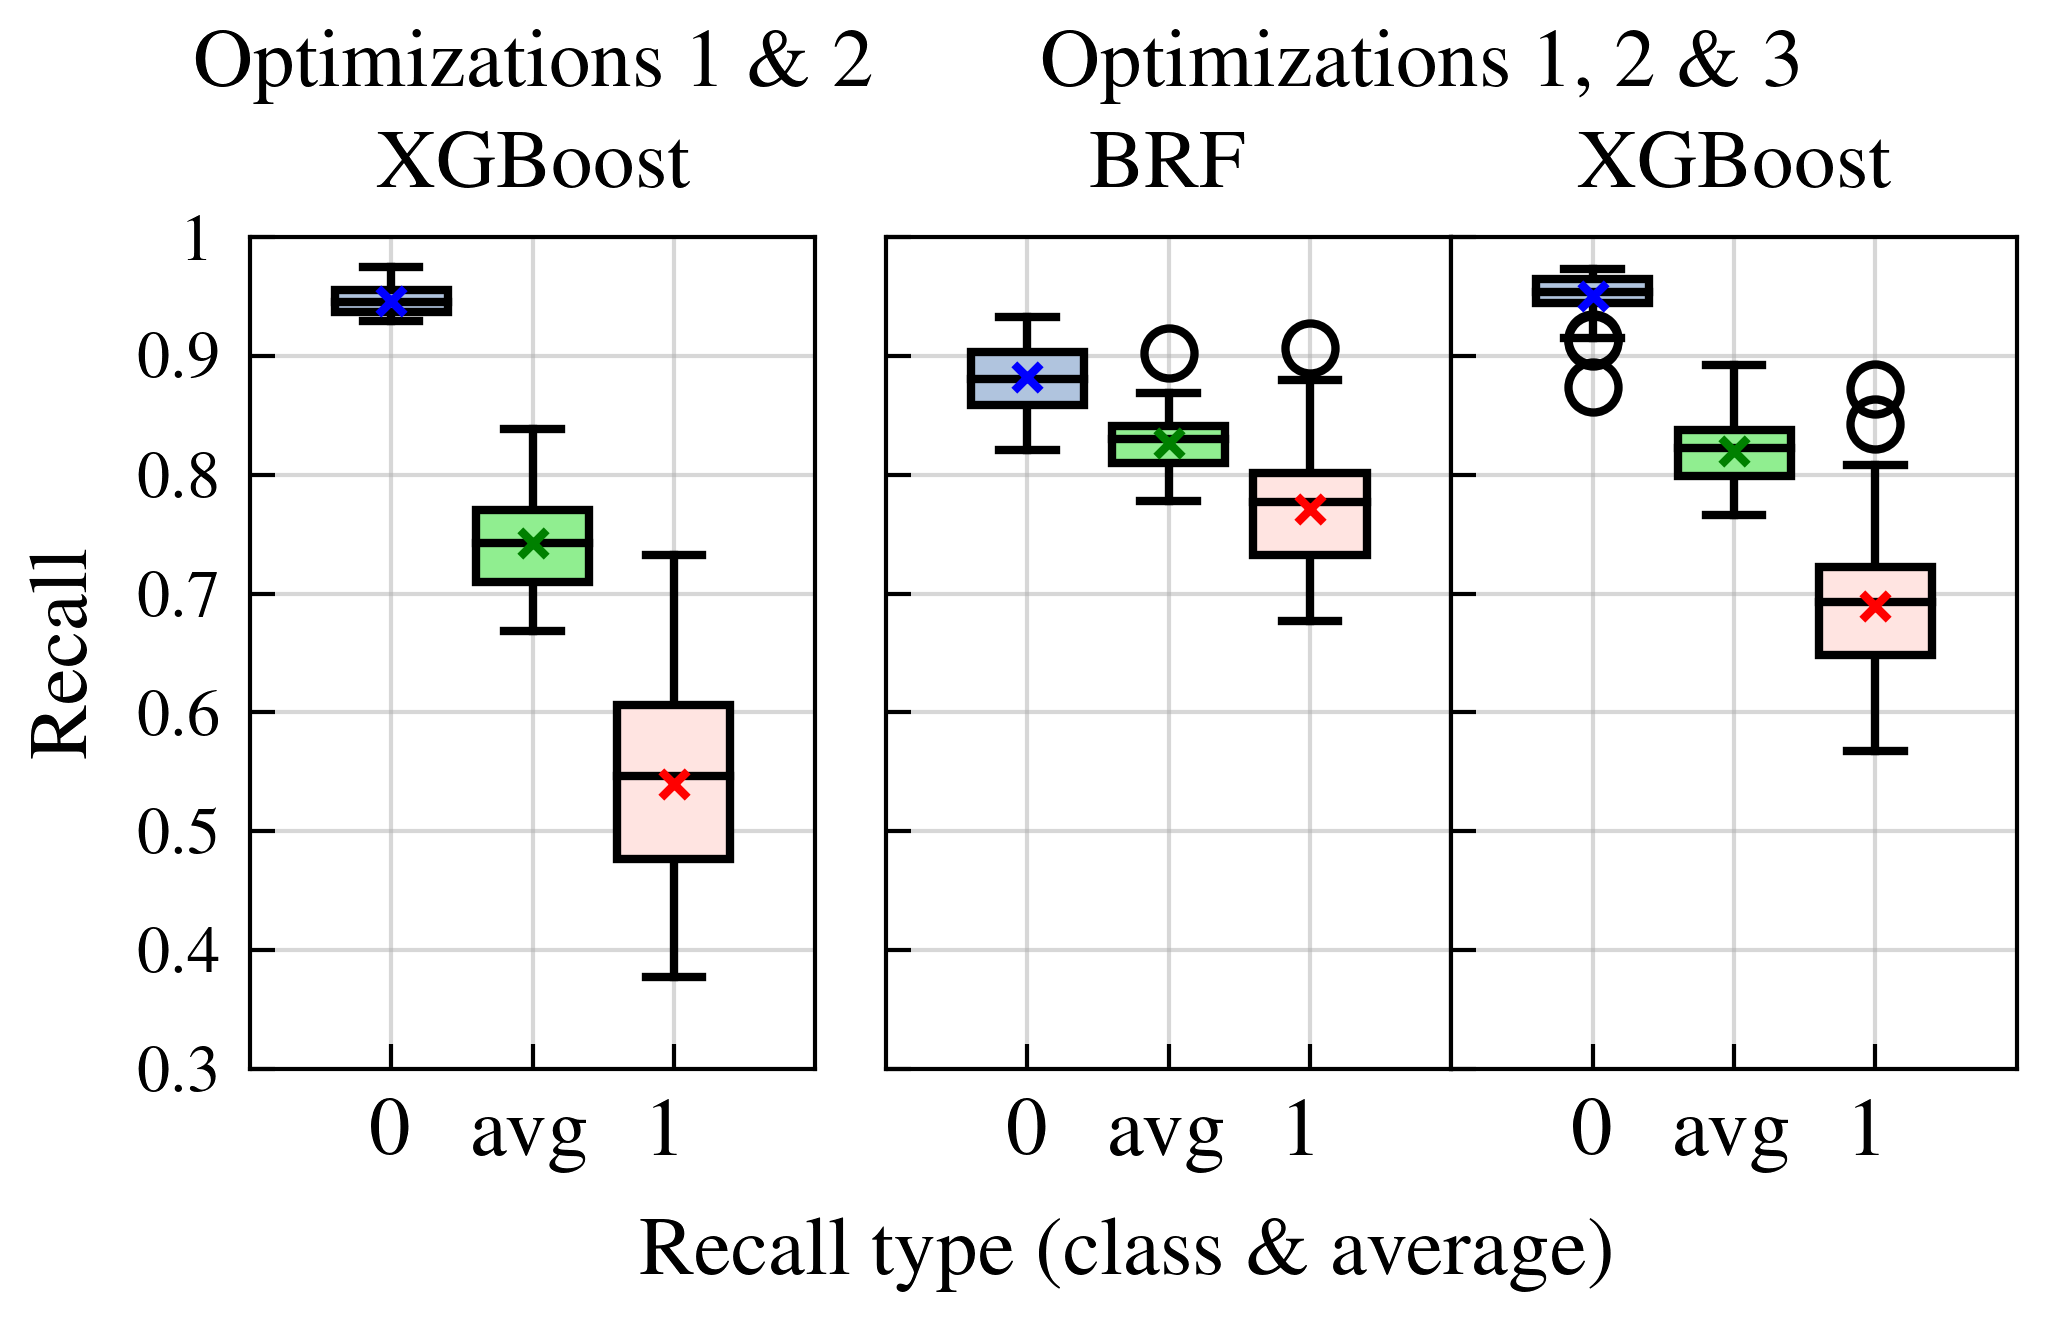

In [159]:
plt.rcParams.update({
    'xtick.minor.visible': False,
    'ytick.minor.visible': False
})
colors = ['lightsteelblue', 'mistyrose', 'lightgreen']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3.8, 1.8), sharey=True, gridspec_kw=dict(width_ratios=[4,0.5,4,4], wspace=0))
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax2.remove()
plt.ylim([0.3,1])

box1 = ax1.boxplot([recalls_xgb_1['recall_0'], recalls_xgb_1['recall_1'], recalls_xgb_1['avg_recall']], positions=[1, 2, 1.5], widths=0.4, patch_artist=True)
ax1.set_title('XGBoost', fontsize=10)
ax1.set_xticks([1, 2, 1.5])
ax1.set_xticklabels(['0', '1', 'avg'], fontsize=10)
ax1.grid(alpha=0.5)
ax1.set_ylabel('Recall', fontsize=10)
for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)
for median in box1['medians']:
    median.set_color('black')
ax1.scatter(1, np.average(recalls_xgb_1['recall_0']), color='b', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_xgb_1['recall_0'])))
ax1.scatter(1.5, np.average(recalls_xgb_1['avg_recall']), color='g', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_xgb_1['avg_recall'])))
ax1.scatter(2, np.average(recalls_xgb_1['recall_1']), color='r', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_xgb_1['recall_1'])))
# ax1.legend(title='Mean value', loc=8, frameon=True)
    
box2 = ax3.boxplot([recalls_xgb_2['recall_0'], recalls_xgb_2['recall_1'], recalls_xgb_2['avg_recall']], positions=[1, 2, 1.5], widths=0.4, patch_artist=True) 
ax3.set_title('BRF', fontsize=10)
ax3.set_xticks([1, 2, 1.5])
ax3.set_xticklabels(['0', '1', 'avg'], fontsize=10)
ax3.grid(alpha=0.5)
for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)
for median in box2['medians']:
    median.set_color('black')
ax3.scatter(1, np.average(recalls_xgb_2['recall_0']), color='b', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_xgb_2['recall_0'])))
ax3.scatter(1.5, np.average(recalls_xgb_2['avg_recall']), color='g', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_xgb_2['avg_recall'])))
ax3.scatter(2, np.average(recalls_xgb_2['recall_1']), color='r', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_xgb_2['recall_1'])))
# ax3.legend(title='Mean value', loc=8, frameon=True)

box3 = ax4.boxplot([recalls_brf_1['recall_0'], recalls_brf_1['recall_1'], recalls_brf_1['avg_recall']], positions=[1, 2, 1.5], widths=0.4, patch_artist=True) 
ax4.set_title('XGBoost', fontsize=10)
ax4.set_xticks([1, 2, 1.5])
ax4.set_xticklabels(['0', '1', 'avg'], fontsize=10)
ax4.grid(alpha=0.5)
for patch, color in zip(box3['boxes'], colors):
    patch.set_facecolor(color)
for median in box3['medians']:
    median.set_color('black')
ax4.scatter(1, np.average(recalls_brf_1['recall_0']), color='b', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_brf_1['recall_0'])))
ax4.scatter(1.5, np.average(recalls_brf_1['avg_recall']), color='g', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_brf_1['avg_recall'])))
ax4.scatter(2, np.average(recalls_brf_1['recall_1']), color='r', marker='x', zorder=3, s=10, label='{:.3f}'.format(np.average(recalls_brf_1['recall_1'])))
# ax4.legend(title='Mean value', loc=8, frameon=True)

fig.text(0.51, -0.08, 'Recall type (class \& average)', ha='center', fontsize=10)
fig.text(0.25, 1.02, 'Optimizations 1 \& 2', ha='center', fontsize=10)
fig.text(0.64, 1.02, 'Optimizations 1, 2 \& 3', ha='center', fontsize=10)
plt.savefig('./plots_plus/box_plot_optimization.pdf')

plt.show()

plt.rcParams.update({'xtick.minor.visible': True})

In [212]:
# recreate the final dataset with all features

files = glob.glob("Retina/shared/*/*/*_500ms_Song_no_log.csv")

scaler = preprocessing.MinMaxScaler() 

df_total = []
for file in files:   
    df_input = pd.read_csv(file)
    
    df_inter = copy.deepcopy(df_input)
    df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
    drop_col = [
        'software', 
        'label', 
        'pcap', 
        'ssrc', 
        'rtp_seq_num_packet_loss', 
        'ip_src', 
        'ip_dst', 
        'prt_src', 
        'prt_dst', 
        'rtp_csrc_csrc_agg',
        'p_type'
    ]
    for col in df_inter.columns:
        if col in drop_col or col.startswith('rtp_interarrival'): 
            df_inter.drop(col, axis=1, inplace=True)
    
    flow_list = df_inter['flow'].drop_duplicates().tolist()
    for flow in flow_list:
        df_check = df_inter[df_inter['flow'] == flow].copy()
        if df_check.shape[0] > 10: 
            df_total.append(df_check)
        
df_total_final = []
flow_id = 1
for df_per_flow in df_total:
    df_temp = copy.deepcopy(df_per_flow)
    df_temp.reset_index(inplace=True)
    df_temp['lossOrNot'] = [1 if x>0 else 0 for x in df_temp['num_packet_loss']] 
    df_temp.drop(['index', 'flow'], axis=1, inplace=True) 
    df_temp['flow_id'] = flow_id
    flow_id += 1
    
    for col in df_temp.columns:
        if col not in ['timestamp', 'lossOrNot', 'num_packet_loss', 'flow_id']:
            df_temp[col] = scaler.fit_transform(df_temp[col].values.reshape(-1,1))
    
    start_time = pd.to_datetime(df_temp['timestamp'].min())
    stop_time = pd.to_datetime(df_temp['timestamp'].max())
    timestamp_ser = pd.date_range(start_time, stop_time, freq="500L")
    correct_len = len(timestamp_ser)
    
    if df_temp.shape[0] == correct_len:
        df_full = copy.deepcopy(df_temp)
        df_total_final.append(df_full)
    
    else:
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_full = pd.DataFrame({'timestamp': timestamp_ser})
        df_full['timestamp'] = df_full['timestamp']
        df_full = df_full.merge(df_temp, on='timestamp', how='left')
        
        nan_index_list = [0]
        nan_index_list.extend(df_full[np.isnan(df_full['interarrival_std'])].index.tolist())
        nan_index_list.append(df_full.index[-1])
        
        for i in range(1, len(nan_index_list)):
            if nan_index_list[i] - nan_index_list[i-1] - 1 >= 11:
                start_idx = 0 if nan_index_list[i-1]==0 else nan_index_list[i-1]+1
                stop_idx = df_full.index[-1]+1 if nan_index_list[i]==df_full.index[-1] else nan_index_list[i]
                df_separate = df_full.iloc[start_idx:stop_idx, :].copy()
                df_separate.reset_index(inplace=True)
                df_separate.drop(['index'], axis=1, inplace=True)
                df_total_final.append(df_separate)

In [214]:
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]

full_features_list = [] 
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)
for i in range(1,11):
    col_title = f'lossOrNot_minus_{500*i}ms'
    full_features_list.append(col_title)
    
full_features_list_removing_500ms = []
for feature in full_features_list:
    if '_500ms' not in feature:
        full_features_list_removing_500ms.append(feature)

complete_list = ['timestamp', 'lossOrNot', 'num_packet_loss', 'flow_id']
complete_list.extend(selected_features_list_removing_correlation)

In [217]:
df_total_final_feature_extraction = []
for df in df_total_final:
    df_temp = copy.deepcopy(df)
    df_temp = df_temp[complete_list]
    temp_feature_list = selected_features_list_removing_correlation.copy()
    temp_feature_list.append('lossOrNot')
    for feature in temp_feature_list:
        for i in range(1,11):
            col_title = f'{feature}_minus_{500*i}ms'
            df_temp[col_title] = df_temp[feature].shift(periods=i, fill_value=-1)
    df_temp.drop(selected_features_list_removing_correlation, axis=1, inplace=True)
    df_temp = df_temp.iloc[10:]
    df_temp.reset_index(inplace=True)
    df_temp.drop(['index'], axis=1, inplace=True)
    
    df_total_final_feature_extraction.append(df_temp)

In [218]:
df_final = pd.concat(df_total_final_feature_extraction)
df_final.reset_index(inplace=True)
df_final.drop(['index'], axis=1, inplace=True)
df_final

,timestamp,lossOrNot,num_packet_loss,flow_id,interarrival_std_minus_500ms,interarrival_std_minus_1000ms,interarrival_std_minus_1500ms,interarrival_std_minus_2000ms,interarrival_std_minus_2500ms,interarrival_std_minus_3000ms,...,lossOrNot_minus_500ms,lossOrNot_minus_1000ms,lossOrNot_minus_1500ms,lossOrNot_minus_2000ms,lossOrNot_minus_2500ms,lossOrNot_minus_3000ms,lossOrNot_minus_3500ms,lossOrNot_minus_4000ms,lossOrNot_minus_4500ms,lossOrNot_minus_5000ms
0,2020-12-14 13:34:44.500000,0.0,0.0,1.0,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-12-14 13:34:45,0.0,0.0,1.0,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-12-14 13:34:45.500000,0.0,0.0,1.0,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-12-14 13:34:46,0.0,0.0,1.0,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-12-14 13:34:46.500000,0.0,0.0,1.0,0.113890,0.081800,0.122365,0.169699,0.185914,0.111167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028655,2020-05-13 14:59:09.000,0.0,0.0,2882.0,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2028656,2020-05-13 14:59:09.500,0.0,0.0,2882.0,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2028657,2020-05-13 14:59:10.000,0.0,0.0,2882.0,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2028658,2020-05-13 14:59:10.500,0.0,0.0,2882.0,0.133611,0.048801,0.083497,0.083744,0.075046,0.078230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
df_final = pd.read_csv('models/df_final.csv.csv')
df_final

# with open(f'./models/df_final.csv', "w") as file:
#     df_final.to_csv(file, index=False)

In [221]:
# get final model 
import pickle

df_loss = df_final[df_final['lossOrNot'] > 0]
df_no_loss = df_final[df_final['lossOrNot'] < 1]

flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()

In [224]:
weight = len(df_no_loss) / len(df_loss)
weight

70.92044527954054

[0]	validation_0-aucpr:0.276581
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.306358
[2]	validation_0-aucpr:0.305557
[3]	validation_0-aucpr:0.317014
[4]	validation_0-aucpr:0.332176
[5]	validation_0-aucpr:0.337129
[6]	validation_0-aucpr:0.337581
[7]	validation_0-aucpr:0.346212
[8]	validation_0-aucpr:0.358117
[9]	validation_0-aucpr:0.361182
[10]	validation_0-aucpr:0.367608
[11]	validation_0-aucpr:0.363138
[12]	validation_0-aucpr:0.369087
[13]	validation_0-aucpr:0.372812
[14]	validation_0-aucpr:0.374789
[15]	validation_0-aucpr:0.377627
[16]	validation_0-aucpr:0.379613
[17]	validation_0-aucpr:0.377398
[18]	validation_0-aucpr:0.375204
[19]	validation_0-aucpr:0.37529
[20]	validation_0-aucpr:0.373945
[21]	validation_0-aucpr:0.375215
[22]	validation_0-aucpr:0.373737
[23]	validation_0-aucpr:0.375708
[24]	validation_0-aucpr:0.374762
[25]	validation_0-aucpr:0.374874
[26]	validation_0-aucpr:0.375386
Stopping. Best iteration:
[16]	validation_0-aucpr:0.37

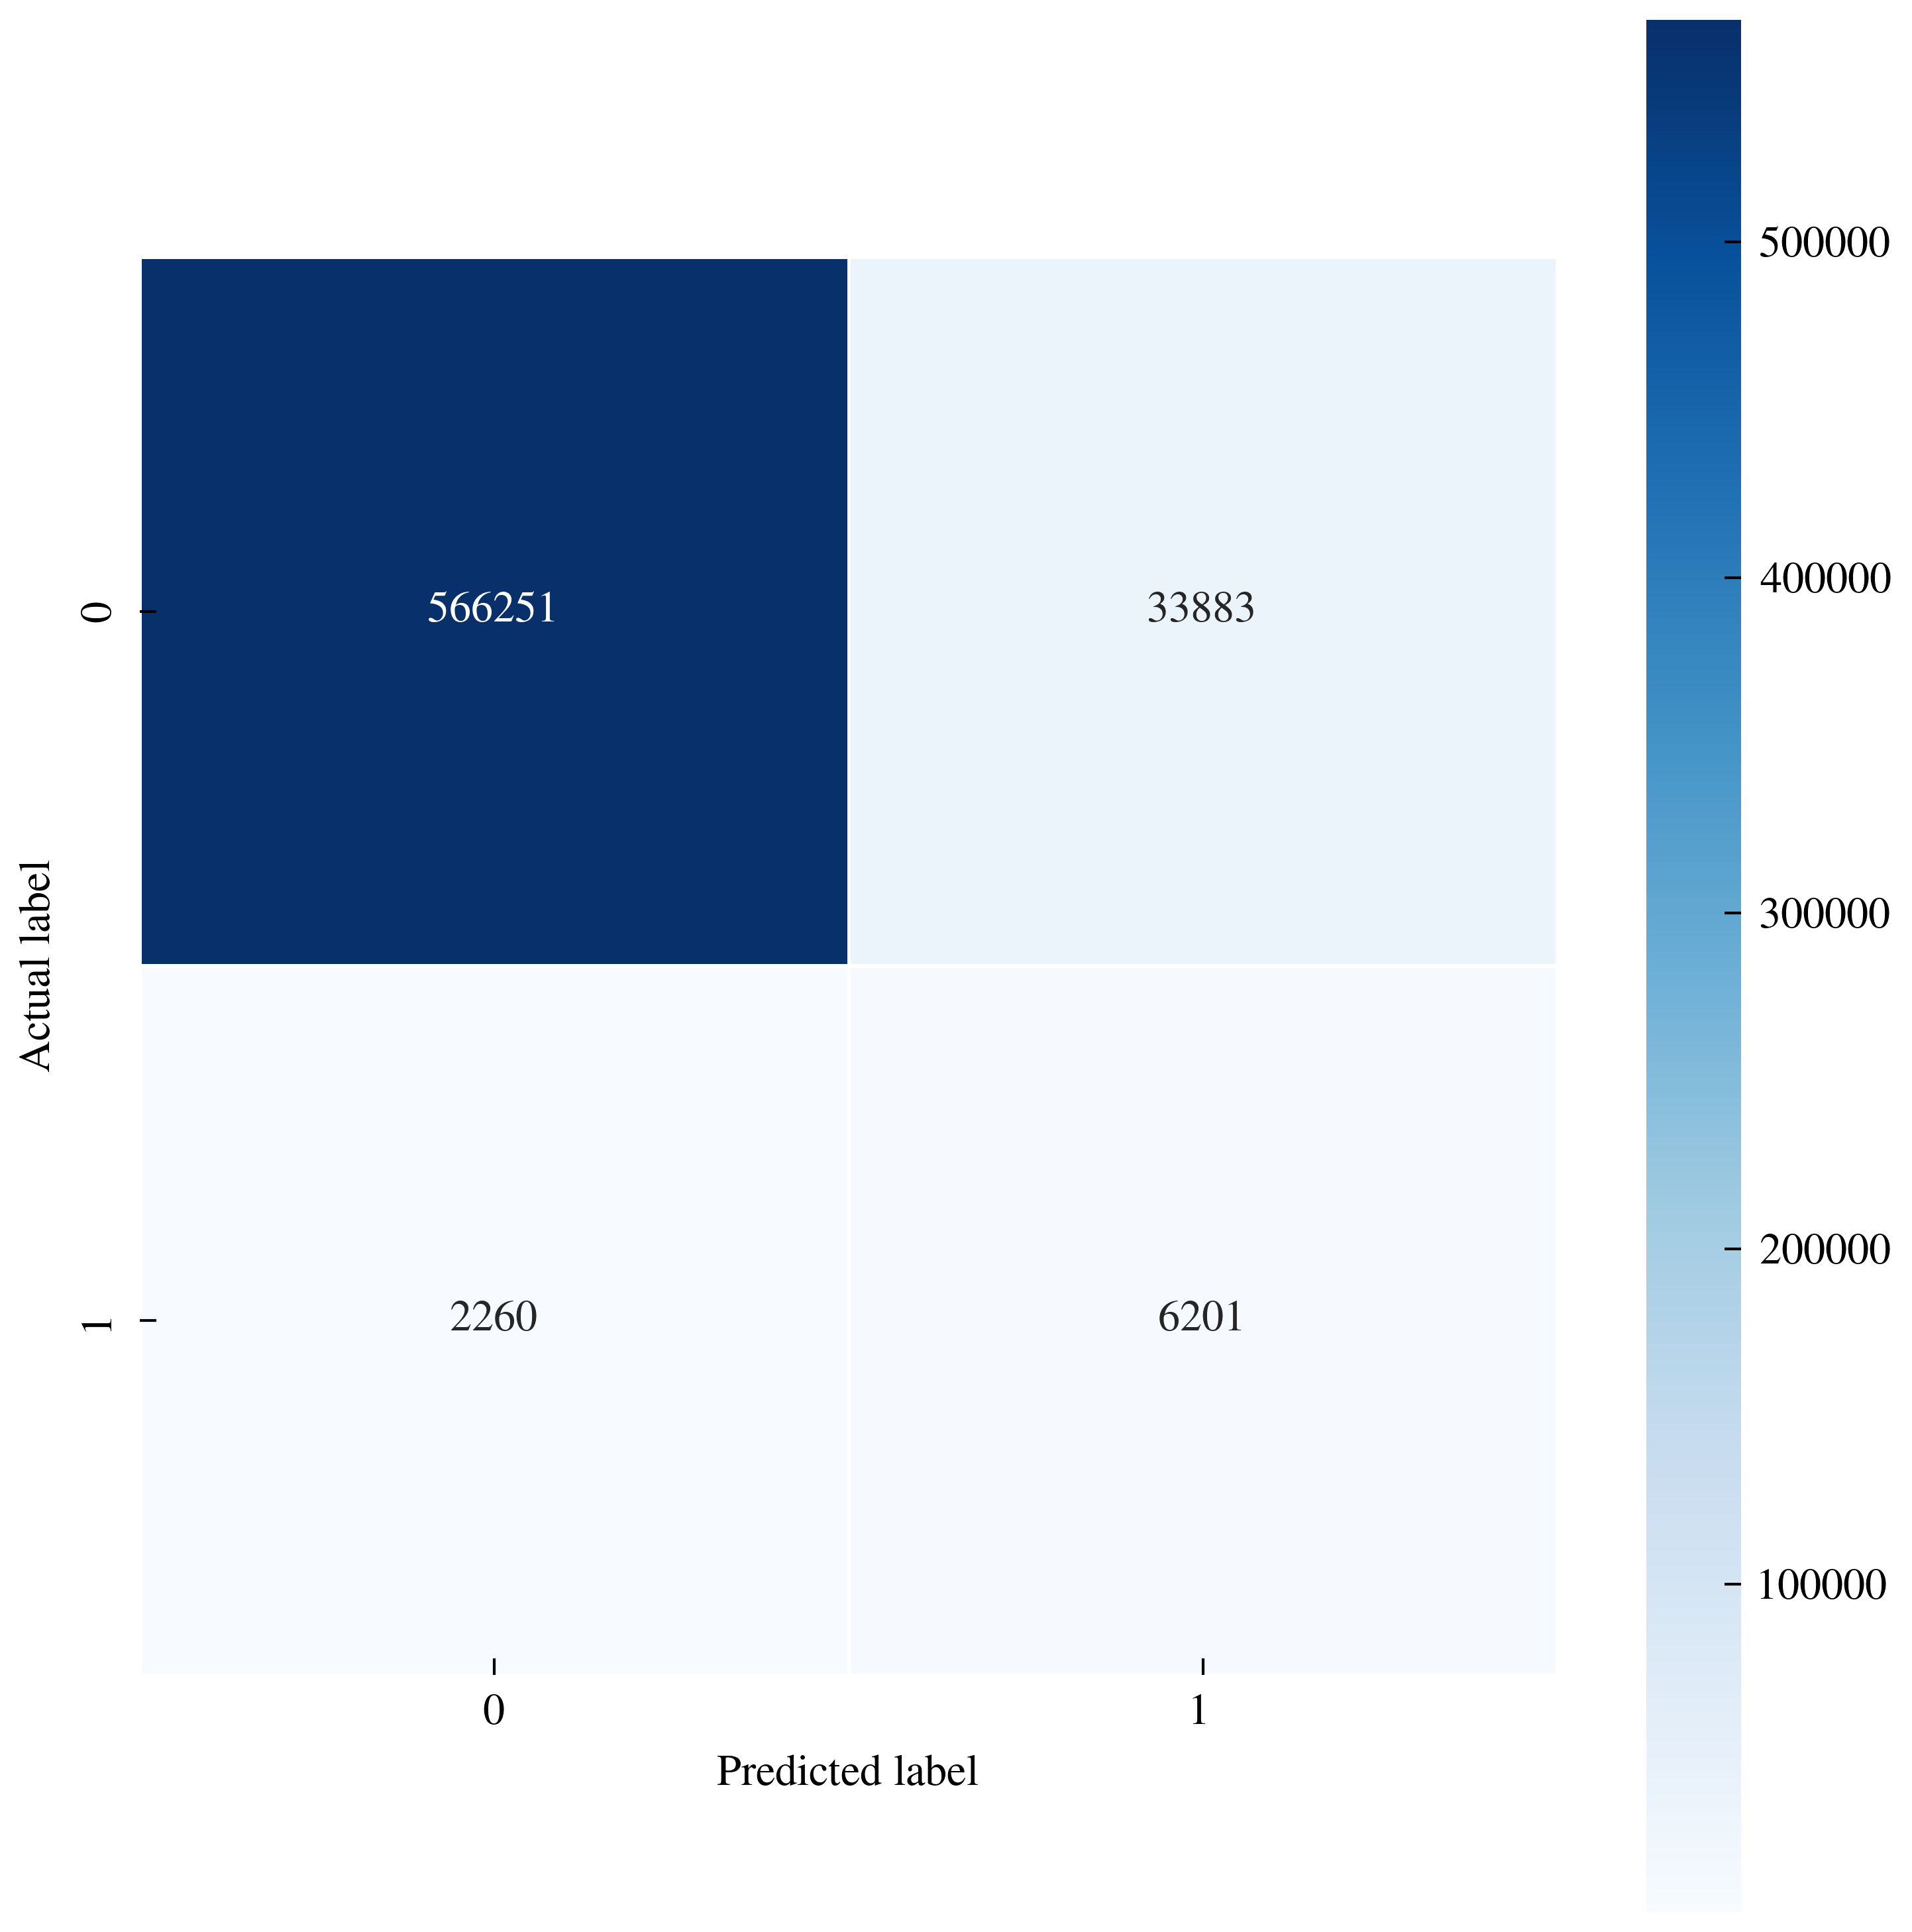

0.9435409425228366
0.7328920931331994
0.838216517828018


In [ ]:
# xgboost

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    if trial == 34:
        df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
        df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])

        df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
        df_train_shuffled = df_train.sample(frac=1).reset_index()
        df_train_shuffled.drop(['index'], axis=1, inplace=True)
        df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
        df_test_shuffled = df_test.sample(frac=1).reset_index()
        df_test_shuffled.drop(['index'], axis=1, inplace=True)

        x_train = df_train_shuffled[full_features_list_removing_500ms]
        x_test = df_test_shuffled[full_features_list_removing_500ms]
        y_train = df_train_shuffled[['lossOrNot']]
        y_train = y_train.astype(int)
        y_test = df_test_shuffled[['lossOrNot']]
        y_test = y_test.astype(int)

        clf_xgb_check = xgb.XGBClassifier(
            n_estimators=500, 
            objective='binary:logistic', 
            scale_pos_weight=weight, 
            n_jobs=48
        )

        clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])

        y_pred = clf_xgb_check.predict(x_test)
        print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,5))
        sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

        report = classification_report(y_test, y_pred, output_dict=True)
        print(report['0']['recall'])
        print(report['1']['recall'])
        print(report['macro avg']['recall'])

In [228]:
# clf_xgb_check.save_model("./models/xgb_model_entire_dataset.json")
# pickle.dump(clf_xgb_check, open('./models/xgb_model_entire_dataset.pkl', 'wb'))

In [229]:
df_loss = df_final[df_final['num_packet_loss'] > 2]
df_no_loss = df_final[df_final['lossOrNot'] < 1]

flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()

Prediction Report of trial 19
               precision    recall  f1-score   support

           0       1.00      0.90      0.94    600134
           1       0.02      0.91      0.04      1291

    accuracy                           0.90    601425
   macro avg       0.51      0.90      0.49    601425
weighted avg       1.00      0.90      0.94    601425



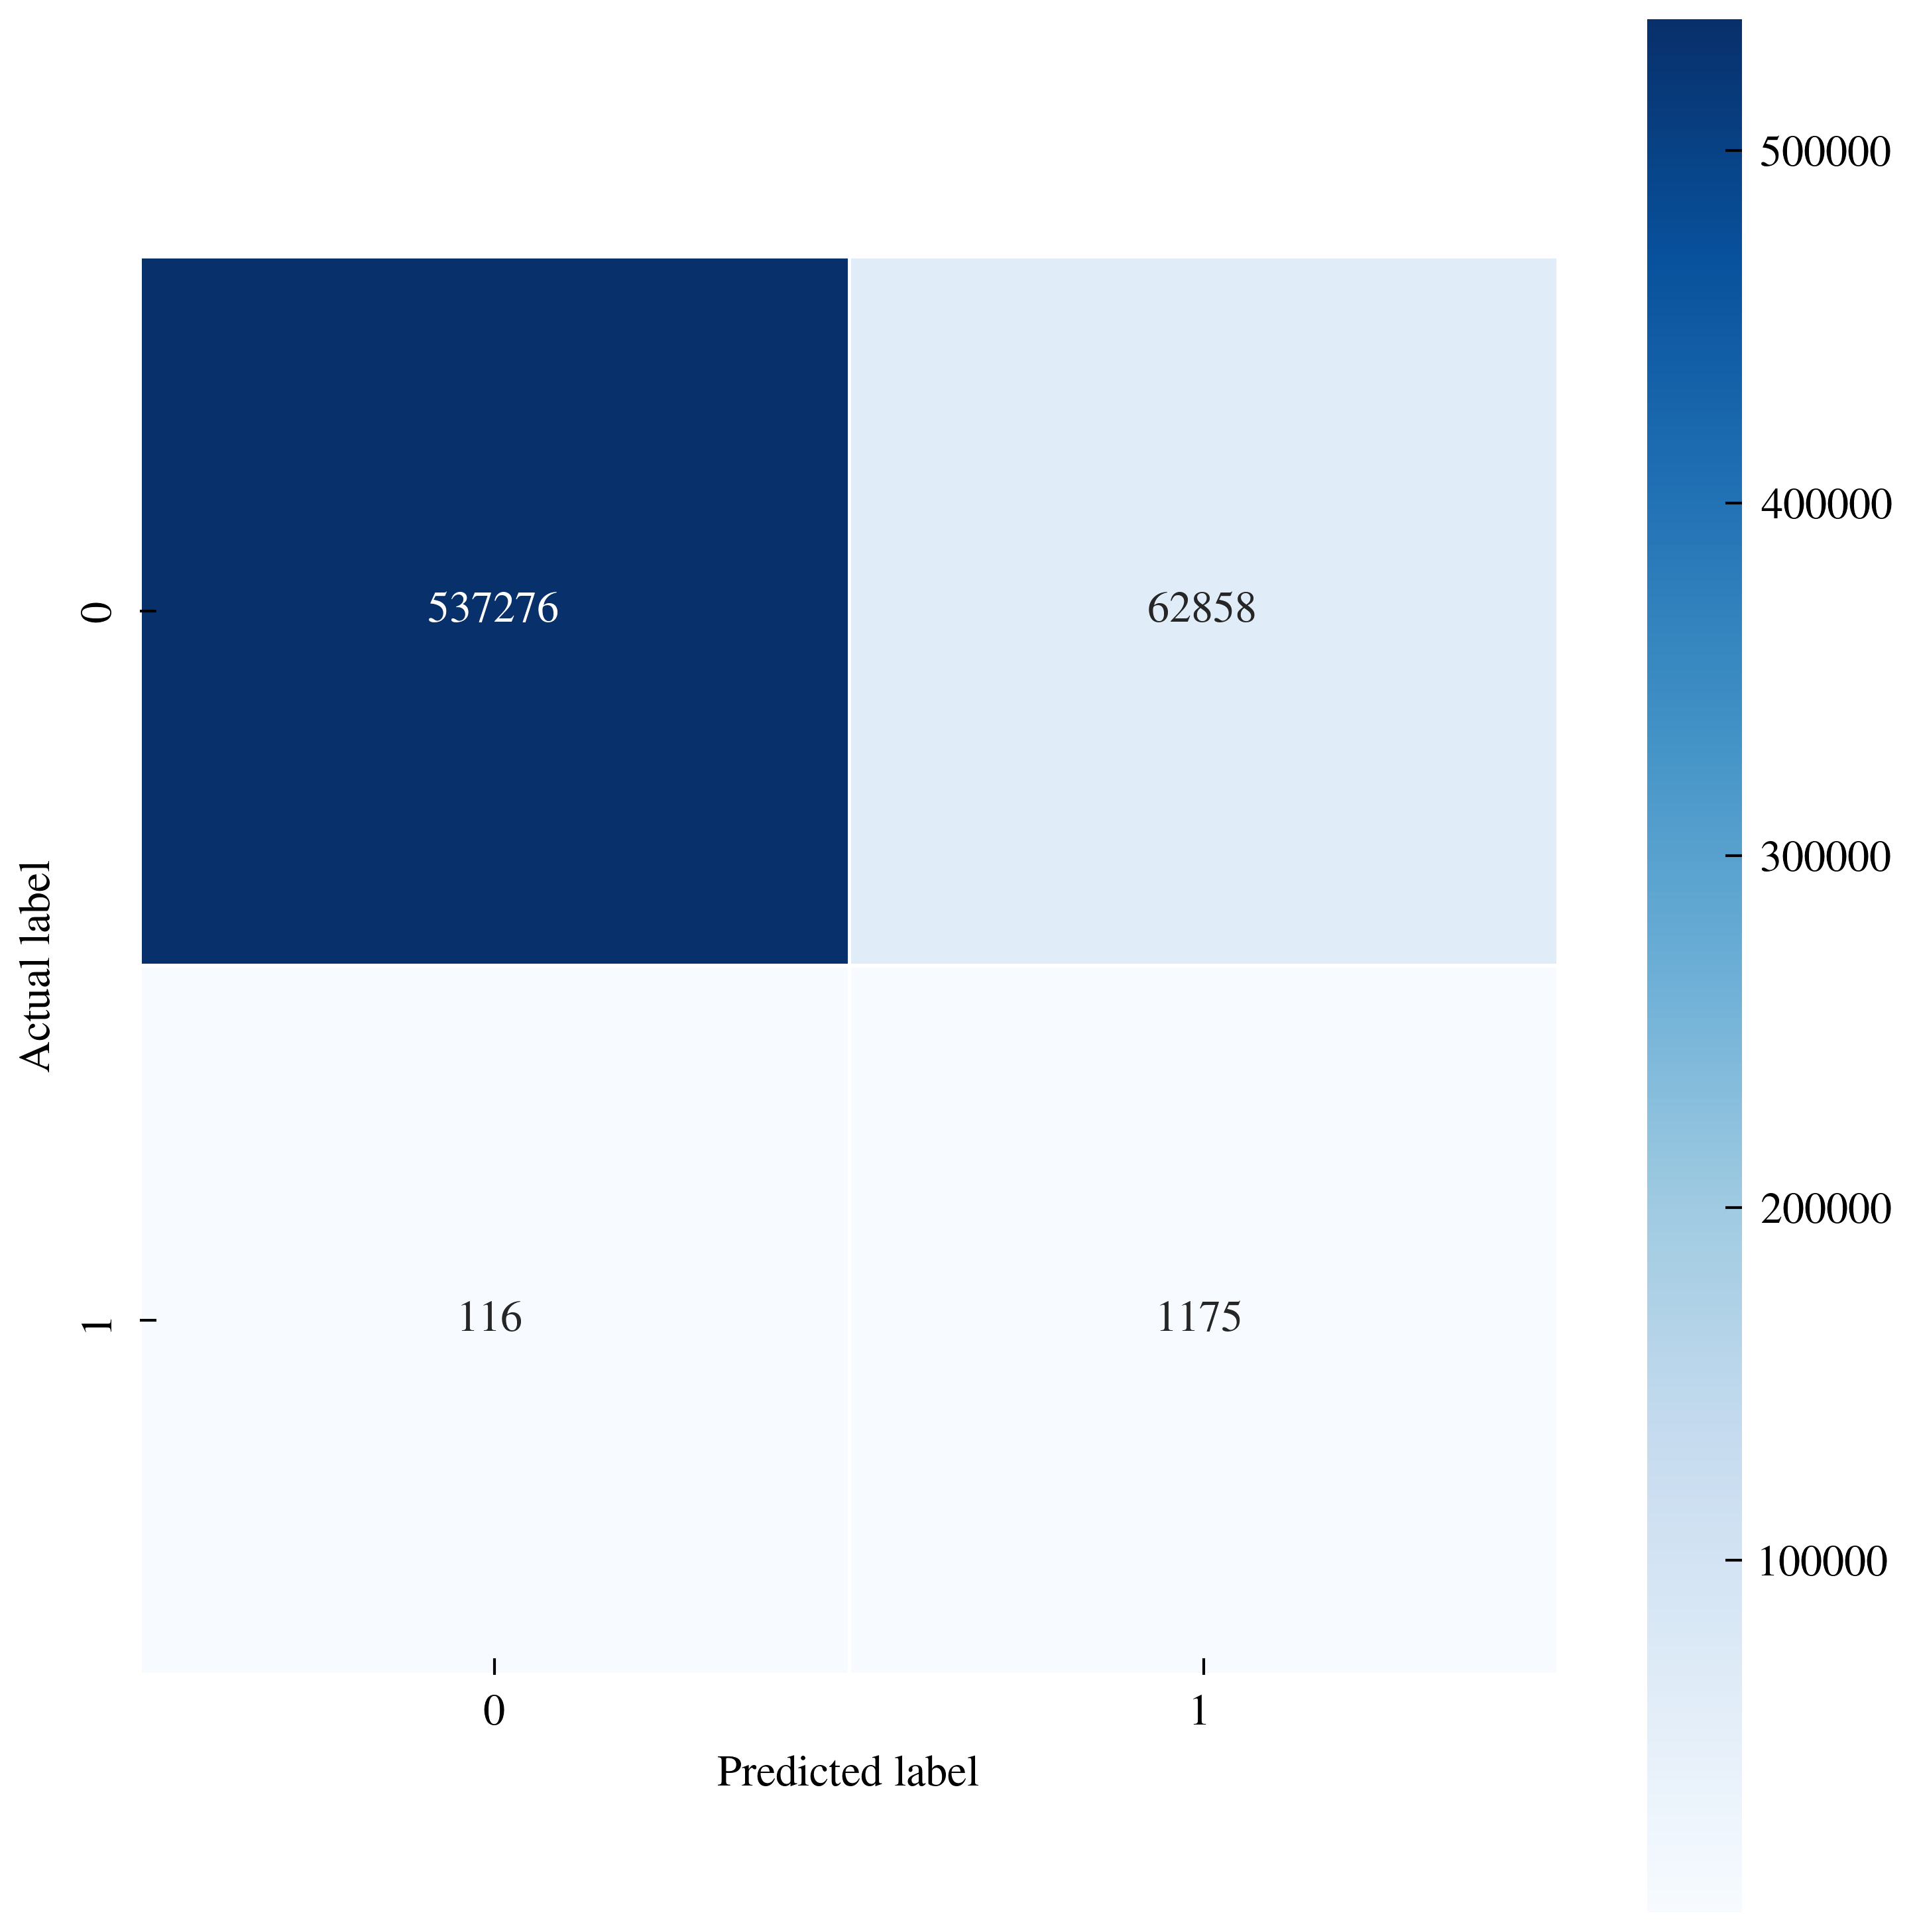

0.8952600585869156
0.9101471727343144
0.902703615660615


In [230]:
# brf

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    if trial == 19:
        df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
        df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])

        df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
        df_train_shuffled = df_train.sample(frac=1).reset_index()
        df_train_shuffled.drop(['index'], axis=1, inplace=True)
        df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
        df_test_shuffled = df_test.sample(frac=1).reset_index()
        df_test_shuffled.drop(['index'], axis=1, inplace=True)

        x_train = df_train_shuffled[full_features_list_removing_500ms]
        x_test = df_test_shuffled[full_features_list_removing_500ms]
        y_train = df_train_shuffled[['lossOrNot']]
        y_train = y_train.astype(int)
        y_test = df_test_shuffled[['lossOrNot']]
        y_test = y_test.astype(int)

        my_brf_model_check = BalancedRandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0) 
        my_brf_model_check.fit(x_train, y_train)

        y_pred = my_brf_model_check.predict(x_test)
        print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,5))
        sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

        report = classification_report(y_test, y_pred, output_dict=True)
        print(report['0']['recall'])
        print(report['1']['recall'])
        print(report['macro avg']['recall'])

In [231]:
# pickle.dump(my_brf_model_check, open('./models/brf_model_reduced_dataset.pkl', 'wb'))

[0]	validation_0-aucpr:0.187503
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.196394
[2]	validation_0-aucpr:0.218903
[3]	validation_0-aucpr:0.223086
[4]	validation_0-aucpr:0.218237
[5]	validation_0-aucpr:0.223536
[6]	validation_0-aucpr:0.224201
[7]	validation_0-aucpr:0.236463
[8]	validation_0-aucpr:0.271597
[9]	validation_0-aucpr:0.267574
[10]	validation_0-aucpr:0.293129
[11]	validation_0-aucpr:0.290463
[12]	validation_0-aucpr:0.28982
[13]	validation_0-aucpr:0.308547
[14]	validation_0-aucpr:0.320237
[15]	validation_0-aucpr:0.316984
[16]	validation_0-aucpr:0.317099
[17]	validation_0-aucpr:0.340413
[18]	validation_0-aucpr:0.356931
[19]	validation_0-aucpr:0.389463
[20]	validation_0-aucpr:0.389931
[21]	validation_0-aucpr:0.38074
[22]	validation_0-aucpr:0.397802
[23]	validation_0-aucpr:0.40745
[24]	validation_0-aucpr:0.449575
[25]	validation_0-aucpr:0.452719
[26]	validation_0-aucpr:0.468035
[27]	validation_0-aucpr:0.46555
[28]	validation_0-aucpr:

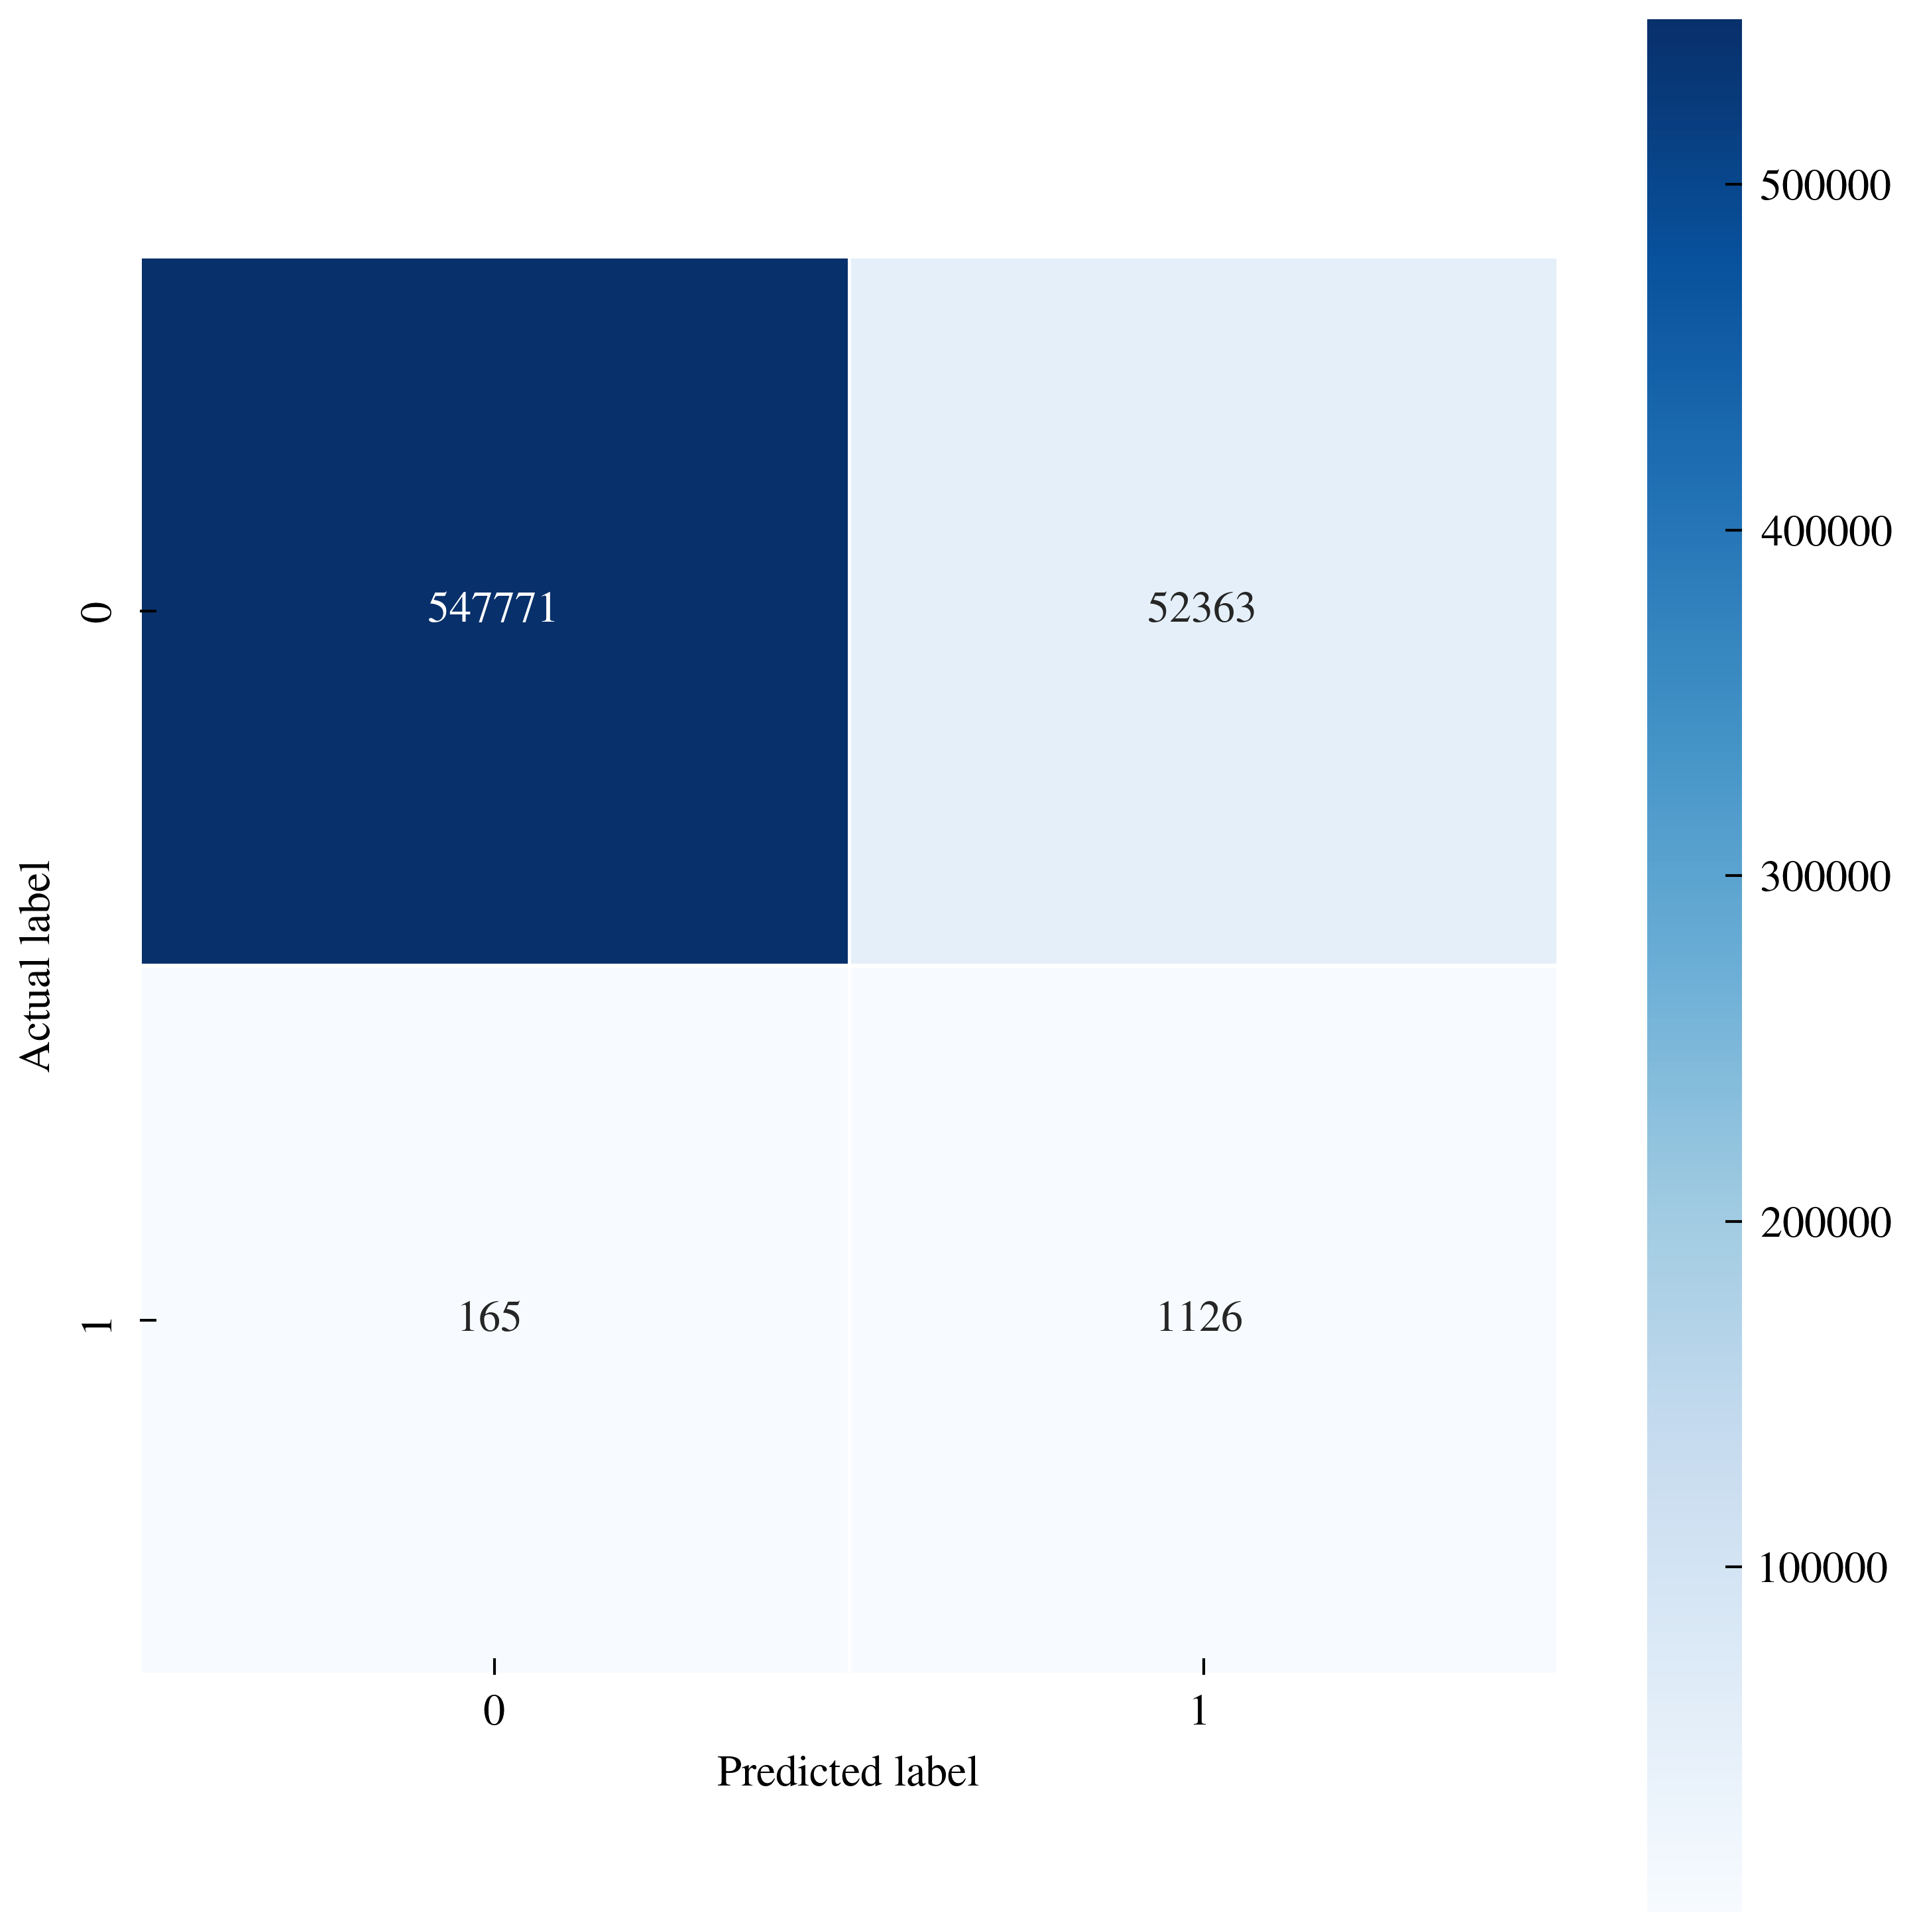

0.9127478196536107
0.8721920991479474
0.892469959400779


In [233]:
# xgboost

weight = len(df_no_loss) / len(df_loss)

shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    if trial == 19:
        df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
        df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])

        df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
        df_train_shuffled = df_train.sample(frac=1).reset_index()
        df_train_shuffled.drop(['index'], axis=1, inplace=True)
        df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
        df_test_shuffled = df_test.sample(frac=1).reset_index()
        df_test_shuffled.drop(['index'], axis=1, inplace=True)

        x_train = df_train_shuffled[full_features_list_removing_500ms]
        x_test = df_test_shuffled[full_features_list_removing_500ms]
        y_train = df_train_shuffled[['lossOrNot']]
        y_train = y_train.astype(int)
        y_test = df_test_shuffled[['lossOrNot']]
        y_test = y_test.astype(int)

        clf_xgb_check = xgb.XGBClassifier(
            n_estimators=500, 
            objective='binary:logistic', 
            scale_pos_weight=weight, 
            n_jobs=48
        )

        clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])

        y_pred = clf_xgb_check.predict(x_test)
        print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,5))
        sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

        report = classification_report(y_test, y_pred, output_dict=True)
        print(report['0']['recall'])
        print(report['1']['recall'])
        print(report['macro avg']['recall'])

In [234]:
# pickle.dump(clf_xgb_check, open('./models/xgb_model_reduced_dataset.pkl', 'wb'))